# 7강 Transformer Tuning 및 기타 모델 성능 개선
> 성능을 올리기 위한 transformer 튜닝 및 기타 모델 성능 개선에 대해서 알아봅시다!

- ⚙️ 환경 설정 (Environment Setting)
- 🦆 개요 (Overview)
- 🎯 Transformer Tuning
- 🎯 LSTM Tuning
- 🏆 기타 모델 성능 개선



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# TODO: 이 실습 파일이 위치하고 있는 경로로 수정
PROJECT_PATH = "drive/MyDrive/AI 부스트캠프/강의용 코드"

# 데이터셋이 모아져있는 폴더
DATA_PATH = os.path.join(PROJECT_PATH, 'data')

# 데이터 csv 파일명
FILE_PATH = 'iscream_public_edu_v4_df.csv'

# ⚙️ 환경 설정 (Environment Setting)
> 베이스라인을 설정하자
- 패키지 설치 (Package Install)
- 패키지 임포트 (Package Import)
- 전처리 (Preprocessing)
- 데이터 셋 (Dataset) / 데이터 로더 (Data Loader)
- 모델 (Model) - Bert / LSTM
- Train / Validation 프로세스

## ⛓ 패키지 설치 (Package Install)

In [ ]:
!pip install -q transformers ray tensorboardX

## ⛓ 패키지 임포트 (Package Import)

In [ ]:
import os
import sys
import gc
import re

import random
import easydict
import tarfile

from tqdm import notebook
from collections import OrderedDict

import time
import datetime
from datetime import datetime

import pandas as pd
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam, AdamW

from torch.optim.lr_scheduler import ReduceLROnPlateau

from transformers import get_linear_schedule_with_warmup
from transformers import get_cosine_schedule_with_warmup

import scipy.stats

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

## ⛓ 전처리 (Preprocessing)

In [ ]:
class Preprocess:
    def __init__(self,args):
        self.args = args
        self.train_data = None

    def get_train_data(self):
        return self.train_data

    def split_data(self, data, ratio=0.7, shuffle=True, seed=0):
        """
        split data into two parts with a given ratio.
        """
        if shuffle:
            random.seed(seed) # fix to default seed 0
            random.shuffle(data)

        size = int(len(data) * ratio)
        data_1 = data[:size]
        data_2 = data[size:]

        return data_1, data_2

    def __save_labels(self, encoder, name):
        le_path = os.path.join(self.args.data_dir, name + '_classes.npy')
        np.save(le_path, encoder.classes_)

    def __preprocessing(self, df):
        cate_cols = ['assessmentItemID', 'testId', 'KnowledgeTag']
        for col in cate_cols:

            #For UNKNOWN class
            a = df[col].unique().tolist() + [np.nan]
            
            le = LabelEncoder()
            le.fit(a)
            df[col] = le.transform(df[col])
            self.__save_labels(le, col)

        def convert_time(s):
            timestamp = time.mktime(datetime.strptime(s, '%Y-%m-%d %H:%M:%S').timetuple())
            return int(timestamp)

        df['Timestamp'] = df['Timestamp'].apply(convert_time)
        
        return df

    def load_data_from_file(self, file_name):
        csv_file_path = os.path.join(self.args.data_dir, file_name)
        df = pd.read_csv(csv_file_path)
        df = self.__preprocessing(df)

        # 추후 feature를 embedding할 시에 embedding_layer의 input 크기를 결정할때 사용
        self.args.n_questions = df['assessmentItemID'].nunique()
        self.args.n_test = df['testId'].nunique()
        self.args.n_tag = df['KnowledgeTag'].nunique()

        df = df.sort_values(by=['userID','Timestamp'], axis=0)
        columns = ['userID', 'assessmentItemID', 'testId', 'answerCode', 'KnowledgeTag']
        group = df[columns].groupby('userID').apply(
                lambda r: (
                    r['testId'].values, 
                    r['assessmentItemID'].values,
                    r['KnowledgeTag'].values,
                    r['answerCode'].values
                )
            )

        return group.values

    def load_train_data(self, file_name):
        self.train_data = self.load_data_from_file(file_name)
        

## ⛓ 데이터 (Data)
- 데이터셋 (Dataset)
- 데이터 로더 (Data Loader)

### 🔧 데이터셋 (Dataset)

In [ ]:
class DKTDataset(torch.utils.data.Dataset):
    def __init__(self, data, args):
        self.data = data
        self.args = args

    def __getitem__(self, index):
        row = self.data[index]

        # 각 data의 sequence length
        seq_len = len(row[0])

        test, question, tag, correct = row[0], row[1], row[2], row[3]
        cate_cols = [test, question, tag, correct]

        # max seq len을 고려하여서 이보다 길면 자르고 아닐 경우 그대로 냅둔다
        if seq_len > self.args.max_seq_len:
            for i, col in enumerate(cate_cols):
                cate_cols[i] = col[-self.args.max_seq_len:]
            mask = np.ones(self.args.max_seq_len, dtype=np.int16)
        else:
            mask = np.zeros(self.args.max_seq_len, dtype=np.int16)
            mask[:seq_len] = 1

        # mask도 columns 목록에 포함시킴
        cate_cols.append(mask)

        # np.array -> torch.tensor 형변환
        for i, col in enumerate(cate_cols):
            cate_cols[i] = torch.tensor(col)

        return cate_cols

    def __len__(self):
        return len(self.data)

### 🔧 데이터 로더 (Data Loader)

In [ ]:
from torch.nn.utils.rnn import pad_sequence


def collate(batch):
    col_n = len(batch[0])
    col_list = [[] for _ in range(col_n)]

    # batch의 값들을 각 column끼리 그룹화
    for row in batch:
        for i, col in enumerate(row):
            col_list[i].append(col)

    # 각 column의 값들을 대상으로 padding 진행
    # pad_sequence([[1, 2, 3], [3, 4]]) -> [[1, 2, 3],
    #                                       [3, 4, 0]]
    for i, col_batch in enumerate(col_list):
        col_list[i] = pad_sequence(col_batch, batch_first=True)

    # mask의 경우 max_seq_len을 기준으로 길이가 설정되어있다.
    # 만약 다른 column들의 seq_len이 max_seq_len보다 작다면
    # 이 길이에 맞추어 mask의 길이도 조절해준다
    col_seq_len = col_list[0].size(1)
    mask_seq_len = col_list[-1].size(1)
    if col_seq_len < mask_seq_len:
        col_list[-1] = col_list[-1][:, :col_seq_len]

    return tuple(col_list)


def get_loaders(args, train, valid):

    pin_memory = False

    trainset = DKTDataset(train, args)
    valset = DKTDataset(valid, args)

    train_loader = torch.utils.data.DataLoader(trainset, shuffle=True,
                                               batch_size=args.batch_size,
                                               pin_memory=pin_memory,
                                               collate_fn=collate)

    valid_loader = torch.utils.data.DataLoader(valset, shuffle=False,
                                               batch_size=args.batch_size,
                                               pin_memory=pin_memory,
                                               collate_fn=collate)

    return train_loader, valid_loader

## ⛓ 데이터 증강 (Data Augmentation)
- Slidding Window with Shuffle
- Augmentation 종합 

### 🔧 Slidding Window with Shuffle

In [ ]:
def slidding_window(data, args):
    window_size = args.max_seq_len
    stride = args.stride

    augmented_datas = []
    for row in data:
        seq_len = len(row[0])

        # 만약 window 크기보다 seq len이 같거나 작으면 augmentation을 하지 않는다
        if seq_len <= window_size:
            augmented_datas.append(row)
        else:
            total_window = ((seq_len - window_size) // stride) + 1
            
            # 앞에서부터 slidding window 적용
            for window_i in range(total_window):
                # window로 잘린 데이터를 모으는 리스트
                window_data = []
                for col in row:
                    window_data.append(col[window_i*stride:window_i*stride + window_size])

                # Shuffle
                # 마지막 데이터의 경우 shuffle을 하지 않는다
                if args.shuffle and window_i + 1 != total_window:
                    shuffle_datas = shuffle(window_data, window_size, args)
                    augmented_datas += shuffle_datas
                else:
                    augmented_datas.append(tuple(window_data))

            # slidding window에서 뒷부분이 누락될 경우 추가
            total_len = window_size + (stride * (total_window - 1))
            if seq_len != total_len:
                window_data = []
                for col in row:
                    window_data.append(col[-window_size:])
                augmented_datas.append(tuple(window_data))


    return augmented_datas

def shuffle(data, data_size, args):
    shuffle_datas = []
    for i in range(args.shuffle_n):
        # shuffle 횟수만큼 window를 랜덤하게 계속 섞어서 데이터로 추가
        shuffle_data = []
        random_index = np.random.permutation(data_size)
        for col in data:
            shuffle_data.append(col[random_index])
        shuffle_datas.append(tuple(shuffle_data))
    return shuffle_datas
        

### 🔧 Augmentation 종합 

In [ ]:
def data_augmentation(data, args):
    if args.window == True:
        data = slidding_window(data, args)

    return data

## ⛓ 모델 (Model)
- Bert
- LSTM
- Saint
- Last Query

### 🔧 Bert

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import numpy as np
import copy
import math

try:
    from transformers.modeling_bert import BertConfig, BertEncoder, BertModel    
except:
    from transformers.models.bert.modeling_bert import BertConfig, BertEncoder, BertModel
   

class Bert(nn.Module):

    def __init__(self, args):
        super(Bert, self).__init__()
        self.args = args
        self.device = args.device

        # Defining some parameters
        self.hidden_dim = self.args.hidden_dim
        self.n_layers = self.args.n_layers

        # Embedding 
        # interaction은 현재 correct으로 구성되어있다. correct(1, 2) + padding(0)
        self.embedding_interaction = nn.Embedding(3, self.hidden_dim//3)
        self.embedding_test = nn.Embedding(self.args.n_test + 1, self.hidden_dim//3)
        self.embedding_question = nn.Embedding(self.args.n_questions + 1, self.hidden_dim//3)
        self.embedding_tag = nn.Embedding(self.args.n_tag + 1, self.hidden_dim//3)

        # embedding combination projection
        self.comb_proj = nn.Linear((self.hidden_dim//3)*4, self.hidden_dim)

        # Bert config
        self.config = BertConfig( 
            3, # not used
            hidden_size=self.hidden_dim,
            num_hidden_layers=self.args.n_layers,
            num_attention_heads=self.args.n_heads,
            max_position_embeddings=self.args.max_seq_len          
        )

        # Defining the layers
        # Bert Layer
        self.encoder = BertModel(self.config)  

        # Fully connected layer
        self.fc = nn.Linear(self.args.hidden_dim, 1)
       
        self.activation = nn.Sigmoid()


    def forward(self, input):
        test, question, tag, _, mask, interaction, _ = input
        batch_size = interaction.size(0)

        # 신나는 embedding
        embed_interaction = self.embedding_interaction(interaction)
        embed_test = self.embedding_test(test)
        embed_question = self.embedding_question(question)
        embed_tag = self.embedding_tag(tag)

        embed = torch.cat([embed_interaction,
                           embed_test,
                           embed_question,
                           embed_tag,], 2)

        X = self.comb_proj(embed)

        # Bert
        encoded_layers = self.encoder(inputs_embeds=X, attention_mask=mask)
        out = encoded_layers[0]
        out = out.contiguous().view(batch_size, -1, self.hidden_dim)
        out = self.fc(out)
        preds = self.activation(out).view(batch_size, -1)

        return preds

### 🔧 LSTM

In [ ]:
class LSTM(nn.Module):

    def __init__(self, args):
        super(LSTM, self).__init__()
        self.args = args
        self.device = args.device

        self.hidden_dim = self.args.hidden_dim
        self.n_layers = self.args.n_layers

        # Embedding 
        # interaction은 현재 correct로 구성되어있다. correct(1, 2) + padding(0)
        self.embedding_interaction = nn.Embedding(3, self.hidden_dim//3)
        self.embedding_test = nn.Embedding(self.args.n_test + 1, self.hidden_dim//3)
        self.embedding_question = nn.Embedding(self.args.n_questions + 1, self.hidden_dim//3)
        self.embedding_tag = nn.Embedding(self.args.n_tag + 1, self.hidden_dim//3)

        # embedding combination projection
        self.comb_proj = nn.Linear((self.hidden_dim//3)*4, self.hidden_dim)

        self.lstm = nn.LSTM(self.hidden_dim,
                            self.hidden_dim,
                            self.n_layers,
                            batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Linear(self.hidden_dim, 1)

        self.activation = nn.Sigmoid()

    def init_hidden(self, batch_size):

        h = torch.zeros(
            self.n_layers,
            batch_size,
            self.hidden_dim)
        h = h.to(self.device)

        c = torch.zeros(
            self.n_layers,
            batch_size,
            self.hidden_dim)
        c = c.to(self.device)

        return (h, c)

    def forward(self, input):

        test, question, tag, _, mask, interaction, _ = input
        batch_size = interaction.size(0)

        # Embedding
        embed_interaction = self.embedding_interaction(interaction)
        embed_test = self.embedding_test(test)
        embed_question = self.embedding_question(question)
        embed_tag = self.embedding_tag(tag)
        
        embed = torch.cat([embed_interaction,
                           embed_test,
                           embed_question,
                           embed_tag,], 2)

        X = self.comb_proj(embed)

        hidden = self.init_hidden(batch_size)
        out, hidden = self.lstm(X, hidden)
        out = out.contiguous().view(batch_size, -1, self.hidden_dim)
        out = self.fc(out)
        preds = self.activation(out).view(batch_size, -1)

        return preds

### 🔧 Saint

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.scale = nn.Parameter(torch.ones(1))

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(
            0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.scale * self.pe[:x.size(0), :]
        return self.dropout(x)

class Saint(nn.Module):
    
    def __init__(self, args):
        super(Saint, self).__init__()
        self.args = args
        self.device = args.device

        self.hidden_dim = self.args.hidden_dim
        # self.dropout = self.args.dropout
        self.dropout = 0.
        
        ### Embedding 
        # ENCODER embedding
        self.embedding_test = nn.Embedding(self.args.n_test + 1, self.hidden_dim//3)
        self.embedding_question = nn.Embedding(self.args.n_questions + 1, self.hidden_dim//3)
        self.embedding_tag = nn.Embedding(self.args.n_tag + 1, self.hidden_dim//3)
        
        # encoder combination projection
        self.enc_comb_proj = nn.Linear((self.hidden_dim//3)*3, self.hidden_dim)

        # DECODER embedding
        # interaction은 현재 correct으로 구성되어있다. correct(1, 2) + padding(0)
        self.embedding_interaction = nn.Embedding(3, self.hidden_dim//3)
        
        # decoder combination projection
        self.dec_comb_proj = nn.Linear((self.hidden_dim//3)*4, self.hidden_dim)

        # Positional encoding
        self.pos_encoder = PositionalEncoding(self.hidden_dim, self.dropout, self.args.max_seq_len)
        self.pos_decoder = PositionalEncoding(self.hidden_dim, self.dropout, self.args.max_seq_len)
        

        self.transformer = nn.Transformer(
            d_model=self.hidden_dim, 
            nhead=self.args.n_heads,
            num_encoder_layers=self.args.n_layers, 
            num_decoder_layers=self.args.n_layers, 
            dim_feedforward=self.hidden_dim, 
            dropout=self.dropout, 
            activation='relu')

        self.fc = nn.Linear(self.hidden_dim, 1)
        self.activation = nn.Sigmoid()

        self.enc_mask = None
        self.dec_mask = None
        self.enc_dec_mask = None
    
    def get_mask(self, seq_len):
        mask = torch.from_numpy(np.triu(np.ones((seq_len, seq_len)), k=1))

        return mask.masked_fill(mask==1, float('-inf'))

    def forward(self, input):
        test, question, tag, _, mask, interaction= input

        batch_size = interaction.size(0)
        seq_len = interaction.size(1)

        # 신나는 embedding
        # ENCODER
        embed_test = self.embedding_test(test)
        embed_question = self.embedding_question(question)
        embed_tag = self.embedding_tag(tag)

        embed_enc = torch.cat([embed_test,
                               embed_question,
                               embed_tag,], 2)

        embed_enc = self.enc_comb_proj(embed_enc)
        
        # DECODER     
        embed_test = self.embedding_test(test)
        embed_question = self.embedding_question(question)
        embed_tag = self.embedding_tag(tag)

        embed_interaction = self.embedding_interaction(interaction)

        embed_dec = torch.cat([embed_test,
                               embed_question,
                               embed_tag,
                               embed_interaction], 2)

        embed_dec = self.dec_comb_proj(embed_dec)

        # ATTENTION MASK 생성
        # encoder하고 decoder의 mask는 가로 세로 길이가 모두 동일하여
        # 사실 이렇게 3개로 나눌 필요가 없다
        if self.enc_mask is None or self.enc_mask.size(0) != seq_len:
            self.enc_mask = self.get_mask(seq_len).to(self.device)
            
        if self.dec_mask is None or self.dec_mask.size(0) != seq_len:
            self.dec_mask = self.get_mask(seq_len).to(self.device)
            
        if self.enc_dec_mask is None or self.enc_dec_mask.size(0) != seq_len:
            self.enc_dec_mask = self.get_mask(seq_len).to(self.device)
            
  
        embed_enc = embed_enc.permute(1, 0, 2)
        embed_dec = embed_dec.permute(1, 0, 2)
        
        # Positional encoding
        embed_enc = self.pos_encoder(embed_enc)
        embed_dec = self.pos_decoder(embed_dec)
        
        out = self.transformer(embed_enc, embed_dec,
                               src_mask=self.enc_mask,
                               tgt_mask=self.dec_mask,
                               memory_mask=self.enc_dec_mask)

        out = out.permute(1, 0, 2)
        out = out.contiguous().view(batch_size, -1, self.hidden_dim)
        out = self.fc(out)

        preds = self.activation(out).view(batch_size, -1)

        return preds

### 🔧 Last Query

#### Post Padding 사용시
> post padding을 사용할 경우 last query 구현이 조금 까다롭다. Tensor의 변화 흐름을 한번 즈음 직접 느껴보면서 아래 2가지를 유심히 살펴보자!

- 3D tensor에서 원하는 last query 데이터만 가져오기 위한 `gather`와 `index` 사용법
- last query를 위한 3D mask 만들기

In [ ]:

class Feed_Forward_block(nn.Module):
    """
    out =  Relu( M_out*w1 + b1) *w2 + b2
    """
    def __init__(self, dim_ff):
        super().__init__()
        self.layer1 = nn.Linear(in_features=dim_ff, out_features=dim_ff)
        self.layer2 = nn.Linear(in_features=dim_ff, out_features=dim_ff)

    def forward(self,ffn_in):
        return self.layer2(F.relu(self.layer1(ffn_in)))

class LastQuery(nn.Module):
    def __init__(self, args):
        super(LastQuery, self).__init__()
        self.args = args
        self.device = args.device

        self.hidden_dim = self.args.hidden_dim
        
        # Embedding 
        # interaction은 현재 correct으로 구성되어있다. correct(1, 2) + padding(0)
        self.embedding_interaction = nn.Embedding(3, self.hidden_dim//3)
        self.embedding_test = nn.Embedding(self.args.n_test + 1, self.hidden_dim//3)
        self.embedding_question = nn.Embedding(self.args.n_questions + 1, self.hidden_dim//3)
        self.embedding_tag = nn.Embedding(self.args.n_tag + 1, self.hidden_dim//3)
        self.embedding_position = nn.Embedding(self.args.max_seq_len, self.hidden_dim)

        # embedding combination projection
        self.comb_proj = nn.Linear((self.hidden_dim//3)*4, self.hidden_dim)

        # 기존 keetar님 솔루션에서는 Positional Embedding은 사용되지 않습니다
        # 하지만 사용 여부는 자유롭게 결정해주세요 :)
        # self.embedding_position = nn.Embedding(self.args.max_seq_len, self.hidden_dim)
        
        # Encoder
        self.query = nn.Linear(in_features=self.hidden_dim, out_features=self.hidden_dim)
        self.key = nn.Linear(in_features=self.hidden_dim, out_features=self.hidden_dim)
        self.value = nn.Linear(in_features=self.hidden_dim, out_features=self.hidden_dim)

        self.attn = nn.MultiheadAttention(embed_dim=self.hidden_dim, num_heads=self.args.n_heads)
        self.mask = None # last query에서는 필요가 없지만 수정을 고려하여서 넣어둠
        self.ffn = Feed_Forward_block(self.hidden_dim)      

        self.ln1 = nn.LayerNorm(self.hidden_dim)
        self.ln2 = nn.LayerNorm(self.hidden_dim)

        # LSTM
        self.lstm = nn.LSTM(
            self.hidden_dim,
            self.hidden_dim,
            self.args.n_layers,
            batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(self.hidden_dim, 1)
       
        self.activation = nn.Sigmoid()


    def get_mask(self, seq_len, index, batch_size):
        """
        batchsize * n_head 수만큼 각 mask를 반복하여 증가시킨다
        
        참고로 (batch_size*self.args.n_heads, seq_len, seq_len) 가 아니라
              (batch_size*self.args.n_heads,       1, seq_len) 로 하는 이유는
        
        last query라 output의 seq부분의 사이즈가 1이기 때문이다
        """
        # [[1], -> [1, 2, 3]
        #  [2],
        #  [3]]
        index = index.view(-1)

        # last query의 index에 해당하는 upper triangular mask의 row를 사용한다
        mask = torch.from_numpy(np.triu(np.ones((seq_len, seq_len)), k=1))
        mask = mask[index]

        # batchsize * n_head 수만큼 각 mask를 반복하여 증가시킨다
        mask = mask.repeat(1, self.args.n_heads).view(batch_size*self.args.n_heads, -1, seq_len)
        return mask.masked_fill(mask==1, float('-inf'))

    def get_pos(self, seq_len):
        # use sine positional embeddinds
        return torch.arange(seq_len).unsqueeze(0)
 
    def init_hidden(self, batch_size):
        h = torch.zeros(
            self.args.n_layers,
            batch_size,
            self.args.hidden_dim)
        h = h.to(self.device)

        c = torch.zeros(
            self.args.n_layers,
            batch_size,
            self.args.hidden_dim)
        c = c.to(self.device)

        return (h, c)


    def forward(self, input):
        test, question, tag, _, mask, interaction, index = input
        batch_size = interaction.size(0)
        seq_len = interaction.size(1)

        # 신나는 embedding
        embed_interaction = self.embedding_interaction(interaction)
        embed_test = self.embedding_test(test)
        embed_question = self.embedding_question(question)
        embed_tag = self.embedding_tag(tag)

        embed = torch.cat([embed_interaction,
                           embed_test,
                           embed_question,
                           embed_tag,], 2)

        embed = self.comb_proj(embed)

        # Positional Embedding
        # last query에서는 positional embedding을 하지 않음
        # position = self.get_pos(seq_len).to('cuda')
        # embed_pos = self.embedding_position(position)
        # embed = embed + embed_pos

        ####################### ENCODER #####################
        q = self.query(embed)

        # 이 3D gathering은 머리가 아픕니다. 잠시 머리를 식히고 옵니다.
        q = torch.gather(q, 1, index.repeat(1, self.hidden_dim).unsqueeze(1))
        q = q.permute(1, 0, 2)

        k = self.key(embed).permute(1, 0, 2)
        v = self.value(embed).permute(1, 0, 2)

        ## attention
        # last query only
        self.mask = self.get_mask(seq_len, index, batch_size).to(self.device)
        out, _ = self.attn(q, k, v, attn_mask=self.mask)
        
        ## residual + layer norm
        out = out.permute(1, 0, 2)
        out = embed + out
        out = self.ln1(out)

        ## feed forward network
        out = self.ffn(out)

        ## residual + layer norm
        out = embed + out
        out = self.ln2(out)

        ###################### LSTM #####################
        hidden = self.init_hidden(batch_size)
        out, hidden = self.lstm(out, hidden)

        ###################### DNN #####################
        out = out.contiguous().view(batch_size, -1, self.hidden_dim)
        out = self.fc(out)

        preds = self.activation(out).view(batch_size, -1)

        return preds


#### Pre Padding 사용시
> 별도의 도움 없이도 쉽사리 구현이 가능하다! 어떻게 `query` sequence의 마지막 부분만 indexing을 통하여 가져올지 생각하면서 아래 코드를 읽어보자!

In [ ]:
class Feed_Forward_block(nn.Module):
    """
    out =  Relu( M_out*w1 + b1) *w2 + b2
    """
    def __init__(self, dim_ff):
        super().__init__()
        self.layer1 = nn.Linear(in_features=dim_ff, out_features=dim_ff)
        self.layer2 = nn.Linear(in_features=dim_ff, out_features=dim_ff)

    def forward(self,ffn_in):
        return self.layer2(F.relu(self.layer1(ffn_in)))

class LastQuery(nn.Module):
    def __init__(self, args):
        super(LastQuery, self).__init__()
        self.args = args
        self.device = args.device

        self.hidden_dim = self.args.hidden_dim
        
        # Embedding 
        # interaction은 현재 correct으로 구성되어있다. correct(1, 2) + padding(0)
        self.embedding_interaction = nn.Embedding(3, self.hidden_dim//3)
        self.embedding_test = nn.Embedding(self.args.n_test + 1, self.hidden_dim//3)
        self.embedding_question = nn.Embedding(self.args.n_questions + 1, self.hidden_dim//3)
        self.embedding_tag = nn.Embedding(self.args.n_tag + 1, self.hidden_dim//3)
        self.embedding_position = nn.Embedding(self.args.max_seq_len, self.hidden_dim)

        # embedding combination projection
        self.comb_proj = nn.Linear((self.hidden_dim//3)*4, self.hidden_dim)

        # 기존 keetar님 솔루션에서는 Positional Embedding은 사용되지 않습니다
        # 하지만 사용 여부는 자유롭게 결정해주세요 :)
        # self.embedding_position = nn.Embedding(self.args.max_seq_len, self.hidden_dim)
        
        # Encoder
        self.query = nn.Linear(in_features=self.hidden_dim, out_features=self.hidden_dim)
        self.key = nn.Linear(in_features=self.hidden_dim, out_features=self.hidden_dim)
        self.value = nn.Linear(in_features=self.hidden_dim, out_features=self.hidden_dim)

        self.attn = nn.MultiheadAttention(embed_dim=self.hidden_dim, num_heads=self.args.n_heads)
        self.mask = None # last query에서는 필요가 없지만 수정을 고려하여서 넣어둠
        self.ffn = Feed_Forward_block(self.hidden_dim)      

        self.ln1 = nn.LayerNorm(self.hidden_dim)
        self.ln2 = nn.LayerNorm(self.hidden_dim)

        # LSTM
        self.lstm = nn.LSTM(
            self.hidden_dim,
            self.hidden_dim,
            self.args.n_layers,
            batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(self.hidden_dim, 1)
       
        self.activation = nn.Sigmoid()

    def get_pos(self, seq_len):
        # use sine positional embeddinds
        return torch.arange(seq_len).unsqueeze(0)
 
    def init_hidden(self, batch_size):
        h = torch.zeros(
            self.args.n_layers,
            batch_size,
            self.args.hidden_dim)
        h = h.to(self.device)

        c = torch.zeros(
            self.args.n_layers,
            batch_size,
            self.args.hidden_dim)
        c = c.to(self.device)

        return (h, c)


    def forward(self, input):
        test, question, tag, _, mask, interaction = input
        batch_size = interaction.size(0)
        seq_len = interaction.size(1)

        # 신나는 embedding
        embed_interaction = self.embedding_interaction(interaction)
        embed_test = self.embedding_test(test)
        embed_question = self.embedding_question(question)
        embed_tag = self.embedding_tag(tag)

        embed = torch.cat([embed_interaction,
                           embed_test,
                           embed_question,
                           embed_tag,], 2)

        embed = self.comb_proj(embed)

        # Positional Embedding
        # last query에서는 positional embedding을 하지 않음
        # position = self.get_pos(seq_len).to('cuda')
        # embed_pos = self.embedding_position(position)
        # embed = embed + embed_pos

        ####################### ENCODER #####################

        q = self.query(embed).permute(1, 0, 2)
        
        
        q = self.query(embed)[:, -1:, :].permute(1, 0, 2)
        
        
        
        k = self.key(embed).permute(1, 0, 2)
        v = self.value(embed).permute(1, 0, 2)

        ## attention
        # last query only
        out, _ = self.attn(q, k, v)
        
        ## residual + layer norm
        out = out.permute(1, 0, 2)
        out = embed + out
        out = self.ln1(out)

        ## feed forward network
        out = self.ffn(out)

        ## residual + layer norm
        out = embed + out
        out = self.ln2(out)

        ###################### LSTM #####################
        hidden = self.init_hidden(batch_size)
        out, hidden = self.lstm(out, hidden)

        ###################### DNN #####################
        out = out.contiguous().view(batch_size, -1, self.hidden_dim)
        out = self.fc(out)

        preds = self.activation(out).view(batch_size, -1)

        print(preds)

        return preds


## ⛓ Train / Validation 프로세스
- get_optimizer
- get_scheduler
- get_criterion
- get_metric
- get_model
- process_batch
- compute_loss
- get_gradient
- train
- validate
- 🌟 run 🌟


### 🔧 get_optimizer


In [ ]:
def get_optimizer(model, args):
    if args.optimizer == 'adam':
        optimizer = Adam(model.parameters(), lr=args.lr, weight_decay=0.0)
    if args.optimizer == 'adamW':
        optimizer = AdamW(model.parameters(), lr=args.lr, weight_decay=0.0)
    
    # 모든 parameter들의 grad값을 0으로 초기화
    optimizer.zero_grad()
    
    return optimizer

### 🔧 get_scheduler

In [ ]:
def get_scheduler(optimizer, args):
    if args.scheduler == 'plateau':
        scheduler = ReduceLROnPlateau(optimizer, patience=10, factor=0.5, mode='max', verbose=True)
    elif args.scheduler == 'linear_warmup':
        scheduler = get_linear_schedule_with_warmup(optimizer,
                                                    num_warmup_steps=args.warmup_steps,
                                                    num_training_steps=args.total_steps)
    return scheduler

### 🔧 get_criterion

In [ ]:
def get_criterion(pred, target):
    loss = nn.BCELoss(reduction="none")
    return loss(pred, target)

### 🔧 get_metric

In [ ]:
def get_metric(targets, preds):
    auc = roc_auc_score(targets, preds)
    acc = accuracy_score(targets, np.where(preds >= 0.5, 1, 0))

    return auc, acc

### 🔧 get_model

In [ ]:
def get_model(args):
    """
    Load model and move tensors to a given devices.
    """
    if args.model == 'lstm': model = LSTM(args)
    if args.model == 'bert': model = Bert(args)
    if args.model == 'last_query': model = LastQuery(args)
    if args.model == 'saint': model = Saint(args)
    if args.model == 'tfixup': model = FixupEncoder(args)

    model.to(args.device)

    return model

### 🔧 process_batch

In [ ]:
# 배치 전처리
def process_batch(batch, args):

    test, question, tag, correct, mask = batch

    # change to float
    mask = mask.type(torch.FloatTensor)
    correct = correct.type(torch.FloatTensor)

    #  interaction을 임시적으로 correct를 한칸 우측으로 이동한 것으로 사용
    #    saint의 경우 decoder에 들어가는 input이다
    interaction = correct + 1 # 패딩을 위해 correct값에 1을 더해준다.
    interaction = interaction.roll(shifts=1, dims=1)
    interaction[:, 0] = 0 # set padding index to the first sequence
    interaction = (interaction * mask).to(torch.int64)


    #  test_id, question_id, tag
    test = ((test + 1) * mask).to(torch.int64)
    question = ((question + 1) * mask).to(torch.int64)
    tag = ((tag + 1) * mask).to(torch.int64)

    # gather index
    # 마지막 sequence만 사용하기 위한 index
    gather_index = torch.tensor(np.count_nonzero(mask, axis=1))
    gather_index = gather_index.view(-1, 1) - 1


    # device memory로 이동
    test = test.to(args.device)
    question = question.to(args.device)


    tag = tag.to(args.device)
    correct = correct.to(args.device)
    mask = mask.to(args.device)

    interaction = interaction.to(args.device)
    gather_index = gather_index.to(args.device)

    return (test, question,
            tag, correct, mask,
            interaction, gather_index)

### 🔧 compute_loss

In [ ]:
# loss계산하고 parameter update!
def compute_loss(preds, targets, index):
    """
    Args :
        preds   : (batch_size, max_seq_len)
        targets : (batch_size, max_seq_len)
        index    : (batch_size, max_seq_len)

        만약 전체 sequence 길이가 max_seq_len보다 작다면 해당 길이로 진행
    """
    loss = get_criterion(preds, targets)
    loss = torch.gather(loss, 1, index)
    loss = torch.mean(loss)
    
    return loss

### 🔧 get_gradient

In [ ]:
def get_gradient(model):
    gradient = []

    for name, param in model.named_parameters():
        grad = param.grad
        if grad != None:
            gradient.append(grad.cpu().numpy().astype(np.float16))
            # gradient.append(grad.clone().detach())
        else:
            gradient.append(None)

    return gradient

### 🔧 train

In [ ]:
def train(train_loader, model, optimizer, scheduler, args, gradient=False):
    model.train()

    total_preds = []
    total_targets = []
    for step, batch in enumerate(train_loader):
        input = process_batch(batch, args)
        
        preds = model(input)
        targets = input[3] # correct
        index = input[-1] # gather index
        
        loss = compute_loss(preds, targets, index)
        loss.backward()

        # save gradient distribution
        if gradient:
            args.n_iteration += 1
            args.gradient[f'iteration_{args.n_iteration}'] = get_gradient(model)

        # grad clip
        if args.clip_grad:
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip_grad)

        optimizer.step()
        optimizer.zero_grad()

        # warmup scheduler
        if args.scheduler == 'linear_warmup':
            scheduler.step()

        # predictions
        preds = preds.gather(1, index).view(-1)
        targets = targets.gather(1, index).view(-1)

        if args.device == 'cuda':
            preds = preds.to('cpu').detach().numpy()
            targets = targets.to('cpu').detach().numpy()
        else: # cpu
            preds = preds.detach().numpy()
            targets = targets.detach().numpy()

        total_preds.append(preds)
        total_targets.append(targets)

    total_preds = np.concatenate(total_preds)
    total_targets = np.concatenate(total_targets)

    # Train AUC / ACC
    auc, acc = get_metric(total_targets, total_preds)
    
    return auc, acc


### 🔧 validate

In [ ]:
def validate(valid_loader, model, args):
    model.eval()

    total_preds = []
    total_targets = []
    for step, batch in enumerate(valid_loader):
        input = process_batch(batch, args)

        preds = model(input)
        targets = input[3] # correct
        index = input[-1] # gather index

        # predictions
        preds = preds.gather(1, index).view(-1)
        targets = targets.gather(1, index).view(-1)

        if args.device == 'cuda':
            preds = preds.to('cpu').detach().numpy()
            targets = targets.to('cpu').detach().numpy()
        else: # cpu
            preds = preds.detach().numpy()
            targets = targets.detach().numpy()

        total_preds.append(preds)
        total_targets.append(targets)

    total_preds = np.concatenate(total_preds)
    total_targets = np.concatenate(total_targets)

    # Train AUC / ACC
    auc, acc = get_metric(total_targets, total_preds)

    return auc, acc, total_preds, total_targets

### 🔧 🌟 run 🌟
> 위의 모든 함수들은 이 `run`함수를 통해 실행되며 가장 중요한 함수이다. 우리가 실험에서 확인할 모든 값은 여기서 생성되어 반환된다.

In [ ]:
def run(args, train_data, valid_data, gradient=False):

    # 캐시 메모리 비우기 및 가비지 컬렉터 가동!
    torch.cuda.empty_cache()
    gc.collect()

    # augmentation
    augmented_train_data = data_augmentation(train_data, args)
    if len(augmented_train_data) != len(train_data):
        print(f"Data Augmentation applied. Train data {len(train_data)} -> {len(augmented_train_data)}\n")

    train_loader, valid_loader = get_loaders(args, augmented_train_data, valid_data)
    
    # only when using warmup scheduler
    args.total_steps = int(len(train_loader.dataset) / args.batch_size) * (args.n_epochs)
    args.warmup_steps = args.total_steps // 10
         
    model = get_model(args)
    optimizer = get_optimizer(model, args)
    scheduler = get_scheduler(optimizer, args)

    # 🌟 분석에 사용할 값 저장 🌟
    report = OrderedDict()

    # gradient step 분석에 사용할 변수
    if gradient:
        args.n_iteration = 0
        args.gradient = OrderedDict()

        # 모델의 gradient값을 가리키는 모델 명 저장
        args.gradient['name'] = [name for name, _ in model.named_parameters()]

    best_auc = -1
    best_auc_epoch = -1
    best_acc = -1
    best_acc_epoch = -1
    for epoch in notebook.tqdm(range(args.n_epochs)):
        epoch_report = {}

        ### TRAIN
        train_start_time = time.time()
        train_auc, train_acc = train(train_loader, model, optimizer, scheduler, args, gradient)
        train_time = time.time() - train_start_time

        epoch_report['train_auc'] = train_auc
        epoch_report['train_acc'] = train_acc
        epoch_report['train_time'] = train_time
        
        ### VALID
        valid_start_time = time.time()
        valid_auc, valid_acc, preds, targets = validate(valid_loader, model, args)
        valid_time = time.time() - valid_start_time

        epoch_report['valid_auc'] = valid_auc
        epoch_report['valid_acc'] = valid_acc
        epoch_report['valid_time'] = valid_time

        # save lr
        epoch_report['lr'] = optimizer.param_groups[0]['lr']


        # 🌟 save it to report 🌟
        report[f'{epoch + 1}'] = epoch_report


        ### TODO: model save or early stopping
        if valid_auc > best_auc:
            best_auc = valid_auc
            best_auc_epoch = epoch + 1

        if valid_acc > best_acc:
            best_acc = valid_acc
            best_acc_epoch = epoch + 1

        # scheduler
        if args.scheduler == 'plateau':
            scheduler.step(best_auc)

    # save best records
    report['best_auc'] = best_auc
    report['best_auc_epoch'] = best_auc_epoch
    report['best_acc'] = best_acc
    report['best_acc_epoch'] = best_acc_epoch

    # save gradient informations
    if gradient:
        report['gradient'] = args.gradient
        del args.gradient
        del args['gradient']

    return report


# 🦆 개요 (Overview)
> 이 과정에서 다양한 실험을 진행하기 위한 준비와 우리가 하이퍼파라메타 값을 어떻게 바꾸고, 튜닝할 때 어떤 도구를 사용하고, 어떤 결과를 살퍼볼 것인지 전반적으로 살펴보자

- 설정 (configuration)
- 시드 (Seed)
- 데이터 준비 (Data Preparation)
- 리포트 (Report)
- hyperopt
- ray


## 🐤 설정 (configuration)
> 우리는 `easydict`을 사용해 configuration값들을 관리할 것이다. `args`에 담겨있는 값을 수정하면 바로 새로운 실험을 시작할 수 있게끔 코드가 설계되어있기 때문에 우리는 간편하게 여러 실험을 수행할 수 있다.

In [ ]:
config = {}

# 설정
config['seed'] = 42
config['device'] = "cuda" if torch.cuda.is_available() else "cpu"
config['data_dir'] = DATA_PATH

# 데이터
config['max_seq_len'] = 300

# 데이터 증강 (Data Augmentation)
config['window'] = False
config['stride'] = config['max_seq_len']
config['shuffle'] = False
config['shuffle_n'] = 2

# 모델
config['hidden_dim'] = 128
config['n_layers'] = 1
config['dropout'] = 0.0
config['n_heads'] = 4

# T Fixup
config['Tfixup'] = False
config['layer_norm'] = True

# 훈련
config['n_epochs'] = 10
config['batch_size'] = 64
config['lr'] = 0.0001
config['clip_grad'] = 0

### 중요 ###
config['model'] = 'bert'
config['optimizer'] = 'adam'
config['scheduler'] = 'plateau'

args = easydict.EasyDict(config)

## 🐤 데이터 준비 (Data Preparation)
> 앞으로 사용하게 될 train 데이터와 valid 데이터를 준비한다. 이 데이터들은 유저(user) 단위로 나뉘어져 있다.

In [ ]:
preprocess = Preprocess(args)
preprocess.load_train_data(FILE_PATH)

train_data = preprocess.get_train_data()
train_data, valid_data = preprocess.split_data(train_data)

In [ ]:
print(f"훈련(train) 데이터 준비 완료 : {len(train_data)} 개")
print(f"검증(valid) 데이터 준비 완료 : {len(valid_data)} 개")

훈련(train) 데이터 준비 완료 : 5209 개
검증(valid) 데이터 준비 완료 : 2233 개


In [ ]:
columns = ['testId', 'assessmentItemID', 'KnowledgeTag', 'answerCode']
user_data = train_data[0]

# 각 데이터에 어떤 값이 들어있는지 체크해보자
for column, data in zip(columns, user_data):
    print(f'{column:18} : {data[:10]}')

testId             : [1163 1163 1163 1163 1163 1163 1163 1163 1163 1169]
assessmentItemID   : [6585 6586 6587 6588 6589 6593 6591 6592 6590 6639]
KnowledgeTag       : [366 366 366   9 365 366   8 366 366 372]
answerCode         : [0 0 0 0 0 1 0 0 0 1]


## 🐤 시드 (Seed)
> 실험 결과를 다시 재현하는 재현성(reproducibility)을 보장할 수 있해 우리는 seed를 고정시켜 사용한다. 더군다나 우리는 한번의 훈련을 하는 것이 아니라 이 과정을 거치면서 여러번의 훈련을 반복하는 만큼 이는 매우 중요하다.
<br><br>
seed를 고정할 경우 하이퍼파라메타를 튜닝하면서 나오는 결과값의 비교가 더욱 수월하다. 최종 성능이 올라갈때 하이퍼파라메타 변화 때문에 올라간 것인지, seed를 고정하지 않아 발생한 다른 요인에 의한 것인지 구분하는 어려움을 겪지 않아도 된다.

- seed_everthing
- 재현성 확인해보기

### 🐣 seed_everthing

In [ ]:
# 출처 : https://www.kaggle.com/bminixhofer/a-validation-framework-impact-of-the-random-seed

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


### 🐣 재현성 확인해보기

In [ ]:
# 1 epoch만 비교 
args.n_epochs = 1

# 1차 훈련
seed_everything(args.seed)
report_1 = run(args, train_data, valid_data)

# 2차 훈련
seed_everything(args.seed)
report_2 = run(args, train_data, valid_data)

# 원래 n_epoch로 복구
args.n_epochs = 10

In [ ]:
# 동일하게 결과가 나온다! 재현성이 보장된다!
print(f"train AUC | 1st : {report_1['1']['train_auc']} 2nd : {report_2['1']['train_auc']}")
print(f"train ACC | 1st : {report_1['1']['train_acc']} 2nd : {report_2['1']['train_acc']}")
print(f"valid AUC | 1st : {report_1['1']['valid_auc']} 2nd : {report_2['1']['valid_auc']}")
print(f"valid ACC | 1st : {report_1['1']['valid_acc']} 2nd : {report_2['1']['valid_acc']}")

train AUC | 1st : 0.6269419531528979 2nd : 0.6269419531528979
train ACC | 1st : 0.6054904972163563 2nd : 0.6054904972163563
valid AUC | 1st : 0.6823249471537058 2nd : 0.6823249471537058
valid ACC | 1st : 0.6502463054187192 2nd : 0.6502463054187192


## 🐤 리포트 (Report)
> 실험을 통해 최종적으로 어떤 요소들을 리포트를 통해 가져올 것인지 알아보자
- 성능 (Performance)
- 실행시간 (Executation Time)
- 그래디언트 분포 (Gradient Distribution)

In [ ]:
# report에서 auc및 실행 시간 정보 얻기
def time_auc(report, n_epoch=10):
    total_time = 0
    for epoch in range(1, n_epoch + 1):
        result = report[str(epoch)]
        total_time += result['train_time']
        total_time += result['valid_time']

    return total_time, report['best_auc'], report['best_acc']

In [ ]:
# seed 설정 
seed_everything(args.seed)

# Gradient 분포도 체크할 것이므로 True로 표시
report = run(args, train_data, valid_data, gradient=True)
total_time, auc, acc = time_auc(report)

print(f"Cost Time : {total_time} sec, best AUC : {auc}")


Cost Time : 85.1698853969574 sec, best AUC : 0.7290357583865821


### 🐣 성능 (Performance)
> 우리는 2가지 Metric을 성능의 기준으로 생각할 것이다
- AUC (Area Under the ROC Curve)
- ACC (Accuracy)

In [ ]:
print(f"AUC : {report['best_auc']} at epoch {report['best_auc_epoch']}")
print(f"ACC : {report['best_acc']} at epoch {report['best_acc_epoch']}")

AUC : 0.7139522266280925 at epoch 5
AUC : 0.6677115987460815 at epoch 5


### 🐣 실행시간 (Executation Time)
> Train과 Validation이 훈련에 각각 어느정도 시간이 소요되었는지 알아볼 것이다

In [ ]:
print(f"Train time at [ epoch 5 ] : {report['5']['train_time']:.2f} 초")
print(f"Validate time at [ epoch 5 ] : {report['5']['valid_time']:.2f} 초")

Train time at [ epoch 5 ] : 9.03 초
Validate time at [ epoch 5 ] : 0.57 초


### 🐣 그래디언트 분포 (Gradient Distribution)
> iteration별 그래디언트 분포(Gradient Distribution)의 변화를 통해서 우리의 모델이 local minimum에 빠지지 않고 훈련이 잘 진행되고 있는지 살펴볼 것이다.

- 🌟 그래디언트 분포 시각화 (Gradient Distribution Visualization) 🌟
- 샘플링 이전 이후 Gradient 분포 비교
- 특정 Module의 Gradient 분포
- 전체 Gradient 분포

In [ ]:
# 총 821 iteration 진행
print(f"[ {args.n_epochs} epoch ] 동안의 총 iteration 수는 : {len(report['gradient']) - 1}\n")

# gradient값을 가지는 각 module들의 이름
print(f"Gradient값을 가지는 Module들의 예시")
print("-" * 30)
print(*report['gradient']['name'][:10], sep='\n')

# 첫번째 iteration의 LayerNorm weight의 Gradient
print(f"\nModule [ {report['gradient']['name'][9]} ] 의 Gradient 값들")
print("-" * 70)
print(f"{report['gradient']['iteration_1'][9]}")

[ 10 epoch ] 동안의 총 iteration 수는 : 820

Gradient값을 가지는 Module들의 예시
------------------------------
embedding_interaction.weight
embedding_test.weight
embedding_question.weight
embedding_tag.weight
comb_proj.weight
comb_proj.bias
encoder.embeddings.word_embeddings.weight
encoder.embeddings.position_embeddings.weight
encoder.embeddings.token_type_embeddings.weight
encoder.embeddings.LayerNorm.weight

Module [ encoder.embeddings.LayerNorm.weight ] 의 Gradient 값들
----------------------------------------------------------------------
[ 0.00222    -0.01915    -0.01743    -0.003206    0.0006795  -0.00129
 -0.0001987   0.009575   -0.01192    -0.00197    -0.004955   -0.001807
 -0.0111     -0.002308    0.005733    0.0098      0.009315   -0.002234
 -0.00010824 -0.001792   -0.003412    0.0008945  -0.009125   -0.0001595
  0.010925   -0.000269   -0.0062     -0.003363   -0.001762   -0.00211
 -0.00848     0.01495    -0.006474   -0.01136    -0.00092     0.002514
  0.00673     0.00329    -0.001212   -0.005

#### 🥚 🌟 그래디언트 분포 시각화 (Gradient Distribution Visualization) 🌟
> 그래디언트 분포의 변화를 살펴보기 위한 커스텀 함수를 제작하자

- flatten_gradient
- abs_log_gradient
- sample_gradient
- filter_gradient
- preprocess_one_iteration
- preprocess_all_iteration
- one_grad_to_df
- all_grad_to_df
- visualize_one_iter_grad_dist
- visualize_all_iter_grad_dist
- 🌟 gradient_distribution 🌟

##### flatten_gradient

In [ ]:
def flatten_gradient(grad):
    flatten_grad = []

    for module_grad in grad:
        if not isinstance(module_grad, np.ndarray):
            continue

        flatten_grad.append(module_grad.ravel())
    
    # 각 module들의 gradient들을 한줄로 합친다
    flatten_grad = np.concatenate(flatten_grad)
    
    return flatten_grad

##### abs_log_gradient

In [ ]:
def abs_log_gradient(grad):
    # log scale을 취해야하는데 음수가 허용이 안되기 때문에 양수로 변환
    grad = np.absolute(grad)

    # log 10
    grad = np.log10(grad)

    # 값이 너무 작아 -inf가 된 값을 -20으로 바꾼다
    grad = np.where(grad == -float('Inf'), -20., grad) 

    return grad

##### sample_gradient

In [ ]:
def sample_gradient(grad, sample_n):
    # 샘플링하고자 하느나 수가 존재하는 gradient 수보다 많으면 샘플링을 하지 않는다
    if sample_n == None or len(grad) < sample_n:
        return grad

    return np.random.choice(grad, sample_n)

##### filter_gradient

In [ ]:
def filter_gradient(grad, module_idx):
    if not module_idx:
        return grad

    new_grad = []
    for i, module_grad in enumerate(grad):
        if i + 1 in module_idx:
            new_grad.append(module_grad)
    
    return new_grad

##### preprocess_one_iteration

In [ ]:
def preprocess_one_iteration(report,
                             iteration_id,
                             module_idx=None,
                             sample_n=None):
    """iteration_idx : 분석을 원하는 iteration 지정"""

    iterations_len = len(report['gradient']) - 1

    if iteration_id < 1 or iteration_id > iterations_len:
        raise ValueError(f'iteration_idx should be {1} <= iteration_idx <= {iterations_len}')
    
    modules = report['gradient'][f'iteration_{iteration_id}']
    module_names = report['gradient']['name']

    grads = OrderedDict()
    for i, (module_name, module) in enumerate(zip(module_names, modules)):
        if not isinstance(module, np.ndarray):
            continue

        # 원하는 module만 필터링
        module_id = i + 1
        if module_idx and module_id not in module_idx:
            continue

        grad = module

        # 분포 계산해야하므로 주어진 모든 gradient값들을 1d로 flatten
        grad = grad.ravel()

        # 백만개가 넘어가는 gradient값들 전부 다 고려하여 그릴수는 없으니 샘플링
        grad = sample_gradient(grad, sample_n)
        
        # 양수 변환 및 로그 스케일
        grad = abs_log_gradient(grad)

        # 전처리 마친 데이터는 차곡차곡 저장
        grads[module_name] = grad

    return grads

##### preprocess_all_iteration

In [ ]:
def preprocess_all_iteration(report,
                             iteration_idx=None,
                             module_idx=None,
                             sample_n=None):
    """
    iteration_idx : 특정 iteration의 gradient만 사용
    module_idx : 특정 module의 gradient만 사용
    sample_n : 각 iteration마다 총 몇개의 gradient를 사용할 것인지
    """
    # iteration key 이름
    iterations = list(report['gradient'].keys())[1:]

    # index
    if not iteration_idx:
        iteration_idx = [i + 1 for i in range(len(iterations))]

    grads = OrderedDict()
    for i, iteration in enumerate(iterations):
        if i + 1 not in iteration_idx:
            continue

        grad = report['gradient'][iteration]

        # 특정 module gradient 분포만 체크
        grad = filter_gradient(grad, module_idx)

        # 분포 계산해야하므로 주어진 모든 gradient값들을 1d로 flatten
        grad = flatten_gradient(grad)

        # 백만개가 넘어가는 gradient값들 전부 다 고려하여 그릴수는 없으니 샘플링
        grad = sample_gradient(grad, sample_n)
        
        # 양수 변환 및 로그 스케일
        grad = abs_log_gradient(grad)

        # 전처리 마친 데이터는 차곡차곡 저장
        grads[i + 1] = grad

    return grads

##### one_grad_to_df

In [ ]:
def one_grad_to_df(grads):
    """
    seaborn을 사용하기 위해 pandas DataFrame으로 변환
    """
    grad_df = pd.DataFrame.from_dict(grads, orient='index')
    grad_df = grad_df.reset_index()
    grad_df = grad_df.rename(columns={'index': 'module'})

    # 각 iteration의 gradient정보들을 한 column으로 melt
    grad_df = grad_df.melt(id_vars='module', value_name='gradient')
    grad_df = grad_df.sort_values('module')
    grad_df = grad_df.drop(columns='variable').reset_index(drop=True)
    grad_df = grad_df.dropna()

    # overflow 방지용 데이터 타입 변환
    grad_df['gradient'] = grad_df.gradient.astype(np.float32)

    return grad_df

##### all_grad_to_df

In [ ]:
def all_grad_to_df(grads):
    """
    seaborn을 사용하기 위해 pandas DataFrame으로 변환
    """
    # iteration 정보 추가
    grad_df = pd.DataFrame(grads).T
    grad_df = grad_df.reset_index()
    grad_df = grad_df.rename(columns={'index': 'iteration'})

    # 각 iteration의 gradient정보들을 한 column으로 melt
    grad_df = grad_df.melt(id_vars='iteration', value_name='gradient')
    grad_df = grad_df.sort_values('iteration')
    grad_df = grad_df.drop(columns='variable').reset_index(drop=True)

    # overflow 방지용 데이터 타입 변환
    grad_df['gradient'] = grad_df.gradient.astype(np.float32)

    return grad_df

##### visualize_one_iter_grad_dist

**참고자료**
- [Overlapping densities (‘ridge plot’) - seaborn 공식문서](https://seaborn.pydata.org/examples/kde_ridgeplot.html)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_one_iter_grad_dist(grad_df, filter_module_labels=None):
    # 배경색 지우기
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

    # 팔레트 색 지정하기
    module_n = grad_df.module.nunique()
    pal = sns.cubehelix_palette(module_n, rot=-.25, light=.7)

    if module_n <= 5:
        height = 2
        aspect = 5
    else:
        height = .5
        aspect = 20

    g = sns.FacetGrid(grad_df,
                      row="module",
                      hue="module",
                      aspect=aspect,
                      height=height,
                      palette=pal)

    # gradient 분포 그리기
    g.map(sns.kdeplot, "gradient",
          bw_adjust=.5, clip_on=False,
          fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, "gradient", clip_on=False, color="w", lw=1, bw_adjust=.5)
    g.map(plt.axhline, y=0, lw=1.5, clip_on=False)

    if not filter_module_labels:
        filter_module_labels = list(grad_df.module.unique())

    def label(x, color, label):
        ax = plt.gca()

        # 표시하기로 지정한 라벨만 표시하며
        # 지정이 안되어있을시 모든 라벨 표시
        if label not in filter_module_labels:
            return
        ax.text(0, 0.03, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)

    g.map(label, "gradient")

    # 겹쳐서 그리기
    g.fig.subplots_adjust(hspace=-0.9)

    # overlap하며 시각적으로 방해되는 요소 제거
    g.set_titles("")
    g.despine(bottom=True, left=True)

    # x축을 로그스케일로 직접 변경했기 때문에 tick을 직접 지정해준다
    g.set(yticks=[])
    g.set(xticks=[-20, -16, -12, -8, -4, 0])
    g.set_xticklabels(['1e-20', '1e-16', '1e-12', '1e-8', '1e-4', '1'])
    
    g.fig.suptitle('Gradient Distribution')
    plt.ylabel('Iteration')
    plt.show();

##### visualize_all_iter_grad_dist

**참고자료**
- [Overlapping densities (‘ridge plot’) - seaborn 공식문서](https://seaborn.pydata.org/examples/kde_ridgeplot.html)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_all_iter_grad_dist(grad_df, filter_iteration_labels=None):
    # 배경색 지우기
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

    # 팔레트 색 지정하기
    iteration_n = grad_df.iteration.nunique()
    pal = sns.cubehelix_palette(iteration_n, rot=-.25, light=.7)

    g = sns.FacetGrid(grad_df,
                      row="iteration",
                      hue="iteration",
                      aspect=20,
                      height=.5,
                      palette=pal)

    # gradient 분포 그리기
    g.map(sns.kdeplot, "gradient",
          bw_adjust=.5, clip_on=False,
          fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, "gradient", clip_on=False, color="w", lw=1, bw_adjust=.5)
    g.map(plt.axhline, y=0, lw=1.5, clip_on=False)

    if not filter_iteration_labels:
        filter_iteration_labels = list(grad_df.iteration.unique())

    def label(x, color, label):
        ax = plt.gca()

        # 표시하기로 지정한 라벨만 표시하며
        # 지정이 안되어있을시 모든 라벨 표시
        if int(label) not in filter_iteration_labels:
            return
        ax.text(0, 0.03, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)

    g.map(label, "gradient")

    # 겹쳐서 그리기
    g.fig.subplots_adjust(hspace=-0.9)

    # overlap하며 시각적으로 방해되는 요소 제거
    g.set_titles("")
    g.despine(bottom=True, left=True)

    # x축을 로그스케일로 직접 변경했기 때문에 tick을 직접 지정해준다
    g.set(yticks=[])
    g.set(xticks=[-20, -16, -12, -8, -4, 0])
    g.set_xticklabels(['1e-20', '1e-16', '1e-12', '1e-8', '1e-4', '1'])
    
    g.fig.suptitle('Gradient Distribution')
    plt.ylabel('Iteration')
    plt.show();

##### 🌟 gradient_distribution 🌟

In [ ]:
def gradient_distribution(report,
                          iteration_idx=None,
                          module_idx=None,
                          sample_n=None,
                          filter_iteration_labels=None,
                          filter_module_labels=None,
                          one_iteration_only=False):
    if one_iteration_only:
        if isinstance(iteration_idx, list):
            if len(iteration_idx) != 1:
                msg = 'Choose only one iteration you want to Analysis. '
                msg += f'Currently {iteration_idx} iteration_idx given'
                raise ValueError(msg)
            else:
                iteration_id = iteration_idx[0]
        elif isinstance(iteration_idx, int):
                iteration_id = iteration_idx
        else:
            raise ValueError("[ iteration_idx ] should be int or list type")
        grads = preprocess_one_iteration(report,
                                         iteration_id=iteration_idx,
                                         module_idx=module_idx,
                                         sample_n=sample_n)
        grad_df = one_grad_to_df(grads)
        visualize_one_iter_grad_dist(grad_df, filter_module_labels)
    else:
        grads = preprocess_all_iteration(report,
                                         iteration_idx=iteration_idx,
                                         module_idx=module_idx,
                                         sample_n=sample_n)

        grad_df = all_grad_to_df(grads)
        visualize_all_iter_grad_dist(grad_df, filter_iteration_labels)
    
    return grad_df

#### 🥚 샘플링 이전 이후 Gradient 분포 비교
> 샘플링을 하는 것이 분포 결과에 문제가 되는지 비교해본다. 아래에서 비교해보면 샘플링이 많을수록 분포의 곡선이 부드러워지지만 분포의 평균과 분산은 변함이 거의 없음을 알 수 있다. 우리는 여기서 분포의 값들이 어디에 주로 위치하는지를 보는 것이 중요하기 때문에 샘플링을 해서 사용해도 무방하다

- 1000개 샘플링
- 샘플링 없이

In [ ]:
report['gradient']['name'][21]

'encoder.encoder.layer.0.intermediate.dense.weight'

##### 1000개 샘플링

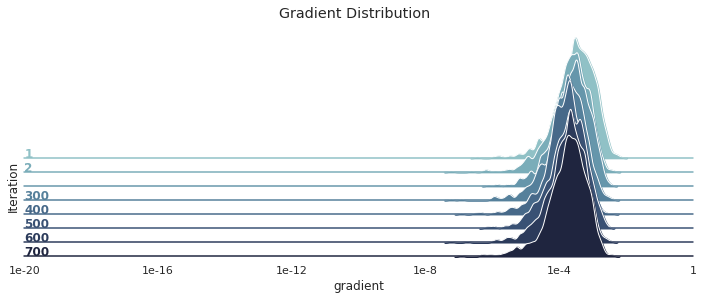

In [ ]:
iteration_idx = [1, 2, 3, 300, 400, 500, 600, 700]
module_idx = [21]
sample_n = 1000
filter_iteration_labels = [1, 2, 300, 400, 500, 600, 700]

grad_df = gradient_distribution(report, iteration_idx, module_idx, sample_n, filter_iteration_labels)

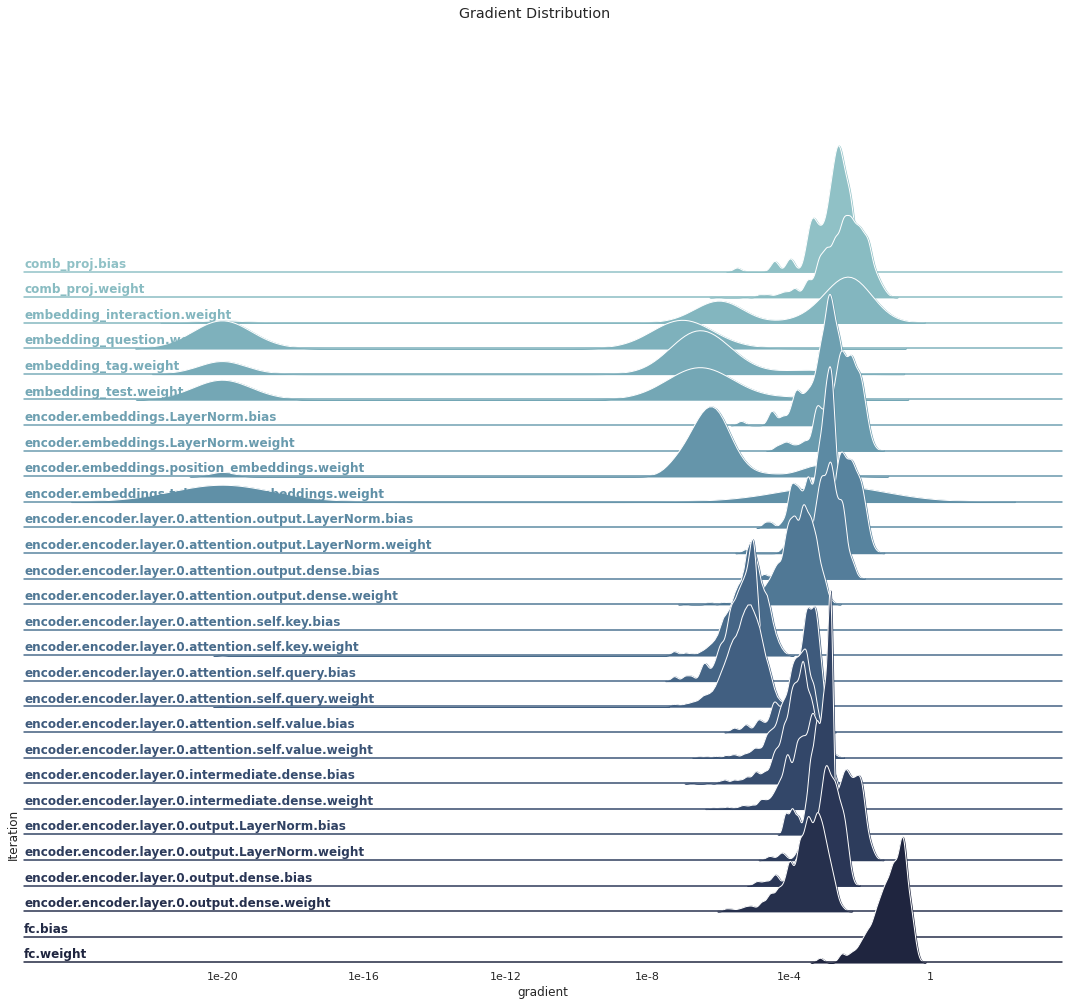

In [ ]:
# 1번째 iteration만 분석
grad_df = gradient_distribution(report, iteration_idx=1, sample_n=1000, one_iteration_only=True)

##### 샘플링 없이

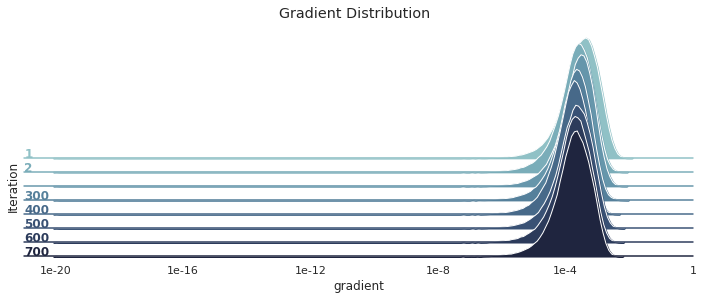

In [ ]:
iteration_idx = [1, 2, 3, 300, 400, 500, 600, 700]
module_idx = [21]
sample_n = None
filter_iteration_labels = [1, 2, 300, 400, 500, 600, 700]

grad_df = gradient_distribution(report, iteration_idx, module_idx, sample_n, filter_iteration_labels)

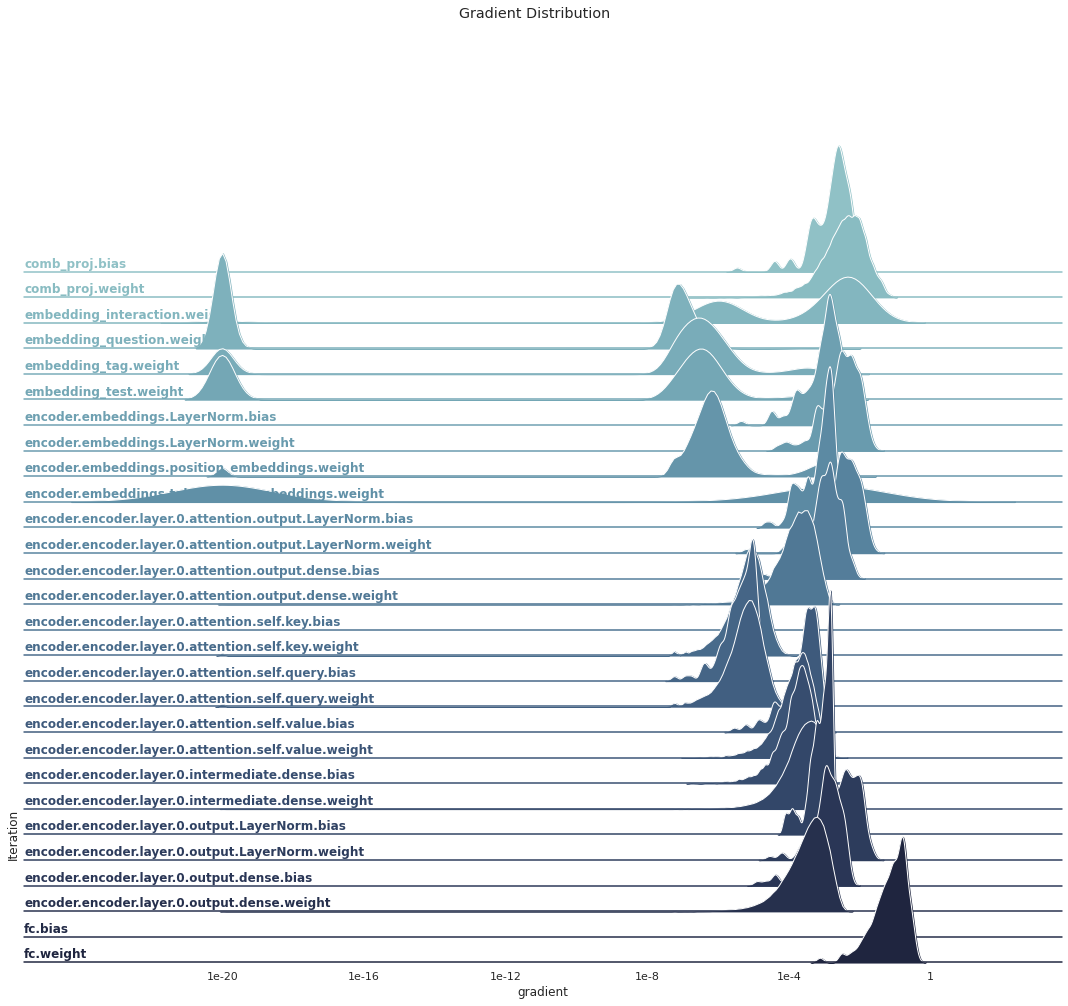

In [ ]:
# 1번째 iteration만 분석
grad_df = gradient_distribution(report, iteration_idx=1, one_iteration_only=True)

#### 🥚 특정 Module의 Gradient 분포
> 특정 module의 gradient 분포를 체크함으로서 gradient가 중간에 소멸하거나 증폭하는 등의 문제 없이 올바르게 전파되고 있는지 체크해볼 수 있다

combination projection의 Gradient 분포 변화

In [ ]:
report['gradient']['name'][0]

'embedding_interaction.weight'

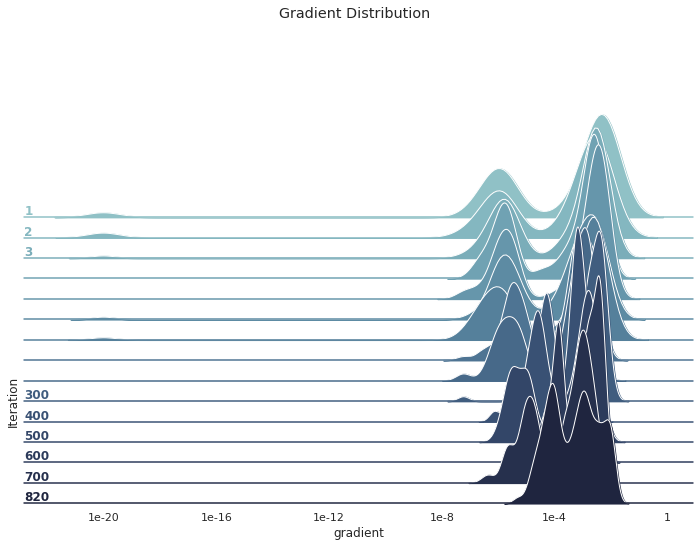

In [ ]:
iteration_idx = [i for i in range(10)] + [300, 400, 500, 600, 700, 820]
module_idx = [1]
sample_n = 1000
filter_iteration_labels = [1, 2, 3, 300, 400, 500, 600, 700, 820]

grad_df = gradient_distribution(report, iteration_idx, module_idx, sample_n, filter_iteration_labels)

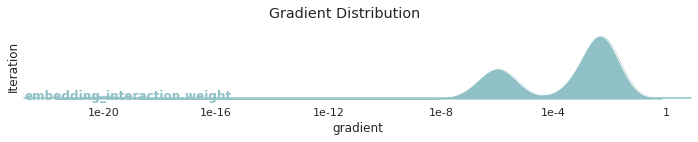

In [ ]:
# 1번째 iteration만 분석
grad_df = gradient_distribution(report, iteration_idx=1, module_idx=[1], sample_n=1000, one_iteration_only=True)

Encoder attention output의 Gradient 분포 변화

In [ ]:
report['gradient']['name'][17:21]

['encoder.encoder.layer.0.attention.output.dense.weight',
 'encoder.encoder.layer.0.attention.output.dense.bias',
 'encoder.encoder.layer.0.attention.output.LayerNorm.weight',
 'encoder.encoder.layer.0.attention.output.LayerNorm.bias']

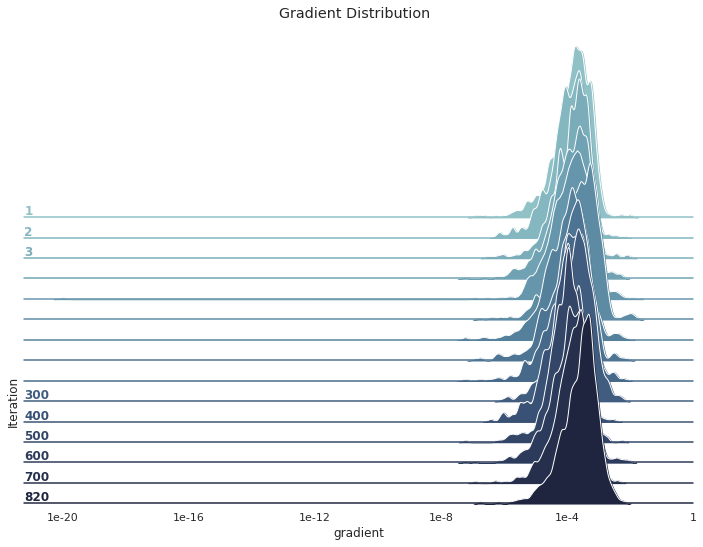

In [ ]:
iteration_idx = [i for i in range(10)] + [300, 400, 500, 600, 700, 820]
module_idx = [18, 19, 20, 21]
sample_n = 1000
filter_iteration_labels = [1, 2, 3, 300, 400, 500, 600, 700, 820]

grad_df = gradient_distribution(report, iteration_idx, module_idx, sample_n, filter_iteration_labels)

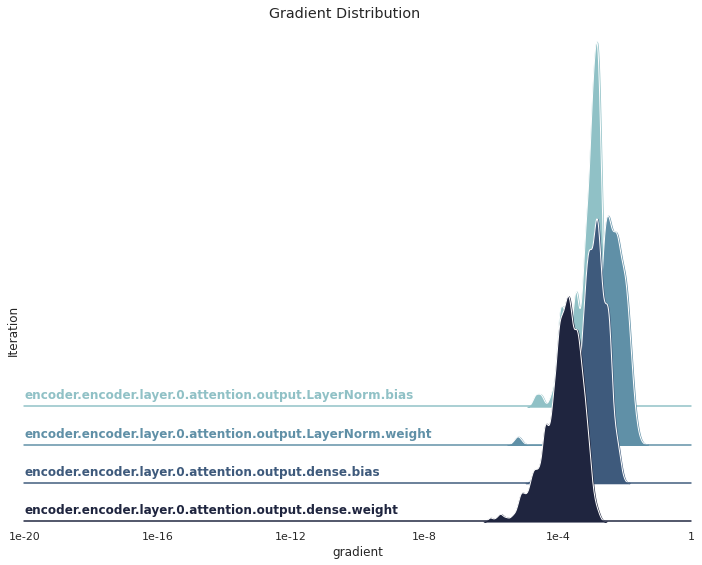

In [ ]:
# 1번째 iteration만 분석
grad_df = gradient_distribution(report, iteration_idx=1, module_idx=[18, 19, 20, 21], sample_n=1000, one_iteration_only=True)

#### 🥚 전체 Gradient 분포
> 전체적인 gradient 분포의 변화 추이를 살펴보며 학습이 원활하게 진행되는지 체크해볼 수 있다

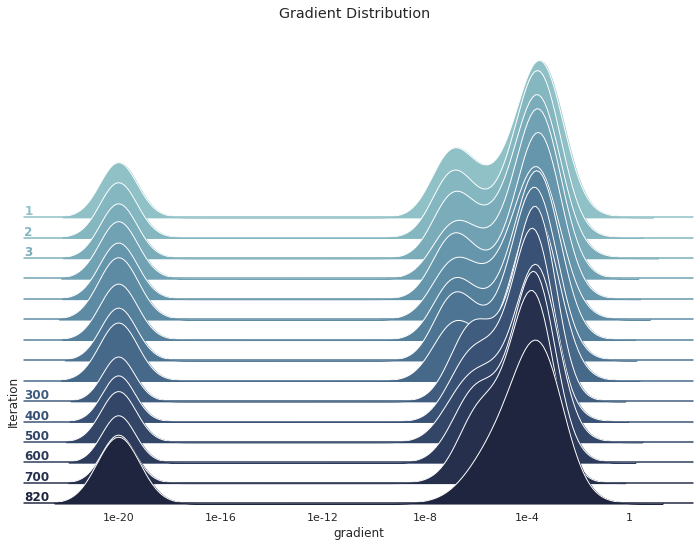

In [ ]:
iteration_idx = [i for i in range(10)] + [300, 400, 500, 600, 700, 820]
module_idx = []
sample_n = 1000
filter_iteration_labels = [0, 1, 2, 3, 300, 400, 500, 600, 700, 820]

gradient_distribution(report, iteration_idx, module_idx, sample_n, filter_iteration_labels)

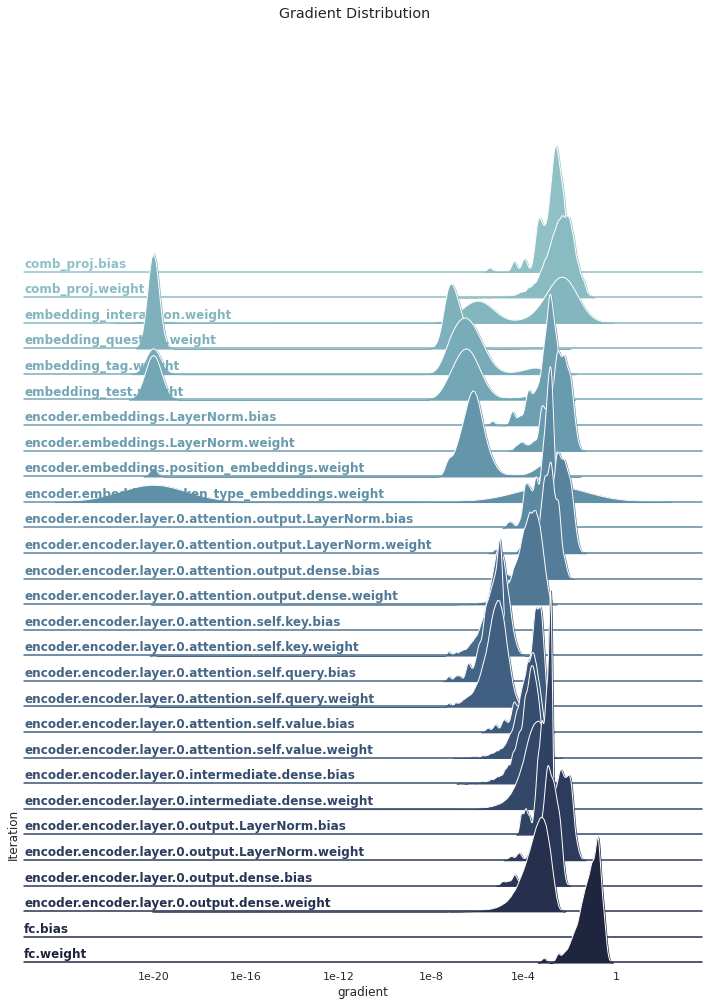

In [ ]:
# 1번째 iteration만 분석
grad_df = gradient_distribution(report, iteration_idx=1, one_iteration_only=True)

## 🐤 hyperopt
> `hyperopt`는 **베이지안 최적화(Bayesian Optimization)**를 사용하며 Grid 탐색이나 Random 탐색의 경우 다른 라이브러리를 이용하자!

- 탐색 공간 (Search Space)
- 탐색 (Search)
- 활용해보기

**유용한 자료**
- [Part 2: Hyperopt. - Towards Data Science](https://towardsdatascience.com/hyperparameter-optimization-in-python-part-2-hyperopt-5f661db91324)

**참고자료**
- [HyperOpt: Hyperparameter Tuning based on Bayesian Optimization - Towards Data Science](https://towardsdatascience.com/hyperopt-hyperparameter-tuning-based-on-bayesian-optimization-7fa32dffaf29)

### 🐣 탐색 공간 (Search Space)
> 하이퍼파라메타 탐색 공간을 지정할 수 있다. 분포를 지정하여서 그 공간안에서 샘플링할 수도 있고 혹은 자신이 직접 값을 지정하여 그 값이 순차적으로 탐색되도록 할 수도 있다.

- 확률 분포
- `q` 확률 분포
- choice
- space 여러개 동시에 사용하기

In [ ]:
from hyperopt import pyll, hp

# 탐색 공간 지정
space = hp.randint('randint', 5)

In [ ]:
# 랜덤으로 지정한 space에서 샘플링
pyll.stochastic.sample(space)

array(2)

#### 🥚 확률 분포

- uniform
- loguniform
- normal
- lognormal

In [ ]:
# 출처 : https://medium.com/vooban-ai/hyperopt-tutorial-for-optimizing-neural-networks-hyperparameters-e3102814b919

import matplotlib.pyplot as plt
from scipy.stats.kde import gaussian_kde

from hyperopt import pyll, hp

hyperparam_generators = {
    'uniform': hp.uniform('uniform', -1, 3),
    'loguniform': hp.loguniform('loguniform', -0.3, 0.3),
    'normal': hp.normal('normal', 1, 2),
    'lognormal': hp.lognormal('lognormal', 0, 0.3)
}

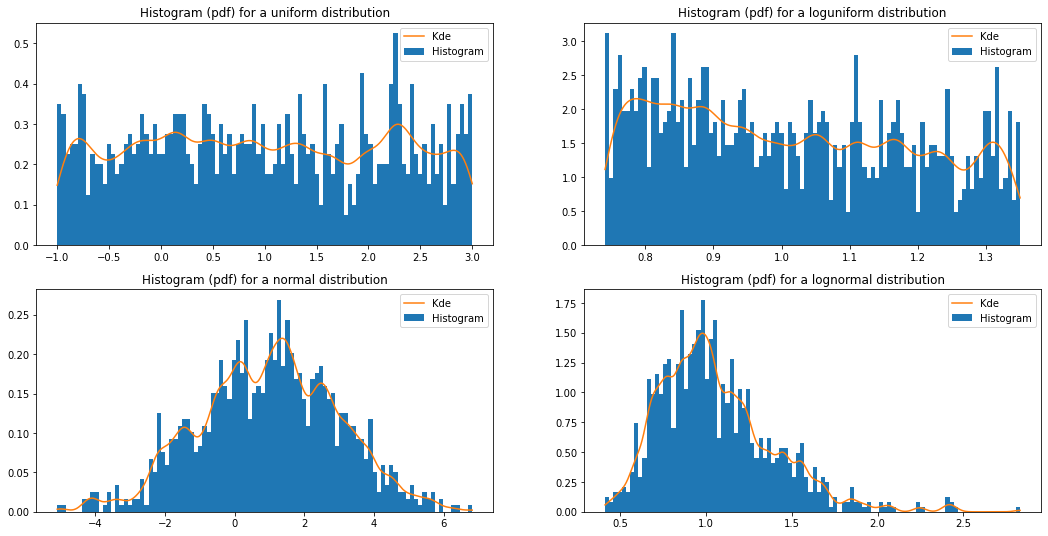

In [ ]:
n_samples = 1000

plt.figure(figsize=(18,9))

for i, (title, space) in enumerate(hyperparam_generators.items()):
    # 지정한 space(분포)를 바탕으로 샘플링
    samples = [pyll.stochastic.sample(space) for _ in range(n_samples)]

    plt.subplot(2, 2, i + 1)
    plt.hist(samples, density=True, bins=100, label="Histogram")

    kde = gaussian_kde(samples, 0.1)
    xticks = np.linspace(min(samples), max(samples), n_samples)
    plt.plot(xticks, kde(xticks), label="Kde")

    plt.title("Histogram (pdf) for a {} distribution".format(title))
    plt.legend()

plt.show()

#### 🥚 `q` 확률 분포
> 위의 확률 분포 샘플링을 하지만 smoothing을 해준다. `quniform`의 경우 `uniform`이후에 q로 나눈후 rounding을 한후 q로 곱하는 과정을 거친다. q가 클수록 값의 다양성은 줄어들고 q가 작을수록 값의 다양성은 늘어난다. 모든 q 확률 분포는 아래와 같은 과정을 거친다.
```python
round(uniform(low, high) / q) * q
```

- quniform
- qloguniform
- qnormal
- qlognormal


`q`가 클 경우

In [ ]:
q = 1.5

hyperparam_generators = {
    'quniform': hp.quniform('quniform', -1, 3, q),
    'qloguniform': hp.qloguniform('qloguniform', -0.3, 0.3, q),
    'qnormal': hp.qnormal('qnormal', 1, 2, q),
    'qlognormal': hp.qlognormal('qlognormal', 0, 0.3, q)
}

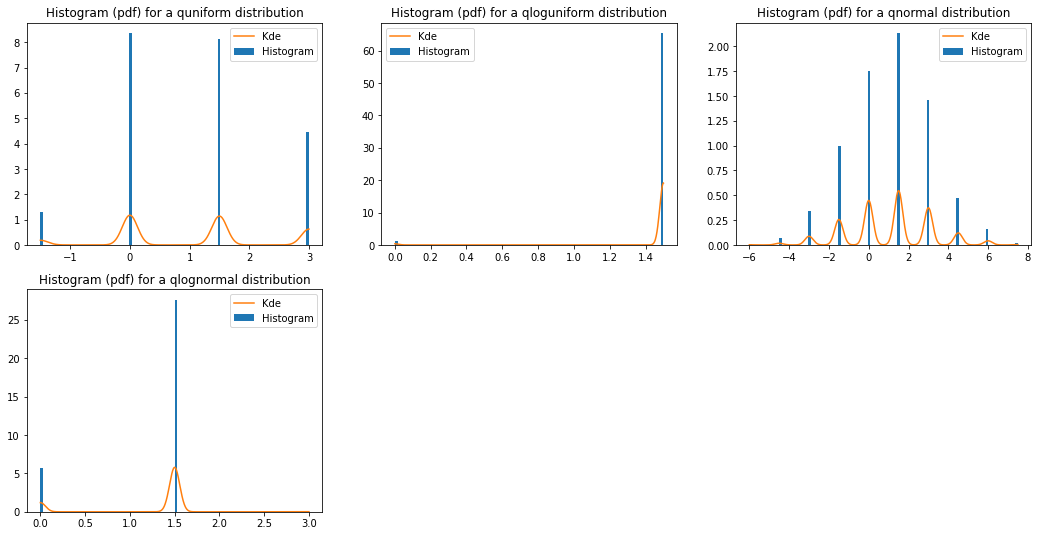

In [ ]:
n_samples = 1000

plt.figure(figsize=(18,9))

for i, (title, space) in enumerate(hyperparam_generators.items()):
    # 지정한 space(분포)를 바탕으로 샘플링
    samples = [pyll.stochastic.sample(space) for _ in range(n_samples)]

    plt.subplot(2, 3, i + 1)
    plt.hist(samples, density=True, bins=100, label="Histogram")

    kde = gaussian_kde(samples, 0.1)
    xticks = np.linspace(min(samples), max(samples), n_samples)
    plt.plot(xticks, kde(xticks), label="Kde")

    plt.title("Histogram (pdf) for a {} distribution".format(title))
    plt.legend()

plt.show()

`q`가 작을 경우

In [ ]:
q = 0.3

hyperparam_generators = {
    'quniform': hp.quniform('quniform', -1, 3, q),
    'qloguniform': hp.qloguniform('qloguniform', -0.3, 0.3, q),
    'qnormal': hp.qnormal('qnormal', 1, 2, q),
    'qlognormal': hp.qlognormal('qlognormal', 0, 0.3, q)
}

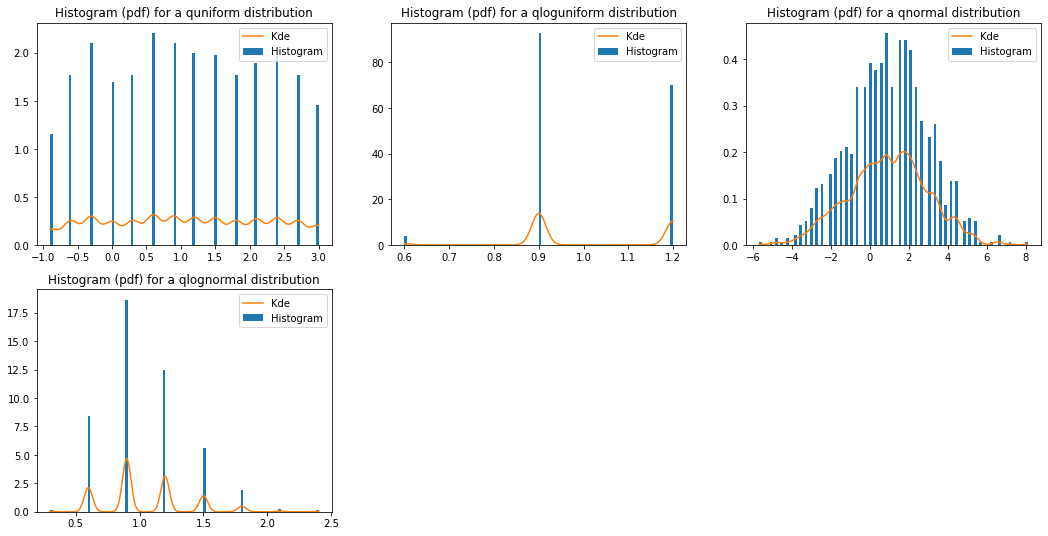

In [ ]:
n_samples = 1000

plt.figure(figsize=(18,9))

for i, (title, space) in enumerate(hyperparam_generators.items()):
    # 지정한 space(분포)를 바탕으로 샘플링
    samples = [pyll.stochastic.sample(space) for _ in range(n_samples)]

    plt.subplot(2, 3, i + 1)
    plt.hist(samples, density=True, bins=100, label="Histogram")

    kde = gaussian_kde(samples, 0.1)
    xticks = np.linspace(min(samples), max(samples), n_samples)
    plt.plot(xticks, kde(xticks), label="Kde")

    plt.title("Histogram (pdf) for a {} distribution".format(title))
    plt.legend()

plt.show()

#### 🥚 choice
> 텍스트를 탐색 공간에 포함시킬 수도 있으며 여러개의 탐색 공간들을 중첩(nested)하여 사용할 수도 있다

- 텍스트 (Text)
- 중첩 (Nested)

##### 텍스트 (Text)

In [ ]:
# 텍스트로 직접 지정!
space = hp.choice('setting_1', ['SVM', 'Regression', 'Random Forest'])

In [ ]:
pyll.stochastic.sample(space)

'Random Forest'

##### 중첩 (Nested)
> 안쪽에 중첩(nested)된 탐색 공간들도 전부 sampling되어 최종 출력된다

In [ ]:
# 출처 : https://github.com/hyperopt/hyperopt/wiki/FMin

space = hp.choice('classifier_type', [
    {
        'type': 'naive_bayes',
    },
    {
        'type': 'svm',
        'C': hp.lognormal('svm_C', 0, 1),
        'kernel': hp.choice('svm_kernel', [
            {'ktype': 'linear'},
            {'ktype': 'RBF', 'width': hp.lognormal('svm_rbf_width', 0, 1)},
            ]),
    },
    {
        'type': 'dtree',
        'criterion': hp.choice('dtree_criterion', ['gini', 'entropy']),
        'max_depth': hp.choice('dtree_max_depth',
            [None, hp.qlognormal('dtree_max_depth_int', 3, 1, 1)]),
        'min_samples_split': hp.qlognormal('dtree_min_samples_split', 2, 1, 1),
    },
    ])

In [ ]:
pyll.stochastic.sample(space)

{'criterion': 'entropy',
 'max_depth': None,
 'min_samples_split': 9.0,
 'type': 'dtree'}

#### 🥚 space 여러개 동시에 사용하기
> 우리는 위에서 space를 하나씩만 지정해서 사용하였다. `choice`의 경우 중첩하여 사용할 수 있지만 그 자체로 하나의 space다. 우리는 여기서 여러개의 space를 동시에 사용하는 방법을 살펴보자

In [ ]:
space = {
    'lr': hp.uniform('lr', 0.00001, 0.001),
    'batch_size': hp.choice('batch_size', [4, 8, 16, 32, 64, 128, 256, 512]),
    'n_layers': hp.randint('n_layers', 5),
}

In [ ]:
pyll.stochastic.sample(space)

{'batch_size': 128, 'lr': 0.000896687802837273, 'n_layers': array(3)}

### 🐣 탐색 (Search)
> 지정된 탐색 공간(search space)안에서 최적의 하이퍼파라메터를 베이지안 최적화(Bayesian Optimization) 방법으로 찾아나간다.

- trials_to_df
- TPE (Tree-structured Parzen Estimator)
- Simulated Anneal

![hyperopt](https://miro.medium.com/max/1000/1*ztfyT1QatezmRHx4Zjeq5g.jpeg)

이미지 출처
- https://towardsdatascience.com/hyperopt-hyperparameter-tuning-based-on-bayesian-optimization-7fa32dffaf29

#### 🥚 trials_to_df
> `hyperopt`는 결과를 친절하게 돌려주지 않는다. Trials를 통해서 얻은 결과를 알아보기 쉽도록 pandas DataFrame으로 바꿔주는 함수다.

In [ ]:
import hyperopt

def trials_to_df(trials, space, best):
    # 전체 결과
    rows = []
    keys = list(trials.trials[0]['misc']['vals'].keys())

    # 전체 실험결과 저장
    for trial in trials:
        row = {}

        # tid
        tid = trial['tid']
        row['experiment'] = str(tid)
        
        # hyperparameter 값 저장
        vals = trial['misc']['vals']
        hparam = {key: value[0] for key, value in vals.items()}

        # space가 1개 - 값을 바로 반환
        # space가 다수 - dict에 값을 반환
        hparam = hyperopt.space_eval(space, hparam)

        if len(keys) == 1:
            row[keys[0]] = hparam
        else:
            for key in keys:
                row[key] = hparam[key]

        # metric
        row['metric'] = abs(trial['result']['loss'])
        
        # 소요 시간
        row['time'] = (trial['refresh_time'] - trial['book_time']).total_seconds() 
        
        rows.append(row)

    experiment_df = pd.DataFrame(rows)
    
    # best 실험
    row = {}
    best_hparam = hyperopt.space_eval(space, best)

    if len(keys) == 1:
        row[keys[0]] = best_hparam
    else:
        for key in keys:
            row[key] = best_hparam[key]
    row['experiment'] = 'best'

    best_df = pd.DataFrame([row])

    # best 결과의 auc / time searching 하여 찾기
    search_df = pd.merge(best_df, experiment_df, on=keys)
    
    # column명 변경
    search_df = search_df.drop(columns=['experiment_y'])
    search_df = search_df.rename(columns={'experiment_x': 'experiment'})

    # 가장 좋은 metric 결과 중 가장 짧은 시간을 가진 결과를 가져옴 
    best_time = search_df.time.min()
    search_df = search_df.query("time == @best_time")

    df = pd.concat([experiment_df, search_df], axis=0)

    return df

#### 🥚 TPE (Tree-structured Parzen Estimator)

100%|██████████| 10/10 [00:00<00:00, 730.83it/s, best loss: 0.6969439168388902]


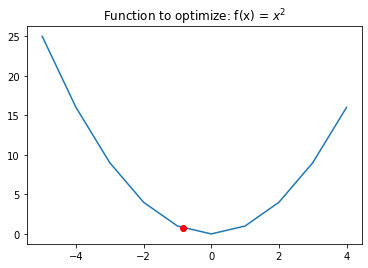


Found minimum after 10 trials : -0.8348316697627673


In [ ]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import matplotlib.pyplot as plt

# 최적화 할 함수
def objective_function(x):
    return x**2

# 탐색 공간
space = hp.uniform('x', -5, 5)

# 최적화
trials = Trials()
best = fmin(
            fn=objective_function,  # 최적화 할 함수
            space=space,            # Hyperparameter 탐색 공간
            algo=tpe.suggest,       # Tree-structured Parzen Estimator (TPE)
            max_evals=10,           # 10번 시도
            trials=trials
            )

best_x = best['x']

	
plt.plot(range(-5, 5), [objective_function(x) for x in range(-5, 5)])
plt.title("Function to optimize: f(x) = $x^2$")
plt.plot(best_x, objective_function(best_x), 'ro') 
plt.show()

print(f"\nFound minimum after 10 trials : {best_x}")

In [ ]:
df = trials_to_df(trials, space, best)
df

experiment         x     metric   time
0          0  4.878354  23.798336  0.000
1          1  4.179840  17.471061  0.000
2          2  3.741754  14.000726  0.000
3          3 -0.834832   0.696944  0.000
4          4 -1.806171   3.262253  0.000
5          5  3.831007  14.676614  0.000
6          6  1.279023   1.635900  0.000
7          7 -4.560784  20.800748  0.000
8          8  3.790611  14.368735  0.001
9          9  3.719221  13.832607  0.000
0       best -0.834832   0.696944  0.000

#### 🥚 Simulated Anneal

100%|██████████| 10/10 [00:00<00:00, 878.19it/s, best loss: 0.16979120587729793]


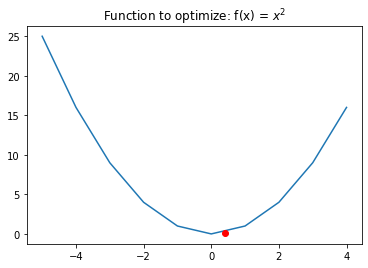


Found minimum after 10 trials : 0.41205728470359304


In [ ]:
from hyperopt import fmin, anneal, hp, STATUS_OK, Trials
import matplotlib.pyplot as plt

# 최적화 할 함수
def objective_function(x):
    return x**2

# 탐색 공간
space = hp.uniform('x', -5, 5)

# 최적화
trials = Trials()
best = fmin(
            fn=objective_function,  # 최적화 할 함수
            space=space,            # Hyperparameter 탐색 공간
            algo=anneal.suggest,       # Simulated Anneal
            max_evals=10,           # 10번 시도
            trials=trials
            )

best_x = best['x']

	
plt.plot(range(-5, 5), [objective_function(x) for x in range(-5, 5)])
plt.title("Function to optimize: f(x) = $x^2$")
plt.plot(best_x, objective_function(best_x), 'ro') 
plt.show()

print(f"\nFound minimum after 10 trials : {best_x}")

In [ ]:
df = trials_to_df(trials, space, best)
df

experiment         x     metric   time
0          0  3.695787  13.658841  0.000
1          1  1.884368   3.550843  0.000
2          2  2.834185   8.032606  0.000
3          3 -1.188869   1.413410  0.000
4          4  0.412057   0.169791  0.000
5          5  2.331519   5.435983  0.000
6          6  2.429635   5.903128  0.000
7          7 -2.087556   4.357891  0.001
8          8  0.470917   0.221763  0.000
9          9 -0.925740   0.856994  0.000
0       best  0.412057   0.169791  0.000

### 🐣 활용해보기
> 위에서 간단한 예제를 보았으니 이제 우리 모델에 직접 활용해보자!

In [ ]:
# 시간이 너무 오래걸리니 n_epoch를 낮추자
args.n_epochs = 3

In [ ]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import matplotlib.pyplot as plt

# 최적화 할 함수
def objective_function(space):
    """
    space 예시 {'batch_size': 64, 'lr': 0.00010810929882981193, 'n_layers': 1}
    """

    # args가 dict으로 건네지기 때문에 easydict으로 바꿔준다
    args = space['args']
    args = easydict.EasyDict(args)
    
    # 하이퍼파라메타 값 변경
    args.batch_size = space['batch_size']
    args.lr = space['lr']
    args.n_layers = space['n_layers']

    # seed 설정 
    seed_everything(args.seed)

    report = run(args, train_data, valid_data)

    best_auc = report['best_auc']

    return -best_auc

# 탐색 공간
space = {
    'lr': hp.uniform('lr', 0.00001, 0.001),
    'batch_size': hp.choice('batch_size', [16, 32, 64]),
    'n_layers': hp.choice('n_layers', [1, 2, 3]),
    'args': args
}

# 최적화
# 하나당 3 epoch를 돌리기 때문에 최대한 숫자를 줄이기위해 5번만 시도

trials = Trials()
best = fmin(
            fn=objective_function,  # 최적화 할 함수
            space=space,            # Hyperparameter 탐색 공간
            algo=tpe.suggest,       # Tree-structured Parzen Estimator (TPE)
            max_evals=5,           # 5번 시도
            trials=trials
            )

# 하이퍼파라메타 원상복구
args.n_epochs = 10
args.lr = 0.0001
args.batch_size = 64
args.n_layers = 1


  0%|          | 0/5 [00:00<?, ?it/s, best loss: ?]


 20%|██        | 1/5 [00:13<00:55, 13.78s/it, best loss: -0.7115155818083172]


 40%|████      | 2/5 [00:30<00:43, 14.62s/it, best loss: -0.7115155818083172]


 60%|██████    | 3/5 [00:46<00:30, 15.21s/it, best loss: -0.7116395472203574]


 80%|████████  | 4/5 [01:07<00:16, 16.95s/it, best loss: -0.7116395472203574]


100%|██████████| 5/5 [01:29<00:00, 17.81s/it, best loss: -0.7116395472203574]


In [ ]:
df = trials_to_df(trials, space, best)
df

experiment  batch_size        lr  n_layers    metric    time
0          0          32  0.000888         1  0.711516  13.780
1          1          16  0.000867         1  0.710892  16.565
2          2          16  0.000580         1  0.711640  16.570
3          3          64  0.000881         2  0.710532  21.004
4          4          64  0.000833         2  0.710449  21.072
0       best          16  0.000580         1  0.711640  16.570

## 🐤 ray
> 그리드 탐색(Grid Search)에 사용할 것이다

- 그리드 탐색(Grid Search)
- 활용해보기

**유용한 자료**
- [Ray Tune: a Python library for fast hyperparameter tuning at any scale - Towards Data Science](https://towardsdatascience.com/fast-hyperparameter-tuning-at-scale-d428223b081c)

**참고자료**
- [ray tune](https://docs.ray.io/en/latest/tune/index.html)

![ray tune](https://miro.medium.com/max/700/0*mxyRF_di4Bt7BX9-)

이미지 출처
- https://towardsdatascience.com/fast-hyperparameter-tuning-at-scale-d428223b081c

### 🐣 그리드 탐색(Grid Search)

In [ ]:
# 출처 : https://docs.ray.io/en/latest/tune/index.html

from ray import tune

def objective_function(step, alpha, beta):
    return (0.1 + alpha * step / 100)**(-1) + beta * 0.1

def training_function(config):
    
    # Hyperparameters
    alpha, beta = config["alpha"], config["beta"]

    for step in range(10):
        # Iterative training function - can be any arbitrary training procedure.
        intermediate_score = objective_function(step, alpha, beta)
        
        # Feed the score back back to Tune.
        tune.report(mean_loss=intermediate_score)

analysis = tune.run(training_function,
                    config={"alpha": tune.grid_search([0.001, 0.01, 0.1]),
                            "beta": tune.grid_search([1, 2, 3])},
                    verbose=2)

print("Best config: ", analysis.get_best_config(metric="mean_loss", mode="min"))

2021-04-13 10:11:27,477	WARNING tune.py:411 -- Tune detects GPUs, but no trials are using GPUs. To enable trials to use GPUs, set tune.run(resources_per_trial={'gpu': 1}...) which allows Tune to expose 1 GPU to each trial. You can also override `Trainable.default_resource_request` if using the Trainable API.


Trial training_function_9c0b5_00000 reported mean_loss=10.1,neg_mean_loss=-10.1 with parameters={'alpha': 0.001, 'beta': 1}.
Trial training_function_9c0b5_00000 reported mean_loss=10.091008092716553,neg_mean_loss=-10.091008092716553 with parameters={'alpha': 0.001, 'beta': 1}. This trial completed.
Trial training_function_9c0b5_00001 reported mean_loss=10.1,neg_mean_loss=-10.1 with parameters={'alpha': 0.01, 'beta': 1}.
Trial training_function_9c0b5_00001 reported mean_loss=10.010802775024777,neg_mean_loss=-10.010802775024777 with parameters={'alpha': 0.01, 'beta': 1}. This trial completed.
Trial training_function_9c0b5_00002 reported mean_loss=10.1,neg_mean_loss=-10.1 with parameters={'alpha': 0.1, 'beta': 1}.
Trial training_function_9c0b5_00002 reported mean_loss=9.274311926605503,neg_mean_loss=-9.274311926605503 with parameters={'alpha': 0.1, 'beta': 1}. This trial completed.
Trial training_function_9c0b5_00003 reported mean_loss=10.2,neg_mean_loss=-10.2 with parameters={'alpha': 0.

Trial training_function_9c0b5_00006 reported mean_loss=10.291008092716554,neg_mean_loss=-10.291008092716554 with parameters={'alpha': 0.001, 'beta': 3}. This trial completed.
Trial training_function_9c0b5_00007 reported mean_loss=10.3,neg_mean_loss=-10.3 with parameters={'alpha': 0.01, 'beta': 3}.
Trial training_function_9c0b5_00007 reported mean_loss=10.210802775024778,neg_mean_loss=-10.210802775024778 with parameters={'alpha': 0.01, 'beta': 3}. This trial completed.
Trial training_function_9c0b5_00008 reported mean_loss=10.3,neg_mean_loss=-10.3 with parameters={'alpha': 0.1, 'beta': 3}.
Trial training_function_9c0b5_00008 reported mean_loss=9.474311926605504,neg_mean_loss=-9.474311926605504 with parameters={'alpha': 0.1, 'beta': 3}. This trial completed.


2021-04-13 10:11:34,094	INFO tune.py:450 -- Total run time: 6.63 seconds (6.57 seconds for the tuning loop).


Best config:  {'alpha': 0.1, 'beta': 1}


In [ ]:
analysis.results_df[['experiment_tag', 'time_total_s', 'mean_loss']]

experiment_tag  time_total_s  mean_loss
trial_id                                                  
43741_00000  0_alpha=0.001,beta=1      0.071240  10.091008
43741_00001   1_alpha=0.01,beta=1      0.062245  10.010803
43741_00002    2_alpha=0.1,beta=1      0.064989   9.274312
43741_00003  3_alpha=0.001,beta=2      0.065859  10.191008
43741_00004   4_alpha=0.01,beta=2      0.060248  10.110803
43741_00005    5_alpha=0.1,beta=2      0.047915   9.374312
43741_00006  6_alpha=0.001,beta=3      0.066850  10.291008
43741_00007   7_alpha=0.01,beta=3      0.061887  10.210803
43741_00008    8_alpha=0.1,beta=3      0.045230   9.474312

### 🐣 활용해보기
> 위에서 간단한 예제를 보았으니 이제 우리 모델에 직접 활용해보자!

`ray`는 gpu수를 명시해줘야 한다
```python
gpus_per_trial = 1
analysis = tune.run(training_function,
                    config={"lr": tune.grid_search([0.1, 0.01, 0.001]),
                            "n_layers": tune.grid_search([1, 2, 3]),
                            "args": args},

                    # TODO : gpu 할당 갯수 명시
                    resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
                    verbose=2)
```

In [ ]:
from ray import tune

def objective_function(config):
    """
    config 예시 {'lr': 0.0001, 'n_layers': 1}
    """

    # args가 dict으로 건네지기 때문에 easydict으로 바꿔준다
    args = config['args']

    # 하이퍼파라메타 값 변경
    args.lr = config['lr']
    args.n_layers = config['n_layers']

    # seed 설정 - pickle serialize 불가로 사용 중지
    # seed_everything(args.seed)

    report = run(args, train_data, valid_data, gradient=False)

    best_auc = report['best_auc']

    return best_auc

def training_function(config):
    # auc 계산
    best_auc = objective_function(config)

    # Feed the score back back to Tune.
    tune.report(auc=best_auc)

gpus_per_trial = 1
analysis = tune.run(training_function,
                    config={"lr": tune.grid_search([0.1, 0.01, 0.001]),
                            "n_layers": tune.grid_search([1, 2, 3]),
                            "args": args},
                    resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
                    verbose=2)

print("Best config: ", analysis.get_best_config(metric="auc", mode="max"))

2021-04-13 10:38:53,106	WARNING worker.py:1107 -- Warning: The actor ImplicitFunc has size 81662528 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2021-04-13 10:38:53,214	WARNING util.py:152 -- The `start_trial` operation took 1.503 s, which may be a performance bottleneck.


(pid=6314) 2021-04-13 10:38:55.444578: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=6314) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_6fab6_00000 reported auc=0.662370943151394 with parameters={'lr': 0.1, 'n_layers': 1, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912, 'total_steps': 243, 'warmup_steps': 24}}.


(pid=6314) 
Trial training_function_6fab6_00000 completed. Last result: auc=0.662370943151394


(pid=6314) Error in atexit._run_exitfuncs:
(pid=6314) Traceback (most recent call last):
(pid=6314)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=6314)     self._writeout_input_cache(conn)
(pid=6314)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=6314)     (self.session_number,)+line)
(pid=6314) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140498873169664 and this is thread id 140505806247808.
2021-04-13 10:39:41,603	WARNING util.py:152 -- The `start_trial` operation took 1.332 s, which may be a performance bottleneck.
(pid=6352) 2021-04-13 10:39:44.254994: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=6352) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_6fab6_00001 reported auc=0.7259760666257743 with parameters={'lr': 0.01, 'n_layers': 1, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912, 'total_steps': 243, 'warmup_steps': 24}}.


Trial training_function_6fab6_00001 completed. Last result: auc=0.7259760666257743
(pid=6352) 


(pid=6352) Error in atexit._run_exitfuncs:
(pid=6352) Traceback (most recent call last):
(pid=6352)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=6352)     self._writeout_input_cache(conn)
(pid=6352)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=6352)     (self.session_number,)+line)
(pid=6352) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140391492208384 and this is thread id 140398425286528.
2021-04-13 10:40:30,349	WARNING util.py:152 -- The `start_trial` operation took 1.269 s, which may be a performance bottleneck.
(pid=6386) 2021-04-13 10:40:32.573643: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=6386) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_6fab6_00002 reported auc=0.7164307298986865 with parameters={'lr': 0.001, 'n_layers': 1, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912, 'total_steps': 243, 'warmup_steps': 24}}.
(pid=6386) 


Trial training_function_6fab6_00002 completed. Last result: auc=0.7164307298986865


(pid=6386) Error in atexit._run_exitfuncs:
(pid=6386) Traceback (most recent call last):
(pid=6386)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=6386)     self._writeout_input_cache(conn)
(pid=6386)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=6386)     (self.session_number,)+line)
(pid=6386) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 139630901798656 and this is thread id 139637834876800.
2021-04-13 10:41:18,402	WARNING util.py:152 -- The `start_trial` operation took 1.373 s, which may be a performance bottleneck.
(pid=6419) 2021-04-13 10:41:20.566028: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=6419) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_6fab6_00003 reported auc=0.5153898229226537 with parameters={'lr': 0.1, 'n_layers': 2, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912, 'total_steps': 243, 'warmup_steps': 24}}.
(pid=6419) 


Trial training_function_6fab6_00003 completed. Last result: auc=0.5153898229226537


(pid=6419) Error in atexit._run_exitfuncs:
(pid=6419) Traceback (most recent call last):
(pid=6419)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=6419)     self._writeout_input_cache(conn)
(pid=6419)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=6419)     (self.session_number,)+line)
(pid=6419) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140449341261568 and this is thread id 140456274339712.
2021-04-13 10:42:36,159	WARNING util.py:152 -- The `start_trial` operation took 1.310 s, which may be a performance bottleneck.
(pid=6458) 2021-04-13 10:42:38.334498: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=6458) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_6fab6_00004 reported auc=0.6856092256025604 with parameters={'lr': 0.01, 'n_layers': 2, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912, 'total_steps': 243, 'warmup_steps': 24}}.


Trial training_function_6fab6_00004 completed. Last result: auc=0.6856092256025604
(pid=6458) 


(pid=6458) Error in atexit._run_exitfuncs:
(pid=6458) Traceback (most recent call last):
(pid=6458)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=6458)     self._writeout_input_cache(conn)
(pid=6458)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=6458)     (self.session_number,)+line)
(pid=6458) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140292693153536 and this is thread id 140299626231680.
2021-04-13 10:43:53,675	WARNING util.py:152 -- The `start_trial` operation took 1.309 s, which may be a performance bottleneck.
(pid=6489) 2021-04-13 10:43:55.872311: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=6489) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_6fab6_00005 reported auc=0.7251936355835471 with parameters={'lr': 0.001, 'n_layers': 2, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912, 'total_steps': 243, 'warmup_steps': 24}}.


Trial training_function_6fab6_00005 completed. Last result: auc=0.7251936355835471
(pid=6489) 


(pid=6489) Error in atexit._run_exitfuncs:
(pid=6489) Traceback (most recent call last):
(pid=6489)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=6489)     self._writeout_input_cache(conn)
(pid=6489)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=6489)     (self.session_number,)+line)
(pid=6489) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140298419095296 and this is thread id 140305352173440.
2021-04-13 10:45:11,642	WARNING util.py:152 -- The `start_trial` operation took 1.225 s, which may be a performance bottleneck.
(pid=6516) 2021-04-13 10:45:13.914706: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=6516) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_6fab6_00006 reported auc=0.518012818345593 with parameters={'lr': 0.1, 'n_layers': 3, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912, 'total_steps': 243, 'warmup_steps': 24}}.


(pid=6516) 
Trial training_function_6fab6_00006 completed. Last result: auc=0.518012818345593


(pid=6516) Error in atexit._run_exitfuncs:
(pid=6516) Traceback (most recent call last):
(pid=6516)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=6516)     self._writeout_input_cache(conn)
(pid=6516)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=6516)     (self.session_number,)+line)
(pid=6516) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140008557340416 and this is thread id 140015490418560.
2021-04-13 10:46:58,825	WARNING util.py:152 -- The `start_trial` operation took 1.339 s, which may be a performance bottleneck.
(pid=6546) 2021-04-13 10:47:01.022106: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=6546) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_6fab6_00007 reported auc=0.7041452745833877 with parameters={'lr': 0.01, 'n_layers': 3, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912, 'total_steps': 243, 'warmup_steps': 24}}.
(pid=6546) 


Trial training_function_6fab6_00007 completed. Last result: auc=0.7041452745833877


(pid=6546) Error in atexit._run_exitfuncs:
(pid=6546) Traceback (most recent call last):
(pid=6546)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=6546)     self._writeout_input_cache(conn)
(pid=6546)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=6546)     (self.session_number,)+line)
(pid=6546) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 139677279045376 and this is thread id 139684212123520.
2021-04-13 10:48:46,173	WARNING util.py:152 -- The `start_trial` operation took 1.346 s, which may be a performance bottleneck.
(pid=6574) 2021-04-13 10:48:47.913144: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=6574) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_6fab6_00008 reported auc=0.7278347428361676 with parameters={'lr': 0.001, 'n_layers': 3, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912, 'total_steps': 243, 'warmup_steps': 24}}.


Trial training_function_6fab6_00008 completed. Last result: auc=0.7278347428361676


2021-04-13 10:50:31,834	INFO tune.py:450 -- Total run time: 702.09 seconds (700.80 seconds for the tuning loop).


(pid=6574) 
Best config:  {'lr': 0.001, 'n_layers': 3, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912, 'total_steps': 243, 'warmup_steps': 24}}


In [ ]:
analysis.results_df[['experiment_tag', 'time_total_s', 'auc']]

experiment_tag  time_total_s       auc
trial_id                                                  
6fab6_00000    0_lr=0.1,n_layers=1     43.326590  0.662371
6fab6_00001   1_lr=0.01,n_layers=1     43.029121  0.725976
6fab6_00002  2_lr=0.001,n_layers=1     42.948149  0.716431
6fab6_00003    3_lr=0.1,n_layers=2     72.793193  0.515390
6fab6_00004   4_lr=0.01,n_layers=2     72.533629  0.685609
6fab6_00005  5_lr=0.001,n_layers=2     72.991503  0.725194
6fab6_00006    6_lr=0.1,n_layers=3    102.070600  0.518013
6fab6_00007   7_lr=0.01,n_layers=3    102.312731  0.704145
6fab6_00008  8_lr=0.001,n_layers=3    102.388311  0.727835

In [ ]:
# 하이퍼파라메타 원상복구
args.n_epochs = 10
args.lr = 0.001
args.batch_size = 64
args.n_layers = 1

# 🎯 Transformer Tuning

- Transformer의 Hyperparameter가 변경되었을 때 모델과 성능에 끼치는 영향들
- Training의 Hyperparamter가 변경되었을 때 모델과 성능에 끼치는 영향들
- 가중치 초기화 (Weight Initialization)
- 데이터 증강 (Data Augmentation)
- optimizer와 scheduler

## 🏹 Transformer의 Hyperparameter가 변경되었을 때 모델과 성능에 끼치는 영향들
> 우리는 transformer의 하이퍼파라메타를 변경해보며 학습시간 plot, 성능변화 plot을 그려 어떤 식으로 변화는지 관찰해볼 것이다! 
- 학습속도에는 어떤 arg가 영향을 많이 미치는지
- 성능에는 어떤 arg가 영향을 많이 미치는지
- 학습 속도와 성능 Trade-off를 어떻게 조절해야 하는지

- layer 수
- heads 수
- embedding dimension
- seq_len
- `hyperopt`으로 hyperparameter들을 동시에 탐색

### 🌿 layer 수
> layer 수가 증가할수록 모델의 복잡도가 크게 증가하고 훈련에 필요한 데이터가 많아지기 때문에 DKT에서는 1개만 사용하는 것이 보편적이다. 우리는 여기서 layer 숫자의 변화에 따라 성능의 변화를 살펴본다.

In [ ]:
from ray import tune

def objective_function(config):
    """
    config 예시 {'lr': 0.0001, 'n_layers': 1}
    """
    # args가 dict으로 건네지기 때문에 easydict으로 바꿔준다
    args = config['args']
    
    # 하이퍼파라메타 값 변경
    args.n_layers = config['n_layers']

    # seed 설정 - pickle serialize 불가로 사용 중지
    # seed_everything(args.seed)

    report = run(args, train_data, valid_data, gradient=False)

    best_auc = report['best_auc']

    return best_auc

def training_function(config):
    # auc 계산
    best_auc = objective_function(config)

    # Feed the score back back to Tune.
    tune.report(auc=best_auc)

gpus_per_trial = 1
analysis = tune.run(training_function,
                    config={"n_layers": tune.grid_search([1, 2, 3, 4, 5]),
                            "args": args},
                    resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
                    verbose=2)

print("Best config: ", analysis.get_best_config(metric="auc", mode="max"))

# 값 원상복구
args.n_layers = 1

2021-04-14 04:59:18,127	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265
2021-04-14 04:59:21,005	WARNING function_runner.py:541 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2021-04-14 04:59:24,389	WARNING worker.py:1107 -- Warning: The actor ImplicitFunc has size 81662632 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


(pid=424) 2021-04-14 04:59:26.495105: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=424) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_2d5b5_00000 reported auc=0.7144094497062663 with parameters={'n_layers': 1, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.


Trial training_function_2d5b5_00000 completed. Last result: auc=0.7144094497062663
(pid=424) 


(pid=424) Error in atexit._run_exitfuncs:
(pid=424) Traceback (most recent call last):
(pid=424)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=424)     self._writeout_input_cache(conn)
(pid=424)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=424)     (self.session_number,)+line)
(pid=424) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140292710098688 and this is thread id 140299652351872.
2021-04-14 05:00:36,852	WARNING util.py:152 -- The `start_trial` operation took 1.186 s, which may be a performance bottleneck.
(pid=423) 2021-04-14 05:00:38.964394: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=423) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_2d5b5_00001 reported auc=0.7169201517851824 with parameters={'n_layers': 2, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.


Trial training_function_2d5b5_00001 completed. Last result: auc=0.7169201517851824
(pid=423) 


(pid=423) Error in atexit._run_exitfuncs:
(pid=423) Traceback (most recent call last):
(pid=423)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=423)     self._writeout_input_cache(conn)
(pid=423)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=423)     (self.session_number,)+line)
(pid=423) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140079291422464 and this is thread id 140086233675648.
2021-04-14 05:02:38,156	WARNING util.py:152 -- The `start_trial` operation took 1.277 s, which may be a performance bottleneck.
(pid=534) 2021-04-14 05:02:40.618670: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=534) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_2d5b5_00002 reported auc=0.7154768402021442 with parameters={'n_layers': 3, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.
(pid=534) 


Trial training_function_2d5b5_00002 completed. Last result: auc=0.7154768402021442


(pid=534) Error in atexit._run_exitfuncs:
(pid=534) Traceback (most recent call last):
(pid=534)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=534)     self._writeout_input_cache(conn)
(pid=534)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=534)     (self.session_number,)+line)
(pid=534) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 139989758523136 and this is thread id 139996700776320.
2021-04-14 05:05:34,147	WARNING util.py:152 -- The `start_trial` operation took 1.191 s, which may be a performance bottleneck.
(pid=598) 2021-04-14 05:05:36.711957: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=598) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_2d5b5_00003 reported auc=0.7111762868656231 with parameters={'n_layers': 4, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.


Trial training_function_2d5b5_00003 completed. Last result: auc=0.7111762868656231
(pid=598) 


(pid=598) Error in atexit._run_exitfuncs:
(pid=598) Traceback (most recent call last):
(pid=598)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=598)     self._writeout_input_cache(conn)
(pid=598)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=598)     (self.session_number,)+line)
(pid=598) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140443226773248 and this is thread id 140450169026432.
2021-04-14 05:09:25,450	WARNING util.py:152 -- The `start_trial` operation took 1.228 s, which may be a performance bottleneck.
(pid=677) 2021-04-14 05:09:27.462848: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=677) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_2d5b5_00004 reported auc=0.722162922750229 with parameters={'n_layers': 5, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.


Trial training_function_2d5b5_00004 completed. Last result: auc=0.722162922750229


2021-04-14 05:14:08,747	INFO tune.py:450 -- Total run time: 891.24 seconds (886.38 seconds for the tuning loop).


(pid=677) 
Best config:  {'n_layers': 5, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}


In [ ]:
layer_df = analysis.results_df[['experiment_tag', 'time_total_s', 'auc']]
layer_df

experiment_tag  time_total_s       auc
trial_id                                          
2d5b5_00000   0_n_layers=1     68.101627  0.714409
2d5b5_00001   1_n_layers=2    116.846665  0.716920
2d5b5_00002   2_n_layers=3    171.258183  0.715477
2d5b5_00003   3_n_layers=4    226.424981  0.711176
2d5b5_00004   4_n_layers=5    280.190769  0.722163

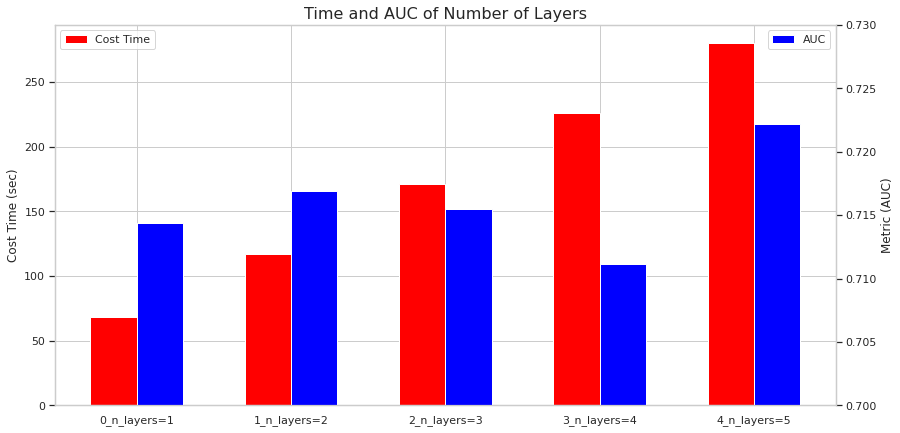

In [ ]:
fig, ax1 = plt.subplots(figsize=(14,7))

ax1.set_title('Time and AUC of Number of Layers', fontsize=16)

# Time
plt.bar(layer_df['experiment_tag'],
        layer_df['time_total_s'],
        color='red',
        width=-0.3, align='edge',
        label='Cost Time')
plt.ylabel('Cost Time (sec)')
ax1.legend()

# AUC
ax2 = ax1.twinx()
plt.bar(layer_df['experiment_tag'],
        layer_df['auc'],
        color='blue',
        width=0.3, align='edge',
        label='AUC')
plt.ylabel('Metric (AUC)')

ax2.grid(False)
ax2.set_ylim(0.7, 0.73)
ax2.legend()

plt.show()

### 🌿 heads 수
> 하나의 sequence에서 attention을 몇 개로 나누어 진행할 것인지 결정한다. SAKT 논문에서의 ablation study에서는 single head가 좋지 않다고 한다. 우리는 여기서 head의 숫자의 변화에 따라 성능의 변화를 살펴본다.

In [ ]:
from ray import tune

def objective_function(config):
    """
    config 예시 {'lr': 0.0001, 'n_layers': 1}
    """
    # args가 dict으로 건네지기 때문에 easydict으로 바꿔준다
    args = config['args']
    
    # 하이퍼파라메타 값 변경
    args.n_heads = config['n_heads']

    # seed 설정 - pickle serialize 불가로 사용 중지
    # seed_everything(args.seed)

    report = run(args, train_data, valid_data, gradient=False)

    best_auc = report['best_auc']

    return best_auc

def training_function(config):
    # auc 계산
    best_auc = objective_function(config)

    # Feed the score back back to Tune.
    tune.report(auc=best_auc)

gpus_per_trial = 1
analysis = tune.run(training_function,
                    config={"n_heads": tune.grid_search([1, 2, 4, 8, 16, 32, 64]),
                            "args": args},
                    resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
                    verbose=2)

print("Best config: ", analysis.get_best_config(metric="auc", mode="max"))

# 값 원상복구
args.n_heads = 4

2021-04-14 07:13:59,418	WARNING worker.py:1107 -- Warning: The actor ImplicitFunc has size 81662711 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2021-04-14 07:13:59,520	WARNING util.py:152 -- The `start_trial` operation took 1.655 s, which may be a performance bottleneck.


(pid=2272) 2021-04-14 07:14:01.962576: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=2272) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_fa659_00000 reported auc=0.7204418964454127 with parameters={'n_heads': 1, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.


Trial training_function_fa659_00000 completed. Last result: auc=0.7204418964454127
(pid=2272) 


(pid=2272) Error in atexit._run_exitfuncs:
(pid=2272) Traceback (most recent call last):
(pid=2272)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=2272)     self._writeout_input_cache(conn)
(pid=2272)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=2272)     (self.session_number,)+line)
(pid=2272) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140053032826624 and this is thread id 140059975079808.
2021-04-14 07:14:54,652	WARNING util.py:152 -- The `start_trial` operation took 1.161 s, which may be a performance bottleneck.
(pid=2309) 2021-04-14 07:14:57.042177: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=2309) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_fa659_00001 reported auc=0.7202116749659097 with parameters={'n_heads': 2, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.


Trial training_function_fa659_00001 completed. Last result: auc=0.7202116749659097
(pid=2309) 


(pid=2309) Error in atexit._run_exitfuncs:
(pid=2309) Traceback (most recent call last):
(pid=2309)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=2309)     self._writeout_input_cache(conn)
(pid=2309)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=2309)     (self.session_number,)+line)
(pid=2309) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140408968529664 and this is thread id 140415910782848.
2021-04-14 07:15:54,771	WARNING util.py:152 -- The `start_trial` operation took 1.177 s, which may be a performance bottleneck.
(pid=2348) 2021-04-14 07:15:57.205826: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=2348) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_fa659_00002 reported auc=0.7065617951479616 with parameters={'n_heads': 4, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.
(pid=2348) 


Trial training_function_fa659_00002 completed. Last result: auc=0.7065617951479616


(pid=2348) Error in atexit._run_exitfuncs:
(pid=2348) Traceback (most recent call last):
(pid=2348)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=2348)     self._writeout_input_cache(conn)
(pid=2348)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=2348)     (self.session_number,)+line)
(pid=2348) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 139671119615744 and this is thread id 139678061868928.
2021-04-14 07:17:02,700	WARNING util.py:152 -- The `start_trial` operation took 1.202 s, which may be a performance bottleneck.
(pid=2389) 2021-04-14 07:17:05.159976: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=2389) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_fa659_00003 reported auc=0.7194477582384676 with parameters={'n_heads': 8, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.


Trial training_function_fa659_00003 completed. Last result: auc=0.7194477582384676
(pid=2389) 


(pid=2389) Error in atexit._run_exitfuncs:
(pid=2389) Traceback (most recent call last):
(pid=2389)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=2389)     self._writeout_input_cache(conn)
(pid=2389)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=2389)     (self.session_number,)+line)
(pid=2389) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 139807411386112 and this is thread id 139814353639296.
2021-04-14 07:18:23,050	WARNING util.py:152 -- The `start_trial` operation took 1.170 s, which may be a performance bottleneck.
(pid=2430) 2021-04-14 07:18:25.548642: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=2430) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_fa659_00004 reported auc=0.7255534572665466 with parameters={'n_heads': 16, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.
(pid=2430) 


Trial training_function_fa659_00004 completed. Last result: auc=0.7255534572665466


(pid=2430) Error in atexit._run_exitfuncs:
(pid=2430) Traceback (most recent call last):
(pid=2430)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=2430)     self._writeout_input_cache(conn)
(pid=2430)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=2430)     (self.session_number,)+line)
(pid=2430) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 139940294952704 and this is thread id 139947237205888.
2021-04-14 07:20:07,766	WARNING util.py:152 -- The `start_trial` operation took 1.192 s, which may be a performance bottleneck.
(pid=2477) 2021-04-14 07:20:10.181377: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=2477) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_fa659_00005 reported auc=0.7180108864170938 with parameters={'n_heads': 32, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.


Trial training_function_fa659_00005 completed. Last result: auc=0.7180108864170938
(pid=2477) 


(pid=2477) Error in atexit._run_exitfuncs:
(pid=2477) Traceback (most recent call last):
(pid=2477)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=2477)     self._writeout_input_cache(conn)
(pid=2477)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=2477)     (self.session_number,)+line)
(pid=2477) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 139730381944576 and this is thread id 139737324197760.
2021-04-14 07:22:41,149	WARNING util.py:152 -- The `start_trial` operation took 1.184 s, which may be a performance bottleneck.
(pid=2503) 2021-04-14 07:22:43.128545: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=2503) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_fa659_00006 reported auc=0.7155597521335736 with parameters={'n_heads': 64, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.


(pid=2503) 
Trial training_function_fa659_00006 completed. Last result: auc=0.7155597521335736


2021-04-14 07:26:50,834	INFO tune.py:450 -- Total run time: 774.61 seconds (773.62 seconds for the tuning loop).


Best config:  {'n_heads': 16, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}


In [ ]:
head_df = analysis.results_df[['experiment_tag', 'time_total_s', 'auc']]
head_df

experiment_tag  time_total_s       auc
trial_id                                          
fa659_00000    0_n_heads=1     50.426312  0.720442
fa659_00001    1_n_heads=2     55.508330  0.720212
fa659_00002    2_n_heads=4     63.237376  0.706562
fa659_00003    3_n_heads=8     75.637287  0.719448
fa659_00004   4_n_heads=16     99.959292  0.725553
fa659_00005   5_n_heads=32    148.693433  0.718011
fa659_00006   6_n_heads=64    246.629701  0.715560

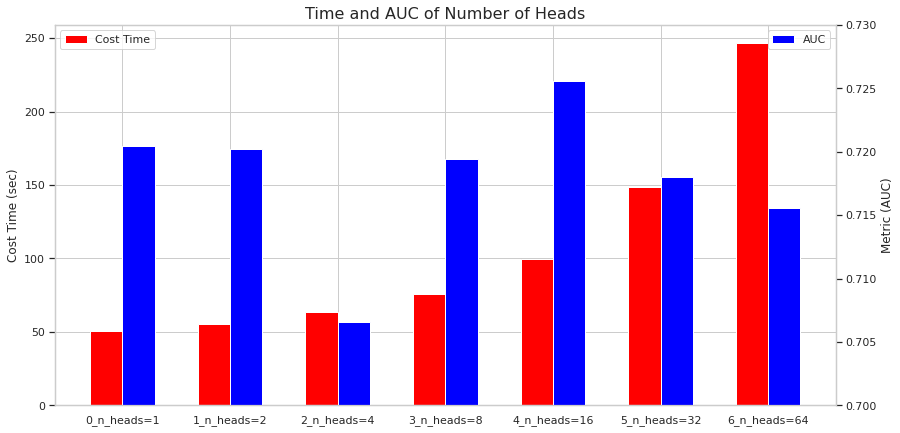

In [ ]:
fig, ax1 = plt.subplots(figsize=(14,7))

ax1.set_title('Time and AUC of Number of Heads', fontsize=16)

# Time
plt.bar(head_df['experiment_tag'],
        head_df['time_total_s'],
        color='red',
        width=-0.3, align='edge',
        label='Cost Time')
plt.ylabel('Cost Time (sec)')
ax1.legend()

# AUC
ax2 = ax1.twinx()
plt.bar(head_df['experiment_tag'],
        head_df['auc'],
        color='blue',
        width=0.3, align='edge',
        label='AUC')
plt.ylabel('Metric (AUC)')

ax2.grid(False)
ax2.set_ylim(0.7, 0.73)
ax2.legend()

plt.show()

### 🌿 embedding dimension
> Transformer에 입력될 sequence의 embedding dimension이 커질수록 더욱 많은 정보량을 표현할 수 있다. 하지만 그만큼 데이터가 많이 요구된다. 우리는 여기서 embedding dimension에 따른 성능의 변화를 살펴본다.

In [ ]:
from ray import tune

def objective_function(config):
    """
    config 예시 {'lr': 0.0001, 'n_layers': 1}
    """
    # args가 dict으로 건네지기 때문에 easydict으로 바꿔준다
    args = config['args']
    
    # 하이퍼파라메타 값 변경
    args.hidden_dim = config['hidden_dim']

    # seed 설정 - pickle serialize 불가로 사용 중지
    # seed_everything(args.seed)

    report = run(args, train_data, valid_data, gradient=False)

    best_auc = report['best_auc']

    return best_auc

def training_function(config):
    # auc 계산
    best_auc = objective_function(config)

    # Feed the score back back to Tune.
    tune.report(auc=best_auc)

gpus_per_trial = 1
analysis = tune.run(training_function,
                    config={"hidden_dim": tune.grid_search([16, 32, 64, 128, 256, 512, 1024]),
                            "args": args},
                    resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
                    verbose=2)

print("Best config: ", analysis.get_best_config(metric="auc", mode="max"))

# 값 원상복구
args.hidden_dim = 128

2021-04-14 08:00:41,493	WARNING worker.py:1107 -- Warning: The actor ImplicitFunc has size 81662699 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2021-04-14 08:00:41,596	WARNING util.py:152 -- The `start_trial` operation took 1.801 s, which may be a performance bottleneck.


(pid=3081) 2021-04-14 08:00:44.040056: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=3081) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_80773_00000 reported auc=0.6593543172967168 with parameters={'hidden_dim': 16, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.
(pid=3081) 


Trial training_function_80773_00000 completed. Last result: auc=0.6593543172967168


(pid=3081) Error in atexit._run_exitfuncs:
(pid=3081) Traceback (most recent call last):
(pid=3081)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=3081)     self._writeout_input_cache(conn)
(pid=3081)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=3081)     (self.session_number,)+line)
(pid=3081) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 139795313923840 and this is thread id 139802256177024.
2021-04-14 08:01:29,682	WARNING util.py:152 -- The `start_trial` operation took 1.211 s, which may be a performance bottleneck.
(pid=3119) 2021-04-14 08:01:32.133364: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=3119) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_80773_00001 reported auc=0.6809516679787682 with parameters={'hidden_dim': 32, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.
(pid=3119) 


Trial training_function_80773_00001 completed. Last result: auc=0.6809516679787682


(pid=3119) Error in atexit._run_exitfuncs:
(pid=3119) Traceback (most recent call last):
(pid=3119)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=3119)     self._writeout_input_cache(conn)
(pid=3119)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=3119)     (self.session_number,)+line)
(pid=3119) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 139663741515520 and this is thread id 139670683768704.
2021-04-14 08:02:19,318	WARNING util.py:152 -- The `start_trial` operation took 1.267 s, which may be a performance bottleneck.
(pid=3155) 2021-04-14 08:02:21.781286: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=3155) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_80773_00002 reported auc=0.705590196106842 with parameters={'hidden_dim': 64, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.


Trial training_function_80773_00002 completed. Last result: auc=0.705590196106842
(pid=3155) 


(pid=3155) Error in atexit._run_exitfuncs:
(pid=3155) Traceback (most recent call last):
(pid=3155)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=3155)     self._writeout_input_cache(conn)
(pid=3155)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=3155)     (self.session_number,)+line)
(pid=3155) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 139827337021184 and this is thread id 139834279274368.
2021-04-14 08:03:15,773	WARNING util.py:152 -- The `start_trial` operation took 1.237 s, which may be a performance bottleneck.
(pid=3193) 2021-04-14 08:03:18.187745: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=3193) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_80773_00003 reported auc=0.7151870509272451 with parameters={'hidden_dim': 128, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.


Trial training_function_80773_00003 completed. Last result: auc=0.7151870509272451
(pid=3193) 


(pid=3193) Error in atexit._run_exitfuncs:
(pid=3193) Traceback (most recent call last):
(pid=3193)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=3193)     self._writeout_input_cache(conn)
(pid=3193)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=3193)     (self.session_number,)+line)
(pid=3193) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 139654084429568 and this is thread id 139661026682752.
2021-04-14 08:04:23,533	WARNING util.py:152 -- The `start_trial` operation took 1.287 s, which may be a performance bottleneck.
(pid=3233) 2021-04-14 08:04:25.975000: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=3233) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_80773_00004 reported auc=0.7352783023500301 with parameters={'hidden_dim': 256, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.
(pid=3233) 


Trial training_function_80773_00004 completed. Last result: auc=0.7352783023500301


(pid=3233) Error in atexit._run_exitfuncs:
(pid=3233) Traceback (most recent call last):
(pid=3233)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=3233)     self._writeout_input_cache(conn)
(pid=3233)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=3233)     (self.session_number,)+line)
(pid=3233) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140089045051136 and this is thread id 140095987304320.
2021-04-14 08:06:05,040	WARNING util.py:152 -- The `start_trial` operation took 1.271 s, which may be a performance bottleneck.
(pid=3278) 2021-04-14 08:06:07.428285: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=3278) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_80773_00005 reported auc=0.7290808367182329 with parameters={'hidden_dim': 512, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.


Trial training_function_80773_00005 completed. Last result: auc=0.7290808367182329
(pid=3278) 


(pid=3278) Error in atexit._run_exitfuncs:
(pid=3278) Traceback (most recent call last):
(pid=3278)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=3278)     self._writeout_input_cache(conn)
(pid=3278)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=3278)     (self.session_number,)+line)
(pid=3278) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140678710580992 and this is thread id 140685652834176.
2021-04-14 08:09:10,364	WARNING util.py:152 -- The `start_trial` operation took 1.230 s, which may be a performance bottleneck.
(pid=3347) 2021-04-14 08:09:12.409988: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=3347) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_80773_00006 reported auc=0.7435952545396295 with parameters={'hidden_dim': 1024, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.
(pid=3347) 


Trial training_function_80773_00006 completed. Last result: auc=0.7435952545396295


2021-04-14 08:15:56,055	INFO tune.py:450 -- Total run time: 917.91 seconds (916.93 seconds for the tuning loop).


Best config:  {'hidden_dim': 1024, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}


In [ ]:
embed_df = analysis.results_df[['experiment_tag', 'time_total_s', 'auc']]
embed_df

experiment_tag  time_total_s       auc
trial_id                                              
80773_00000    0_hidden_dim=16     43.382062  0.659354
80773_00001    1_hidden_dim=32     44.853789  0.680952
80773_00002    2_hidden_dim=64     51.672759  0.705590
80773_00003   3_hidden_dim=128     62.977520  0.715187
80773_00004   4_hidden_dim=256     96.721726  0.735278
80773_00005   5_hidden_dim=512    180.647078  0.729081
80773_00006  6_hidden_dim=1024    402.552632  0.743595

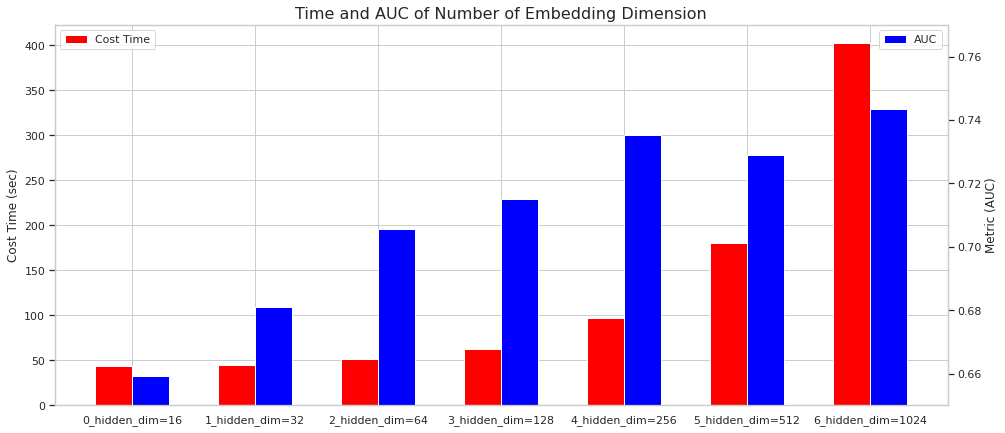

In [ ]:
fig, ax1 = plt.subplots(figsize=(16,7))

ax1.set_title('Time and AUC of Number of Embedding Dimension', fontsize=16)

# Time
plt.bar(embed_df['experiment_tag'],
        embed_df['time_total_s'],
        color='red',
        width=-0.3, align='edge',
        label='Cost Time')
plt.ylabel('Cost Time (sec)')
ax1.legend()

# AUC
ax2 = ax1.twinx()
plt.bar(embed_df['experiment_tag'],
        embed_df['auc'],
        color='blue',
        width=0.3, align='edge',
        label='AUC')
plt.ylabel('Metric (AUC)')

ax2.grid(False)
ax2.set_ylim(0.65, 0.77)
ax2.legend()

plt.show()

### 🌿 seq_len
> Transformer에 입력될 sequence의 길이를 정한다. sequence 길이가 길면 길수록 우리는 더욱 많은 관계성에 대해 분석할 수가 있다. `Riiid`대회에서 1등을한 keetar님의 모델의 경우 이 sequence길이를 길게하는 만큼 성능이 더 좋게 나오는 점에 착안해 모델을 더 긴 sequence를 입력받을 수 있는 transformer 변형 모델을 사용하였다. 우리는 여기서 sequence 길이에 따른 성능의 변화를 살펴본다.

**유용한 자료**
- [Riiid Answer Correctness Prediction [1st place solution] Last Query Transformer RNN - Kaggle](https://www.kaggle.com/c/riiid-test-answer-prediction/discussion/218318)

In [ ]:
from ray import tune

def objective_function(config):
    """
    config 예시 {'lr': 0.0001, 'n_layers': 1}
    """
    # args가 dict으로 건네지기 때문에 easydict으로 바꿔준다
    args = config['args']
    
    # 하이퍼파라메타 값 변경
    args.max_seq_len = config['max_seq_len']

    # seed 설정 - pickle serialize 불가로 사용 중지
    # seed_everything(args.seed)

    report = run(args, train_data, valid_data, gradient=False)

    best_auc = report['best_auc']

    return best_auc

def training_function(config):
    # auc 계산
    best_auc = objective_function(config)

    # Feed the score back back to Tune.
    tune.report(auc=best_auc)

gpus_per_trial = 1
analysis = tune.run(training_function,
                    config={"max_seq_len": tune.grid_search([10, 50, 100, 200, 256, 512, 1024]),
                            "args": args},
                    resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
                    verbose=2)

print("Best config: ", analysis.get_best_config(metric="auc", mode="max"))

# 값 원상복구
args.max_seq_len = 300

2021-04-18 12:09:39,556	WARNING worker.py:1107 -- Warning: The actor ImplicitFunc has size 81930386 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2021-04-18 12:09:39,652	WARNING util.py:152 -- The `start_trial` operation took 2.484 s, which may be a performance bottleneck.


(pid=2294) 2021-04-18 12:09:41.605164: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=2294) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_f17f5_00000 reported auc=0.7570060582057858 with parameters={'max_seq_len': 10, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'Tfixup': False, 'layer_norm': True, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.


(pid=2294) 
Trial training_function_f17f5_00000 completed. Last result: auc=0.7570060582057858


(pid=2294) Error in atexit._run_exitfuncs:
(pid=2294) Traceback (most recent call last):
(pid=2294)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=2294)     self._writeout_input_cache(conn)
(pid=2294)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=2294)     (self.session_number,)+line)
(pid=2294) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140033376397056 and this is thread id 140040305543040.
2021-04-18 12:09:56,674	WARNING util.py:152 -- The `start_trial` operation took 1.169 s, which may be a performance bottleneck.
(pid=2323) 2021-04-18 12:09:58.606810: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=2323) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_f17f5_00001 reported auc=0.7326017764082551 with parameters={'max_seq_len': 50, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'Tfixup': False, 'layer_norm': True, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.


Trial training_function_f17f5_00001 completed. Last result: auc=0.7326017764082551
(pid=2323) 


(pid=2323) Error in atexit._run_exitfuncs:
(pid=2323) Traceback (most recent call last):
(pid=2323)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=2323)     self._writeout_input_cache(conn)
(pid=2323)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=2323)     (self.session_number,)+line)
(pid=2323) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140535785932544 and this is thread id 140542715078528.
2021-04-18 12:10:17,330	WARNING util.py:152 -- The `start_trial` operation took 1.181 s, which may be a performance bottleneck.
(pid=2353) 2021-04-18 12:10:19.268183: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=2353) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_f17f5_00002 reported auc=0.739685514239118 with parameters={'max_seq_len': 100, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'Tfixup': False, 'layer_norm': True, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.


(pid=2353) 
Trial training_function_f17f5_00002 completed. Last result: auc=0.739685514239118


(pid=2353) Error in atexit._run_exitfuncs:
(pid=2353) Traceback (most recent call last):
(pid=2353)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=2353)     self._writeout_input_cache(conn)
(pid=2353)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=2353)     (self.session_number,)+line)
(pid=2353) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140455694526208 and this is thread id 140462623672192.
2021-04-18 12:10:41,978	WARNING util.py:152 -- The `start_trial` operation took 1.187 s, which may be a performance bottleneck.
(pid=2382) 2021-04-18 12:10:43.935213: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=2382) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_f17f5_00003 reported auc=0.7271569579209873 with parameters={'max_seq_len': 200, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'Tfixup': False, 'layer_norm': True, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.


Trial training_function_f17f5_00003 completed. Last result: auc=0.7271569579209873
(pid=2382) 


(pid=2382) Error in atexit._run_exitfuncs:
(pid=2382) Traceback (most recent call last):
(pid=2382)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=2382)     self._writeout_input_cache(conn)
(pid=2382)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=2382)     (self.session_number,)+line)
(pid=2382) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140291266979584 and this is thread id 140298196125568.
2021-04-18 12:11:17,347	WARNING util.py:152 -- The `start_trial` operation took 1.178 s, which may be a performance bottleneck.
(pid=2414) 2021-04-18 12:11:19.310755: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=2414) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_f17f5_00004 reported auc=0.721533436047532 with parameters={'max_seq_len': 256, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'Tfixup': False, 'layer_norm': True, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.


Trial training_function_f17f5_00004 completed. Last result: auc=0.721533436047532
(pid=2414) 


(pid=2414) Error in atexit._run_exitfuncs:
(pid=2414) Traceback (most recent call last):
(pid=2414)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=2414)     self._writeout_input_cache(conn)
(pid=2414)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=2414)     (self.session_number,)+line)
(pid=2414) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140106843629312 and this is thread id 140113772775296.
2021-04-18 12:11:58,401	WARNING util.py:152 -- The `start_trial` operation took 1.155 s, which may be a performance bottleneck.
(pid=2448) 2021-04-18 12:12:00.318123: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=2448) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_f17f5_00005 reported auc=0.7244989462939976 with parameters={'max_seq_len': 512, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'Tfixup': False, 'layer_norm': True, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.
(pid=2448) 


Trial training_function_f17f5_00005 completed. Last result: auc=0.7244989462939976


(pid=2448) Error in atexit._run_exitfuncs:
(pid=2448) Traceback (most recent call last):
(pid=2448)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=2448)     self._writeout_input_cache(conn)
(pid=2448)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=2448)     (self.session_number,)+line)
(pid=2448) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 139738910897920 and this is thread id 139745840043904.
2021-04-18 12:13:13,985	WARNING util.py:152 -- The `start_trial` operation took 1.185 s, which may be a performance bottleneck.
(pid=2486) 2021-04-18 12:13:15.503428: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=2486) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_f17f5_00006 reported auc=0.716288250171861 with parameters={'max_seq_len': 1024, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'Tfixup': False, 'layer_norm': True, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.
(pid=2486) 


Trial training_function_f17f5_00006 completed. Last result: auc=0.716288250171861


2021-04-18 12:16:04,250	INFO tune.py:450 -- Total run time: 388.75 seconds (387.73 seconds for the tuning loop).


Best config:  {'max_seq_len': 10, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'Tfixup': False, 'layer_norm': True, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}


In [ ]:
seq_df = analysis.results_df[['experiment_tag', 'time_total_s', 'auc']]
seq_df

experiment_tag  time_total_s       auc
trial_id                                               
f17f5_00000    0_max_seq_len=10     12.204507  0.757006
f17f5_00001    1_max_seq_len=50     15.962942  0.732602
f17f5_00002   2_max_seq_len=100     19.933435  0.739686
f17f5_00003   3_max_seq_len=200     30.640693  0.727157
f17f5_00004   4_max_seq_len=256     36.324050  0.721533
f17f5_00005   5_max_seq_len=512     70.923937  0.724499
f17f5_00006  6_max_seq_len=1024    167.160652  0.716288

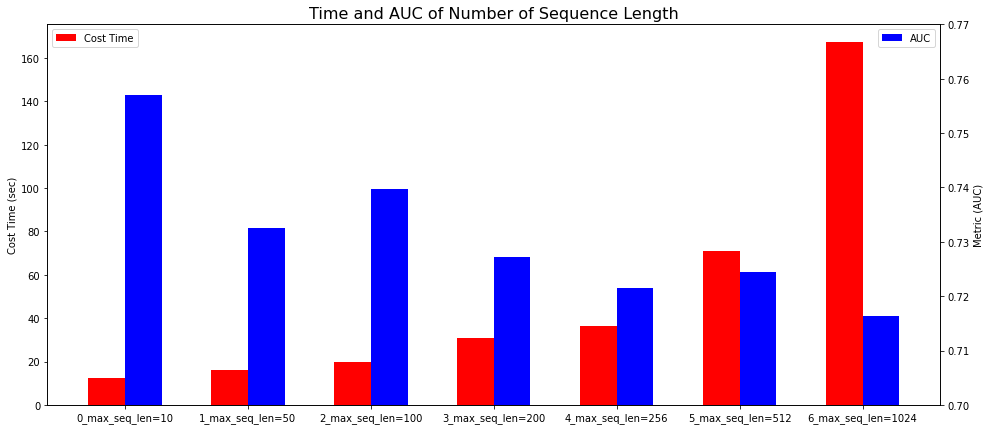

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(16,7))

ax1.set_title('Time and AUC of Number of Sequence Length', fontsize=16)

# Time
plt.bar(seq_df['experiment_tag'],
        seq_df['time_total_s'],
        color='red',
        width=-0.3, align='edge',
        label='Cost Time')
plt.ylabel('Cost Time (sec)')
ax1.legend()

# AUC
ax2 = ax1.twinx()
plt.bar(seq_df['experiment_tag'],
        seq_df['auc'],
        color='blue',
        width=0.3, align='edge',
        label='AUC')
plt.ylabel('Metric (AUC)')

ax2.grid(False)
ax2.set_ylim(0.7, 0.77)
ax2.legend()

plt.show()

### 🌿 `hyperopt`으로 hyperparameter들을 동시에 탐색
> hyperparmeter들이 서로 독립이 아닌 이상 각각의 hyperparameter들을 별개로 탐색하는 것은 최고의 성능을 보장하지 않는다. 그렇다고 모든 hyperparamter들의 조합을 Grid 탐색으로 찾기에 시간이 너무 많이 걸린다. 이럴때는 bayesian 탐색을 하는 것이 효율적이다. `hyperopt`를 이용해서 최적의 hyperparameter 조합을 찾아보자!

In [ ]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import matplotlib.pyplot as plt

# 최적화 할 함수
def objective_function(space):
    """
    space 예시 {'batch_size': 64, 'lr': 0.00010810929882981193, 'n_layers': 1}
    """

    # args가 dict으로 건네지기 때문에 easydict으로 바꿔준다
    args = space['args']
    args = easydict.EasyDict(args)
    
    # 하이퍼파라메타 값 변경
    args.n_layers = space['n_layers']
    args.n_heads = space['n_heads']
    args.hidden_dim = space['hidden_dim']
    args.max_seq_len = space['seq_len']

    # seed 설정 
    seed_everything(args.seed)

    report = run(args, train_data, valid_data, gradient=False)

    best_auc = report['best_auc']

    return -best_auc

# 탐색 공간
space = {
    'n_layers': hp.choice('n_layers', [1, 2, 3, 4, 5]),
    'n_heads': hp.choice('n_heads', [1, 2, 4, 8, 16, 32, 64]),
    'hidden_dim': hp.choice('hidden_dim', [16, 32, 64, 128, 256, 512, 1024]),
    'seq_len': hp.choice('seq_len', [10, 50, 100, 200, 256, 512, 1024, 2048]),
    'args': args
}

# 최적화
trials = Trials()
best = fmin(
            fn=objective_function,  # 최적화 할 함수
            space=space,            # Hyperparameter 탐색 공간
            algo=tpe.suggest,       # Tree-structured Parzen Estimator (TPE)
            max_evals=10,           # 10번 시도
            trials=trials
            )

# 하이퍼파라메타 원상복구
args.n_layers = 1
args.n_heads = 4
args.hidden_dim = 128
args.max_seq_len = 300


  0%|          | 0/10 [00:00<?, ?it/s, best loss: ?]


 10%|█         | 1/10 [00:43<06:35, 43.89s/it, best loss: -0.6884330610924089]


 20%|██        | 2/10 [05:22<15:14, 114.32s/it, best loss: -0.7232858561904624]


 30%|███       | 3/10 [06:39<12:00, 102.98s/it, best loss: -0.7232858561904624]


 40%|████      | 4/10 [08:40<10:51, 108.52s/it, best loss: -0.7232858561904624]


 50%|█████     | 5/10 [20:43<24:24, 292.98s/it, best loss: -0.7435429314761061]


 60%|██████    | 6/10 [24:06<17:43, 265.92s/it, best loss: -0.7435429314761061]


 70%|███████   | 7/10 [29:35<14:14, 284.93s/it, best loss: -0.7435429314761061]


 80%|████████  | 8/10 [34:14<09:25, 282.98s/it, best loss: -0.7435429314761061]


 90%|█████████ | 9/10 [35:32<03:41, 221.64s/it, best loss: -0.7435429314761061]


100%|██████████| 10/10 [40:50<00:00, 245.04s/it, best loss: -0.7435429314761061]


In [ ]:
df = trials_to_df(trials, space, best)
df

experiment  hidden_dim  n_heads  n_layers  seq_len    metric     time
0          0          16        4         2     2048  0.688433   43.888
1          1         256       32         3      200  0.723286  278.619
2          2         256       16         1       10  0.722492   76.509
3          3          64        4         5      200  0.703112  121.435
4          4        1024        4         4      100  0.743543  723.362
5          5         256       16         3      512  0.723234  202.770
6          6         256       16         5      100  0.725142  329.248
7          7         256       32         3     2048  0.723286  278.425
8          8          16        4         4       50  0.681427   78.484
9          9         512        1         4      100  0.731758  317.465
0       best        1024        4         4      100  0.743543  723.362

## 🏹 Training의 Hyperparamter가 변경되었을 때 모델과 성능에 끼치는 영향들
> 여기서 Training단계에서의 하이퍼파라메타를 변경해보며 다음의 요소에 대해서 알아볼 것이다!
- 학습속도에는 어떤 arg가 영향을 많이 미치는지
- 성능에는 어떤 arg가 영향을 많이 미치는지
- 학습 속도와 성능 Trade-off를 어떻게 조절해야 하는지

- learning rate
- batch size
- `hyperopt`으로 hyperparameter들을 동시에 탐색

### 🌿 learning rate
> 이제는 들으면 지겨운 그 이름 learning rate이다. learning rate의 중요성은 이제는 강조하면 하품이 나올 지경이니 넘기도록 하자. 아래는 `How to Fine-Tune BERT for Text Classification?` 논문에서 나오는 learning rate에 관한 내용이다. 가볍게 읽어보자.

[How to Fine-Tune BERT for Text Classification?](https://arxiv.org/pdf/1905.05583.pdf)
- 이 논문에서 learning rate에 대한 다음의 내용이 나오는데 이 중 layer-wise 방법은 기억해두고 생각해보자.
- Layer-wise Decreasing Layer Rate
    - 아래 layer로 갈수록 learning rate를 점진적으로 감소시켜 적용하며 효과적이라고 한다. 
    - ![layerwise](https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F6ceb775b-07f2-456f-8ec6-a347df53d2a1%2FUntitled.png?table=block&id=f7b6985a-ff00-4643-9353-cd25abdae77f&width=860&userId=1f48fc9a-7bf2-44fb-8d00-a699b59f59b8&cache=v2)
- Catastrophic Forgetting
    - pretrained에서 배운 지식이 새로운 지식을 배울때 없어지는 현상
    - 낮은 learning rate 0.00002가 이런 catastrophic forgetting problem을 극복하는데 필요하다는 것을 발견
    - 공격적인 learning rate인 0.0004에서는 training set이 수렴에 실패함
    - ![image](https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F89eb25ed-a839-499d-857e-689640695c4b%2FUntitled.png?table=block&id=01b261c7-a236-4940-b295-33fec06f866a&width=1820&userId=1f48fc9a-7bf2-44fb-8d00-a699b59f59b8&cache=v2)

In [ ]:
from ray import tune

def objective_function(config):
    """
    config 예시 {'lr': 0.0001, 'n_layers': 1}
    """
    # args가 dict으로 건네지기 때문에 easydict으로 바꿔준다
    args = config['args']
    
    # 하이퍼파라메타 값 변경
    args.lr = config['lr']

    # seed 설정 - pickle serialize 불가로 사용 중지
    # seed_everything(args.seed)

    report = run(args, train_data, valid_data, gradient=False)

    best_auc = report['best_auc']

    return best_auc

def training_function(config):
    # auc 계산
    best_auc = objective_function(config)

    # Feed the score back back to Tune.
    tune.report(auc=best_auc)

gpus_per_trial = 1
analysis = tune.run(training_function,
                    config={"lr": tune.grid_search([1e-0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]),
                            "args": args},
                    resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
                    verbose=2)

print("Best config: ", analysis.get_best_config(metric="auc", mode="max"))

# 값 원상복구
args.lr = 0.0001

2021-04-14 15:28:40,991	WARNING worker.py:1107 -- Warning: The actor ImplicitFunc has size 81662707 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2021-04-14 15:28:41,082	WARNING util.py:152 -- The `start_trial` operation took 2.138 s, which may be a performance bottleneck.


(pid=2358) 2021-04-14 15:28:43.390031: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=2358) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_15b26_00000 reported auc=0.5007385601658882 with parameters={'lr': 1.0, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912, 'seq_len': 300}}.


Trial training_function_15b26_00000 completed. Last result: auc=0.5007385601658882
(pid=2358) 


(pid=2358) Error in atexit._run_exitfuncs:
(pid=2358) Traceback (most recent call last):
(pid=2358)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=2358)     self._writeout_input_cache(conn)
(pid=2358)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=2358)     (self.session_number,)+line)
(pid=2358) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 139763573319424 and this is thread id 139770502465408.
2021-04-14 15:29:28,018	WARNING util.py:152 -- The `start_trial` operation took 1.210 s, which may be a performance bottleneck.
(pid=2385) 2021-04-14 15:29:30.290930: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=2385) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_15b26_00001 reported auc=0.6562680615190433 with parameters={'lr': 0.1, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912, 'seq_len': 300}}.


Trial training_function_15b26_00001 completed. Last result: auc=0.6562680615190433
(pid=2385) 


(pid=2385) Error in atexit._run_exitfuncs:
(pid=2385) Traceback (most recent call last):
(pid=2385)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=2385)     self._writeout_input_cache(conn)
(pid=2385)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=2385)     (self.session_number,)+line)
(pid=2385) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140460794337024 and this is thread id 140467723483008.
2021-04-14 15:30:15,016	WARNING util.py:152 -- The `start_trial` operation took 1.169 s, which may be a performance bottleneck.
(pid=2412) 2021-04-14 15:30:17.371550: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=2412) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_15b26_00002 reported auc=0.7152333367142083 with parameters={'lr': 0.01, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912, 'seq_len': 300}}.


Trial training_function_15b26_00002 completed. Last result: auc=0.7152333367142083
(pid=2412) 


(pid=2412) Error in atexit._run_exitfuncs:
(pid=2412) Traceback (most recent call last):
(pid=2412)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=2412)     self._writeout_input_cache(conn)
(pid=2412)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=2412)     (self.session_number,)+line)
(pid=2412) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 139987850962688 and this is thread id 139994780108672.
2021-04-14 15:31:01,948	WARNING util.py:152 -- The `start_trial` operation took 1.169 s, which may be a performance bottleneck.
(pid=2439) 2021-04-14 15:31:04.264912: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=2439) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_15b26_00003 reported auc=0.7172566293321484 with parameters={'lr': 0.001, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912, 'seq_len': 300}}.
(pid=2439) 


Trial training_function_15b26_00003 completed. Last result: auc=0.7172566293321484


(pid=2439) Error in atexit._run_exitfuncs:
(pid=2439) Traceback (most recent call last):
(pid=2439)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=2439)     self._writeout_input_cache(conn)
(pid=2439)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=2439)     (self.session_number,)+line)
(pid=2439) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140410058782464 and this is thread id 140416987928448.
2021-04-14 15:31:48,935	WARNING util.py:152 -- The `start_trial` operation took 1.217 s, which may be a performance bottleneck.
(pid=2467) 2021-04-14 15:31:51.201253: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=2467) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_15b26_00004 reported auc=0.7203895733818891 with parameters={'lr': 0.0001, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912, 'seq_len': 300}}.


Trial training_function_15b26_00004 completed. Last result: auc=0.7203895733818891
(pid=2467) 


(pid=2467) Error in atexit._run_exitfuncs:
(pid=2467) Traceback (most recent call last):
(pid=2467)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=2467)     self._writeout_input_cache(conn)
(pid=2467)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=2467)     (self.session_number,)+line)
(pid=2467) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140704454809344 and this is thread id 140711383955328.
2021-04-14 15:32:35,715	WARNING util.py:152 -- The `start_trial` operation took 1.215 s, which may be a performance bottleneck.
(pid=2491) 2021-04-14 15:32:37.960009: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=2491) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_15b26_00005 reported auc=0.6867957516892299 with parameters={'lr': 1e-05, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912, 'seq_len': 300}}.
(pid=2491) 


Trial training_function_15b26_00005 completed. Last result: auc=0.6867957516892299


(pid=2491) Error in atexit._run_exitfuncs:
(pid=2491) Traceback (most recent call last):
(pid=2491)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=2491)     self._writeout_input_cache(conn)
(pid=2491)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=2491)     (self.session_number,)+line)
(pid=2491) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 139636535334656 and this is thread id 139643464480640.
2021-04-14 15:33:22,580	WARNING util.py:152 -- The `start_trial` operation took 1.213 s, which may be a performance bottleneck.
(pid=2518) 2021-04-14 15:33:24.756690: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=2518) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_15b26_00006 reported auc=0.6411788949690972 with parameters={'lr': 1e-06, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912, 'seq_len': 300}}.


Trial training_function_15b26_00006 completed. Last result: auc=0.6411788949690972


2021-04-14 15:34:08,171	INFO tune.py:450 -- Total run time: 330.86 seconds (329.88 seconds for the tuning loop).


(pid=2518) 
Best config:  {'lr': 0.0001, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912, 'seq_len': 300}}


In [ ]:
lr_df = analysis.results_df[['experiment_tag', 'time_total_s', 'auc']]
lr_df

experiment_tag  time_total_s       auc
trial_id                                          
15b26_00000       0_lr=1.0     42.283451  0.500739
15b26_00001       1_lr=0.1     42.416033  0.656268
15b26_00002      2_lr=0.01     42.248075  0.715233
15b26_00003     3_lr=0.001     42.294706  0.717257
15b26_00004    4_lr=0.0001     42.140578  0.720390
15b26_00005     5_lr=1e-05     42.252661  0.686796
15b26_00006     6_lr=1e-06     42.252927  0.641179

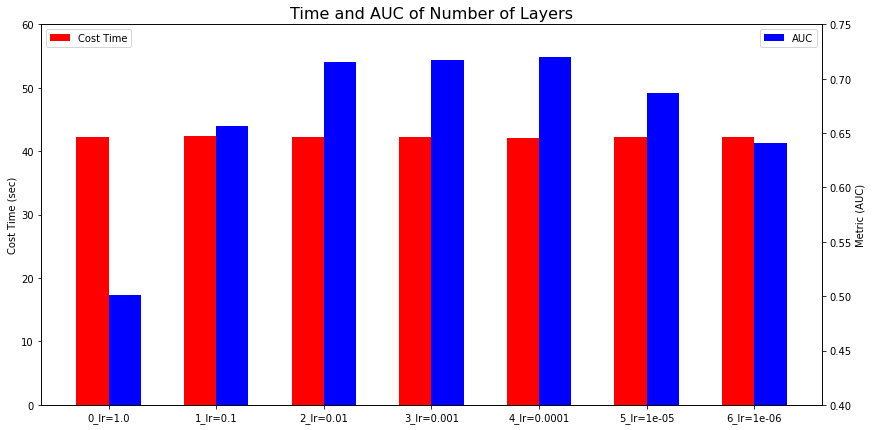

In [ ]:
fig, ax1 = plt.subplots(figsize=(14,7))

ax1.set_title('Time and AUC of Number of Learning Rate', fontsize=16)

# Time
plt.bar(lr_df['experiment_tag'],
        lr_df['time_total_s'],
        color='red',
        width=-0.3, align='edge',
        label='Cost Time')
plt.ylabel('Cost Time (sec)')
ax1.set_ylim(0, 60)
ax1.legend(loc=2)

# AUC
ax2 = ax1.twinx()
plt.bar(lr_df['experiment_tag'],
        lr_df['auc'],
        color='blue',
        width=0.3, align='edge',
        label='AUC')
plt.ylabel('Metric (AUC)')

ax2.grid(False)
ax2.set_ylim(0.4, 0.75)
ax2.legend()

plt.show()

### 🌿 batch size
> 배치 사이즈에는 정답이 없다. 배치 사이즈가 크면 학습 속도가 빨라지고 경우에 따라서는 일반화 성능이 하락하기도 하며 작을수록 stochastic해져 local minimum을 쉽게 벗어나는 성향이 생기지만 결과가 불안정해지기도 한다.
<br><br>
일반적으로 실제 훈련에서는 너무 작지도 크지도 않은 적절한 배치 사이즈를 사용한다. 만약 데이터셋의 크기가 작을 경우 데이터셋 크기에 근접하는 배치 사이즈를 설정한다면 최적화시에 비슷한 데이터셋을 지속적으로 배우기 때문에 적절히 작은 사이즈를 잘 선택하자.

[Large Batch Training Of Convolutional Networks](https://arxiv.org/pdf/1708.03888.pdf)
- 이 논문에서는 32K에 달하는 커다란 배치 사이즈로 훈련하는 방법에 대한 내용을 담고 있다. 일반적으로 learning rate를 사용하는 방법과 다르게 이 논문에서는 `(LARS)`라고 불리는 각 레이어마다 learning rate를 다르게 설정하는 방법을 사용하고 있다. 이를 통해 큰 배치 사이즈임에도 불구하고 성능이 하락하지 않으며 매우 효율적인 학습이 가능함을 보여주었다.


In [ ]:
from ray import tune

def objective_function(config):
    """
    config 예시 {'lr': 0.0001, 'n_layers': 1}
    """
    # args가 dict으로 건네지기 때문에 easydict으로 바꿔준다
    args = config['args']
    
    # 하이퍼파라메타 값 변경
    args.batch_size = config['batch_size']

    # seed 설정 - pickle serialize 불가로 사용 중지
    # seed_everything(args.seed)

    report = run(args, train_data, valid_data, gradient=False)

    best_auc = report['best_auc']

    return best_auc

def training_function(config):
    # auc 계산
    best_auc = objective_function(config)

    # Feed the score back back to Tune.
    tune.report(auc=best_auc)

gpus_per_trial = 1
analysis = tune.run(training_function,
                    config={"batch_size": tune.grid_search([1, 2, 4, 8, 16, 32, 64, 128, 256, 512]),
                            "args": args},
                    resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
                    verbose=2)

print("Best config: ", analysis.get_best_config(metric="auc", mode="max"))

# 값 원상복구
args.batch_size = 64

2021-04-14 16:40:12,137	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265
2021-04-14 16:40:14,533	WARNING function_runner.py:541 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2021-04-14 16:40:18,341	WARNING worker.py:1107 -- Warning: The actor ImplicitFunc has size 81930295 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


(pid=3235) 2021-04-14 16:40:20.033584: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=3235) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_17497_00000 reported auc=0.7524362423346712 with parameters={'batch_size': 1, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.
(pid=3235) 


Trial training_function_17497_00000 completed. Last result: auc=0.7524362423346712


(pid=3235) Error in atexit._run_exitfuncs:
(pid=3235) Traceback (most recent call last):
(pid=3235)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=3235)     self._writeout_input_cache(conn)
(pid=3235)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=3235)     (self.session_number,)+line)
(pid=3235) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140596281104128 and this is thread id 140603196094336.
2021-04-14 16:46:42,919	WARNING util.py:152 -- The `start_trial` operation took 1.210 s, which may be a performance bottleneck.
(pid=3236) 2021-04-14 16:46:44.482867: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=3236) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_17497_00001 reported auc=0.7283386541864085 with parameters={'batch_size': 2, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.


(pid=3236) 
Trial training_function_17497_00001 completed. Last result: auc=0.7283386541864085


(pid=3236) Error in atexit._run_exitfuncs:
(pid=3236) Traceback (most recent call last):
(pid=3236)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=3236)     self._writeout_input_cache(conn)
(pid=3236)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=3236)     (self.session_number,)+line)
(pid=3236) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 139669984302848 and this is thread id 139676899293056.
2021-04-14 16:50:08,638	WARNING util.py:152 -- The `start_trial` operation took 1.266 s, which may be a performance bottleneck.
(pid=3353) 2021-04-14 16:50:10.658683: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=3353) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_17497_00002 reported auc=0.7286791565844148 with parameters={'batch_size': 4, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.


Trial training_function_17497_00002 completed. Last result: auc=0.7286791565844148
(pid=3353) 


(pid=3353) Error in atexit._run_exitfuncs:
(pid=3353) Traceback (most recent call last):
(pid=3353)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=3353)     self._writeout_input_cache(conn)
(pid=3353)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=3353)     (self.session_number,)+line)
(pid=3353) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 139801725490944 and this is thread id 139808640481152.
2021-04-14 16:52:18,182	WARNING util.py:152 -- The `start_trial` operation took 1.216 s, which may be a performance bottleneck.
(pid=3384) 2021-04-14 16:52:20.197334: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=3384) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_17497_00003 reported auc=0.7130740041311071 with parameters={'batch_size': 8, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.
(pid=3384) 


Trial training_function_17497_00003 completed. Last result: auc=0.7130740041311071


(pid=3384) Error in atexit._run_exitfuncs:
(pid=3384) Traceback (most recent call last):
(pid=3384)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=3384)     self._writeout_input_cache(conn)
(pid=3384)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=3384)     (self.session_number,)+line)
(pid=3384) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140271529301760 and this is thread id 140278444291968.
2021-04-14 16:53:41,419	WARNING util.py:152 -- The `start_trial` operation took 1.199 s, which may be a performance bottleneck.
(pid=3413) 2021-04-14 16:53:43.472462: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=3413) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_17497_00004 reported auc=0.7253554345953657 with parameters={'batch_size': 16, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.


Trial training_function_17497_00004 completed. Last result: auc=0.7253554345953657
(pid=3413) 


(pid=3413) Error in atexit._run_exitfuncs:
(pid=3413) Traceback (most recent call last):
(pid=3413)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=3413)     self._writeout_input_cache(conn)
(pid=3413)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=3413)     (self.session_number,)+line)
(pid=3413) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 139807522789120 and this is thread id 139814437779328.
2021-04-14 16:54:44,131	WARNING util.py:152 -- The `start_trial` operation took 1.241 s, which may be a performance bottleneck.
(pid=3441) 2021-04-14 16:54:46.169766: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=3441) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_17497_00005 reported auc=0.7063291587578344 with parameters={'batch_size': 32, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.


Trial training_function_17497_00005 completed. Last result: auc=0.7063291587578344
(pid=3441) 


(pid=3441) Error in atexit._run_exitfuncs:
(pid=3441) Traceback (most recent call last):
(pid=3441)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=3441)     self._writeout_input_cache(conn)
(pid=3441)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=3441)     (self.session_number,)+line)
(pid=3441) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140585255790336 and this is thread id 140592170780544.
2021-04-14 16:55:36,365	WARNING util.py:152 -- The `start_trial` operation took 1.282 s, which may be a performance bottleneck.
(pid=3467) 2021-04-14 16:55:38.398410: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=3467) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_17497_00006 reported auc=0.7207654944690497 with parameters={'batch_size': 64, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.


Trial training_function_17497_00006 completed. Last result: auc=0.7207654944690497(pid=3467) 



(pid=3467) Error in atexit._run_exitfuncs:
(pid=3467) Traceback (most recent call last):
(pid=3467)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=3467)     self._writeout_input_cache(conn)
(pid=3467)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=3467)     (self.session_number,)+line)
(pid=3467) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140241080334080 and this is thread id 140247995324288.
2021-04-14 16:56:23,824	WARNING util.py:152 -- The `start_trial` operation took 1.256 s, which may be a performance bottleneck.
(pid=3492) 2021-04-14 16:56:25.805692: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=3492) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_17497_00007 reported auc=0.7161385257131634 with parameters={'batch_size': 128, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.


(pid=3492) 
Trial training_function_17497_00007 completed. Last result: auc=0.7161385257131634


(pid=3492) Error in atexit._run_exitfuncs:
(pid=3492) Traceback (most recent call last):
(pid=3492)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=3492)     self._writeout_input_cache(conn)
(pid=3492)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=3492)     (self.session_number,)+line)
(pid=3492) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 139855762102016 and this is thread id 139862677092224.
2021-04-14 16:57:09,079	WARNING util.py:152 -- The `start_trial` operation took 1.255 s, which may be a performance bottleneck.
(pid=3519) 2021-04-14 16:57:11.101949: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=3519) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_17497_00008 reported auc=0.7221580929289806 with parameters={'batch_size': 256, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.


Trial training_function_17497_00008 completed. Last result: auc=0.7221580929289806(pid=3519) 



2021-04-14 16:57:53,041	WARNING util.py:152 -- The `start_trial` operation took 1.085 s, which may be a performance bottleneck.
(pid=3545) 2021-04-14 16:57:54.643323: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=3545) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_17497_00009 reported auc=0.7032356582482883 with parameters={'batch_size': 512, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.


Trial training_function_17497_00009 completed. Last result: auc=0.7032356582482883
(pid=3545) 


2021-04-14 16:58:35,097	INFO tune.py:450 -- Total run time: 1103.79 seconds (1099.11 seconds for the tuning loop).


Best config:  {'batch_size': 1, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}


In [ ]:
batch_df = analysis.results_df[['experiment_tag', 'time_total_s', 'auc']]
batch_df

experiment_tag  time_total_s       auc
trial_id                                             
17497_00000    0_batch_size=1    380.119988  0.752436
17497_00001    1_batch_size=2    201.346134  0.728339
17497_00002    2_batch_size=4    124.756656  0.728679
17497_00003    3_batch_size=8     78.501315  0.713074
17497_00004   4_batch_size=16     57.877861  0.725355
17497_00005   5_batch_size=32     47.384772  0.706329
17497_00006   6_batch_size=64     42.603252  0.720765
17497_00007  7_batch_size=128     40.411613  0.716139
17497_00008  8_batch_size=256     39.319260  0.722158
17497_00009  9_batch_size=512     38.898796  0.703236

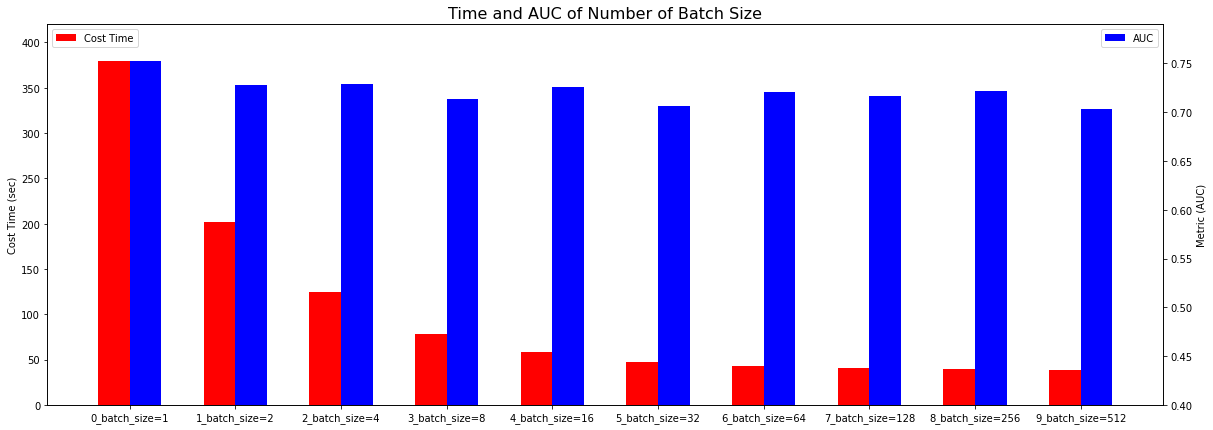

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(20, 7))

ax1.set_title('Time and AUC of Number of Batch Size', fontsize=16)

# Time
plt.bar(batch_df['experiment_tag'],
        batch_df['time_total_s'],
        color='red',
        width=-0.3, align='edge',
        label='Cost Time')
plt.ylabel('Cost Time (sec)')
ax1.set_ylim(0, 420)
ax1.legend(loc=2)

# AUC
ax2 = ax1.twinx()
plt.bar(batch_df['experiment_tag'],
        batch_df['auc'],
        color='blue',
        width=0.3, align='edge',
        label='AUC')
plt.ylabel('Metric (AUC)')

ax2.grid(False)
ax2.set_ylim(0.4, 0.79)
ax2.legend()

plt.show()

### 🌿 `hyperopt`으로 hyperparameter들을 동시에 탐색
> hyperparmeter들이 서로 독립이 아닌 이상 각각의 hyperparameter들을 별개로 탐색하는 것은 최고의 성능을 보장하지 않는다. 그렇다고 모든 hyperparamter들의 조합을 Grid 탐색으로 찾기에 시간이 너무 많이 걸린다. 이럴때는 bayesian 탐색을 하는 것이 효율적이다. `hyperopt`를 이용해서 최적의 hyperparameter 조합을 찾아보자!

In [ ]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import matplotlib.pyplot as plt

# 최적화 할 함수
def objective_function(space):
    """
    space 예시 {'batch_size': 64, 'lr': 0.00010810929882981193, 'n_layers': 1}
    """

    # args가 dict으로 건네지기 때문에 easydict으로 바꿔준다
    args = space['args']
    args = easydict.EasyDict(args)
    
    # 하이퍼파라메타 값 변경
    args.batch_size = space['batch_size']
    args.lr = space['lr']

    # seed 설정 
    seed_everything(args.seed)

    report = run(args, train_data, valid_data, gradient=False)

    best_auc = report['best_auc']

    return -best_auc

# 탐색 공간
space = {
    'lr': hp.uniform('lr', 0.000001, 0.1),
    'batch_size': hp.choice('batch_size', [1, 2, 4, 8, 16, 32, 64, 128, 256]),
    'args': args
}

# 최적화
# 하나당 3 epoch를 돌리기 때문에 최대한 숫자를 줄이기위해 5번만 시도

trials = Trials()
best = fmin(
            fn=objective_function,  # 최적화 할 함수
            space=space,            # Hyperparameter 탐색 공간
            algo=tpe.suggest,       # Tree-structured Parzen Estimator (TPE)
            max_evals=20,           # 5번 시도
            trials=trials
            )

# 하이퍼파라메타 원상복구
args.lr = 0.0001
args.batch_size = 64

  0%|          | 0/20 [00:00<?, ?it/s, best loss: ?]

  5%|▌         | 1/20 [00:40<12:43, 40.18s/it, best loss: -0.7295915903152423]

 10%|█         | 2/20 [01:18<11:52, 39.60s/it, best loss: -0.7295915903152423]

 15%|█▌        | 3/20 [02:04<11:43, 41.40s/it, best loss: -0.7295915903152423]

 20%|██        | 4/20 [08:31<38:44, 145.27s/it, best loss: -0.7295915903152423]

 25%|██▌       | 5/20 [09:09<28:16, 113.13s/it, best loss: -0.7353837534472849]

 30%|███       | 6/20 [12:28<32:23, 138.82s/it, best loss: -0.7353837534472849]

 35%|███▌      | 7/20 [13:45<26:02, 120.19s/it, best loss: -0.7353837534472849]

 40%|████      | 8/20 [14:25<19:15, 96.32s/it, best loss: -0.7353837534472849] 

 45%|████▌     | 9/20 [20:52<33:36, 183.31s/it, best loss: -0.7353837534472849]

 50%|█████     | 10/20 [21:37<23:39, 141.95s/it, best loss: -0.7353837534472849]

 55%|█████▌    | 11/20 [22:54<18:21, 122.42s/it, best loss: -0.7353837534472849]

 60%|██████    | 12/20 [23:35<13:02, 97.86s/it, best loss: -0.7353837534472849] 

 65%|██████▌   | 13/20 [24:15<09:24, 80.69s/it, best loss: -0.7353837534472849]

 70%|███████   | 14/20 [24:53<06:47, 67.92s/it, best loss: -0.7353837534472849]

 75%|███████▌  | 15/20 [28:11<08:54, 106.84s/it, best loss: -0.7353837534472849]

 80%|████████  | 16/20 [31:29<08:56, 134.06s/it, best loss: -0.7353837534472849]

 85%|████████▌ | 17/20 [32:07<05:15, 105.27s/it, best loss: -0.7353837534472849]

 90%|█████████ | 18/20 [33:03<03:00, 90.49s/it, best loss: -0.7353837534472849] 

 95%|█████████▌| 19/20 [33:42<01:15, 75.15s/it, best loss: -0.7353837534472849]

100%|██████████| 20/20 [40:07<00:00, 120.39s/it, best loss: -0.7353837534472849]


In [ ]:
df = trials_to_df(trials, space, best)
df

experiment  batch_size        lr    metric     time
0           0         256  0.018460  0.729592   40.173
1           1         256  0.061700  0.704583   38.240
2           2          32  0.056844  0.663133   45.590
3           3           1  0.082935  0.661584  387.619
4           4         256  0.025500  0.735384   38.140
5           5           2  0.020965  0.538402  198.756
6           6           8  0.055770  0.520348   76.717
7           7          64  0.067043  0.686668   40.596
8           8           1  0.067942  0.688237  386.285
9           9          32  0.084531  0.655484   45.410
10         10           8  0.088005  0.646587   76.868
11         11          64  0.072905  0.675259   40.546
12         12          64  0.014505  0.685614   40.592
13         13         256  0.077276  0.696917   38.122
14         14           2  0.055025  0.628488  197.626
15         15           2  0.098018  0.644662  197.574
16         16         256  0.067221  0.687957   38.075
17         17          16  0.002025  0.726688   55.994
18         18         128  0.009446  0.724547   39.332
19         19           1  0.017981  0.544873  385.280
0        best         256  0.025500  0.735384   38.140

## 🏹 가중치 초기화 (Weight Initialization)
- T Fixup 소개
- T Fixup 응용 논문 소개
- T Fixup 모델 생성
- T Fixup 모델 사용

**유용한 자료**
- [Understanding Fixup initialization - Towards Data Science](https://towardsdatascience.com/understanding-fixup-initialization-6bf08d41b427)

### 🌿 T-Fixup 소개
> T-Fixup은 모델의 깊이에 따라 transformer parameter를 scaling하는 가중치 초기화 방법을 통해 warmup과 layer normalization의 필요성을 없애버렸다. T-Fixup은 더욱 깊은 vanilla transformer를 훈련할 수 있도록 도와주었고, 실험적으로 최고의 성능을 보여준다고 한다.

- 가중치 초기화 (Weight Initialization)
- 가중치 스케일링 (Weight Scaling)
- 활용해보기

**참고자료**
- [T-Fixup - Github](https://github.com/layer6ai-labs/T-Fixup/tree/f1fae213ce7b48829f81632d0c96bb039b7c450e)
- [riiid-acp-pub - Github](https://github.com/jamarju/riiid-acp-pub)


#### ☘️ 가중치 초기화 (Weight Initialization)
>  
- input embedding을 제외하고 모든 parameter를 Xavier 초기화한다
- input embedding은 가우시안 초기화를 한다 $N(0,d^{-\frac{1}{2}})$
    - d 는 embedding 크기이다.

- Embedding Layer
- PositionalEmbedding
- Multihead Attention


##### Embedding Layer

🧲 [layer6ai-labs/T-Fixup AdaptiveInput - Github](https://github.com/layer6ai-labs/T-Fixup/blob/b17e166d9f60671a92c3f39e24c9b8c93995e5a3/fairseq/modules/adaptive_input.py#L49)

In [ ]:
class AdaptiveInput(nn.Module):
    def init_weights(m):
        if isinstance(m, nn.Embedding):
            nn.init.normal_(m.weight, mean=0, std=m.weight.shape[1] ** -0.5)
            nn.init.constant_(m.weight[padding_idx], 0)
        elif hasattr(m, 'weight'):
            nn.init.xavier_uniform_(m.weight)

    self.apply(init_weights)

##### PositionalEmbedding
> `nn.embedding`을 positional embedding에 사용하는 경우에 적용

🧲 [layer6ai-labs/T-Fixup PositionalEmbedding - Github](https://github.com/layer6ai-labs/T-Fixup/blob/b17e166d9f60671a92c3f39e24c9b8c93995e5a3/fairseq/modules/positional_embedding.py#L25)


In [ ]:
def PositionalEmbedding():
    m = LearnedPositionalEmbedding(num_embeddings, embedding_dim, padding_idx)
    nn.init.normal_(m.weight, mean=0, std=embedding_dim ** -0.5)
    if padding_idx is not None:
        nn.init.constant_(m.weight[padding_idx], 0)

##### MultiheadAttention

🧲 [layer6ai-labs/T-Fixup MultiheadAttention - Github](https://github.com/layer6ai-labs/T-Fixup/blob/b17e166d9f60671a92c3f39e24c9b8c93995e5a3/fairseq/modules/multihead_attention.py#L85)


In [ ]:
class MultiheadAttention(nn.Module):
    def reset_parameters(self):
        if self.qkv_same_dim:
            # Empirically observed the convergence to be much better with
            # the scaled initialization
            nn.init.xavier_uniform_(self.k_proj.weight, gain=1 / math.sqrt(2))
            nn.init.xavier_uniform_(self.v_proj.weight, gain=1 / math.sqrt(2))
            nn.init.xavier_uniform_(self.q_proj.weight, gain=1 / math.sqrt(2))
        else:
            nn.init.xavier_uniform_(self.k_proj.weight)
            nn.init.xavier_uniform_(self.v_proj.weight)
            nn.init.xavier_uniform_(self.q_proj.weight)

        nn.init.xavier_uniform_(self.out_proj.weight)

        if self.out_proj.bias is not None:
            nn.init.constant_(self.out_proj.bias, 0.)
        if self.bias_k is not None:
            nn.init.xavier_normal_(self.bias_k)
        if self.bias_v is not None:
            nn.init.xavier_normal_(self.bias_v)

#### ☘️ 가중치 스케일링 (Weight Scaling)

- input embedding
- Encoder
- Decoder



##### input embedding - $(9N)^{−\frac{1}{4}}$
- $x$ - encoder의 input embeddings
    - $N$은 Encoder의 Layer수를 나타낸다
    - 🧲 [layer6ai-labs/T-Fixup Encoder Input - Github](https://github.com/layer6ai-labs/T-Fixup/blob/f1fae213ce7b48829f81632d0c96bb039b7c450e/fairseq/models/transformer.py#L378)
    

In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, args, dictionary, embed_tokens):
        if args.Tfixup:
            temp_state_dict = embed_tokens.state_dict()
            temp_state_dict["weight"] = (9 * args.encoder_layers) ** (- 1 / 4) * temp_state_dict["weight"]
            embed_tokens.load_state_dict(temp_state_dict)



- $y$ - decoder의 input embeddings
    - $N$은 Decoder의 Layer수를 나타낸다
    - 🧲 [layer6ai-labs/T-Fixup Decoder Input - Github](https://github.com/layer6ai-labs/T-Fixup/blob/f1fae213ce7b48829f81632d0c96bb039b7c450e/fairseq/models/transformer.py#L604)


In [ ]:
class TransformerDecoder(nn.Module):
    def __init__(self, args, dictionary, embed_tokens):
        if args.Tfixup and not args.share_all_embeddings:
            temp_state_dict = embed_tokens.state_dict()
            temp_state_dict["weight"] = (9 * args.decoder_layers) ** (- 1 / 4) * temp_state_dict["weight"]
            embed_tokens.load_state_dict(temp_state_dict)



##### Encoder - $0.67N^{−\frac{1}{4}}$

- $v_{e}$ - 각각의 encoder attention block에 있는 value matrice
- $w_{e}$ - 각각의 encoder MLP block의 weight matrices
- $N$은 Encoder의 Layer수를 나타낸다
- 🧲 [layer6ai-labs/T-Fixup Encoder - Github](https://github.com/layer6ai-labs/T-Fixup/blob/f1fae213ce7b48829f81632d0c96bb039b7c450e/fairseq/modules/transformer_layer.py#L36)
[링크 텍스트](https://)

In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, args, dictionary, embed_tokens):
        if args.Tfixup:
            for encoder_layer in self.layers:
                encoder_layer.fixup_initialization(args)

class TransformerEncoderLayer(nn.Module):
    def fixup_initialization(self, args):
        temp_state_dic = {}
        en_layers = args.encoder_layers
        de_layers = args.decoder_layers

        if args.Tfixup:
            for name, param in self.named_parameters():
                if name in ["fc1.weight",
                            "fc2.weight",
                            "self_attn.out_proj.weight",
                            ]:
                    temp_state_dic[name] = (0.67 * (en_layers) ** (- 1. / 4.)) * param
                elif name in ["self_attn.v_proj.weight",]:
                    temp_state_dic[name] = (0.67 * (en_layers) ** (- 1. / 4.)) * (param * (2**0.5))

        for name in self.state_dict():
            if name not in temp_state_dic:
                temp_state_dic[name] = self.state_dict()[name]
        self.load_state_dict(temp_state_dic)


##### Decoder - $(9N)^{−\frac{1}{4}}$
- $v_{d}$ - 각각의 decoder attention block에 있는 value matrice
- $w_{d}$ - 각각의 decoder MLP block의 weight matrices
- $N$은 Decoder의 Layer수를 나타낸다
- 🧲 [layer6ai-labs/T-Fixup Decoder - Github](https://github.com/layer6ai-labs/T-Fixup/blob/f1fae213ce7b48829f81632d0c96bb039b7c450e/fairseq/modules/transformer_layer.py#L161)


In [ ]:
class TransformerDecoder(nn.Module):
    def __init__(self, args, dictionary, embed_tokens):
        if args.Tfixup:
            for decoder_layer in self.layers:
                decoder_layer.fixup_initialization(args)

class TransformerDecoderLayer(nn.Module):
    def fixup_initialization(self, args):
        temp_state_dic = {}
        de_layers = args.decoder_layers

        if args.Tfixup:
            for name, param in self.named_parameters():
                if name in ["fc1.weight",
                            "fc2.weight",
                            "self_attn.out_proj.weight",
                            "encoder_attn.out_proj.weight",
                            ]:
                    temp_state_dic[name] = (9 * de_layers) ** (- 1. / 4.) * param
                elif name in ["self_attn.v_proj.weight","encoder_attn.v_proj.weight",]:
                    temp_state_dic[name] = (9 * de_layers) ** (- 1. / 4.) * (param * (2**0.5))

        for name in self.state_dict():
            if name not in temp_state_dic:
                temp_state_dic[name] = self.state_dict()[name]
        self.load_state_dict(temp_state_dic)

### 🌿 T-Fixup 응용 논문 소개
> 우리가 훑어본 T-Fixup은 다음의 2가지 가정을 두고 있다.
- vanilla transformer를 사용한다
- input x가 자유롭게 초기화된 다음에 v, w와 동일하게 scaled된 것을 가정하였다

pretrained된 transformer모델 위에 새로운 classification layer를 얹어 fine tuning시에 classification layer로 transformer variant모델을 사용할 경우 T-Fixup을 적용한다면 위의 2가지 가정이 지켜지지 못한다. 이 한계점을 극복하기 위한 내용을 담은 논문을 소개한다.



[Optimizing Deeper Transformers on Small Datasets:
An Application on Text-to-SQL Semantic Parsing
](https://arxiv.org/pdf/2012.15355.pdf)
> 작은 데이터셋을 이용하여 pretrained된 transformer모델 위에 얹은 classification layer에 해당하는 transformer variant모델을 finetuning하는데 T-Fixup의 방법을 응용하여 사용하였다.

⛔ T-Fixup의 2가지 가정 위반 ⛔
1. ❓ vanilla transformer를 사용하지 않고 relation-aware transformer layer를 사용한다.
    - ![Variant](https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2Fe86ee667-84a4-47eb-b205-512e0b59d8c9%2FUntitled.png?table=block&id=ac423acd-e6cd-4efb-9c75-2fa23caac2cb&width=800&userId=1f48fc9a-7bf2-44fb-8d00-a699b59f59b8&cache=v2)
2. ❓ input으로 pretrained된 transformer의 output이 들어와 랜덤하게 initialized된 embedding layer를 거친 input x하고 다르다.

💡 해결책 💡
- 논문 저자들이 제안하는 DT-Fixup을 사용한다.
    - ![DT-Fixup](https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2Ffb5d89f1-11f5-4e0e-8850-4a1cf867b133%2FUntitled.png?table=block&id=7c4bf9cc-6d9e-41b0-9347-64a68022383f&width=920&userId=1f48fc9a-7bf2-44fb-8d00-a699b59f59b8&cache=v2)

### 🌿 T-Fixup 모델 생성
> Transformer Encoder만 사용한 모델이며 실험 비교를 위해 다음의 2가지가 옵션이 추가되었다. T-Fixup을 올바르게 사용하기 위해서는 Encoder와 Decoder가 모두 있는 Transformer를 사용하여야 한다는 점에 주의하자.
- T-Fixup 적용/미적용
- LayerNorm 적용/미적용


- Encoder Layer
- Fixup Encoder




#### ☘️ Encoder Layer

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import numpy as np
import copy
import math

class EncoderLayer(nn.Module):
    def __init__(self, args):
        super(EncoderLayer, self).__init__()
        self.args = args
        self.device = args.device

        # Defining some parameters
        self.hidden_dim = self.args.hidden_dim
        self.n_layers = self.args.n_layers

        self.query = nn.Linear(in_features=self.hidden_dim, out_features=self.hidden_dim)
        self.key = nn.Linear(in_features=self.hidden_dim, out_features=self.hidden_dim)
        self.value = nn.Linear(in_features=self.hidden_dim, out_features=self.hidden_dim)

        self.attn = nn.MultiheadAttention(embed_dim=self.hidden_dim, num_heads=self.args.n_heads)

        self.ffn1 = nn.Linear(in_features=self.hidden_dim, out_features=self.hidden_dim)
        self.ffn2 = nn.Linear(in_features=self.hidden_dim, out_features=self.hidden_dim)   

        if self.args.layer_norm:
            self.ln1 = nn.LayerNorm(self.hidden_dim)
            self.ln2 = nn.LayerNorm(self.hidden_dim)


    def forward(self, embed, mask):
        q = self.query(embed).permute(1, 0, 2)
        k = self.key(embed).permute(1, 0, 2)
        v = self.value(embed).permute(1, 0, 2)

        ## attention
        out, _ = self.attn(q, k, v, attn_mask=mask)
        
        ## residual + layer norm
        out = out.permute(1, 0, 2)
        out = embed + out
        
        if self.args.layer_norm:
            out = self.ln1(out)

        ## feed forward network
        out = self.ffn1(out)
        out = F.relu(out)
        out = self.ffn2(out)

        ## residual + layer norm
        out = embed + out

        if self.args.layer_norm:
            out = self.ln2(out)

        return out


#### ☘️ Fixup Encoder

In [ ]:

class FixupEncoder(nn.Module):
    def __init__(self, args):
        super(FixupEncoder, self).__init__()
        self.args = args
        self.device = args.device

        # Defining some parameters
        self.hidden_dim = self.args.hidden_dim
        self.n_layers = self.args.n_layers

        # Embedding 
        # interaction은 현재 correct으로 구성되어있다. correct(1, 2) + padding(0)
        self.embedding_interaction = nn.Embedding(3, self.hidden_dim//3)
        self.embedding_test = nn.Embedding(self.args.n_test + 1, self.hidden_dim//3)
        self.embedding_question = nn.Embedding(self.args.n_questions + 1, self.hidden_dim//3)
        self.embedding_tag = nn.Embedding(self.args.n_tag + 1, self.hidden_dim//3)
        self.embedding_position = nn.Embedding(self.args.max_seq_len, self.hidden_dim)

        # embedding combination projection
        self.comb_proj = nn.Linear((self.hidden_dim//3)*4, self.hidden_dim)
        
        # Encoder
        self.encoders = nn.ModuleList([EncoderLayer(args) for _ in range(self.n_layers)])

        # Fully connected layer
        self.fc = nn.Linear(self.args.hidden_dim, 1)

        self.activation = nn.Sigmoid()

        # T-Fixup
        if self.args.Tfixup:

            # 초기화 (Initialization)
            self.tfixup_initialization()
            print("T-Fixup Initialization Done")

            # 스케일링 (Scaling)
            self.tfixup_scaling()
            print(f"T-Fixup Scaling Done")

    def tfixup_initialization(self):
        # 우리는 padding idx의 경우 모두 0으로 통일한다
        padding_idx = 0

        for name, param in self.named_parameters():
            if re.match(r'^embedding*', name):
                nn.init.normal_(param, mean=0, std=param.shape[1] ** -0.5)
                nn.init.constant_(param[padding_idx], 0)
            elif re.match(r'.*ln.*|.*bn.*', name):
                continue
            elif re.match(r'.*weight*', name):
                # nn.init.xavier_uniform_(param)
                nn.init.xavier_normal_(param)


    def tfixup_scaling(self):
        temp_state_dict = {}

        # 특정 layer들의 값을 스케일링한다
        for name, param in self.named_parameters():

            # TODO: 모델 내부의 module 이름이 달라지면 직접 수정해서
            #       module이 scaling 될 수 있도록 변경해주자
            # print(name)

            if re.match(r'^embedding*', name):
                temp_state_dict[name] = (9 * self.args.n_layers) ** (-1 / 4) * param          
            elif re.match(r'encoder.*ffn.*weight$|encoder.*attn.out_proj.weight$', name):
                temp_state_dict[name] = (0.67 * (self.args.n_layers) ** (-1 / 4)) * param
            elif re.match(r"encoder.*value.weight$", name):
                temp_state_dict[name] = (0.67 * (self.args.n_layers) ** (-1 / 4)) * (param * (2**0.5))

        # 나머지 layer는 원래 값 그대로 넣는다
        for name in self.state_dict():
            if name not in temp_state_dict:
                temp_state_dict[name] = self.state_dict()[name]

        self.load_state_dict(temp_state_dict)

    def mask_2d_to_3d(self, mask, batch_size, seq_len):
        # padding 부분에 1을 주기 위해 0과 1을 뒤집는다
        mask = torch.ones_like(mask) - mask
        
        mask = mask.repeat(1, seq_len)
        mask = mask.view(batch_size, -1, seq_len)
        mask = mask.repeat(1, self.args.n_heads, 1)
        mask = mask.view(batch_size*self.args.n_heads, -1, seq_len)

        return mask.masked_fill(mask==1, float('-inf'))

    def forward(self, input):
        test, question, tag, _, mask, interaction, _ = input
        batch_size = interaction.size(0)
        seq_len = interaction.size(1)

        # 신나는 embedding
        embed_interaction = self.embedding_interaction(interaction)
        embed_test = self.embedding_test(test)
        embed_question = self.embedding_question(question)
        embed_tag = self.embedding_tag(tag)

        embed = torch.cat([embed_interaction,
                           embed_test,
                           embed_question,
                           embed_tag,], 2)

        embed = self.comb_proj(embed)

        ### Encoder
        mask = self.mask_2d_to_3d(mask, batch_size, seq_len).to(self.device)
        for encoder in self.encoders:
            embed = encoder(embed, mask)

        ###################### DNN #####################
        out = embed.contiguous().view(batch_size, -1, self.hidden_dim)
        out = self.fc(out)

        preds = self.activation(out).view(batch_size, -1)
        return preds


### 🌿 T-Fixup 모델 사용
> T-Fixup은 깊은 Transformer 모델을 위한 가중치 설정(Weight Configuration) 방법이다. 그러므로 우리는 의도적으로 20 Layer라는 깊은 Encoder를 사용할 것이다. 

- Vanilla Encoder
- Vanilla Encoder without LayerNorm
- T-Fixup Encoder
- T-Fixup Encoder without LayerNorm

In [ ]:
# Tfixup의 핵심적인 configuration
args.Tfixup = True
args.layer_norm = False

args.model = 'tfixup'
args.n_layers = 20
args.n_epochs = 10

#### ☘️ Vanilla Encoder
> 우리가 기본 세팅으로 사용하는 Transformer 인코더다. 결과 비교를 위해 사용하자.

In [ ]:
args.Tfixup = False
args.layer_norm = True

# seed 설정 
seed_everything(args.seed)

report = run(args, train_data, valid_data)
total_time, auc, acc = time_auc(report)

print(f"Cost Time : {total_time} sec, best AUC : {auc}")


Cost Time : 191.8062572479248 sec, best AUC : 0.7404703601919693


#### ☘️ Vanilla Encoder without LayerNorm
> T-Fixup의 장점 중 하나는 가중치를 조절하여 학습이 원활하게 되어 Layer Norm의 도움이 필요없다는 것이다. 과연 T-Fixup 없이 Vanilla Transformer Encoder에서는 Layer Norm이 없다면 어떤 현상이 일어나는지 살펴보자

In [ ]:
args.Tfixup = False
args.layer_norm = False

# seed 설정 
seed_everything(args.seed)

report = run(args, train_data, valid_data)
total_time, auc, acc = time_auc(report)

print(f"Cost Time : {total_time} sec, best AUC : {auc}")


Cost Time : 160.2263376712799 sec, best AUC : 0.7374468920905237


#### ☘️ T-Fixup Encoder
> T-Fixup을 적용할 경우 Layer Norm없이 사용할 수 있다고 하지만, 과연 Layer Norm이 있다면 어떤 현상이 일어날까? 직접 알아보자!

In [ ]:
args.Tfixup = True
args.layer_norm = True

# seed 설정 
seed_everything(args.seed)

report = run(args, train_data, valid_data)
total_time, auc, acc = time_auc(report)

print(f"Cost Time : {total_time} sec, best AUC : {auc}")

T-Fixup Initialization Done
T-Fixup Scaling Done



Cost Time : 192.23144721984863 sec, best AUC : 0.7355165735316136


#### ☘️ T-Fixup Encoder without LayerNorm
> 우리가 보고자 하던 진짜 T-Fixup 세팅이다. 어떤 효과가 있는지 확인해보자!

In [ ]:
args.Tfixup = True
args.layer_norm = False

# seed 설정 
seed_everything(args.seed)

report = run(args, train_data, valid_data)
total_time, auc, acc = time_auc(report)

print(f"Cost Time : {total_time} sec, best AUC : {auc}")

T-Fixup Initialization Done
T-Fixup Scaling Done



Cost Time : 160.56916332244873 sec, best AUC : 0.7379081400197378


## 🏹 데이터 증강 (Data Augmentation)
- Augmentation 적용 전
- Slidding Window
- Shuffle

### 🌿 Augmentation 적용 전

In [ ]:
# seed 설정 
seed_everything(args.seed)

# Gradient 분포도 체크할 것이므로 True로 표시
report = run(args, train_data, valid_data)

In [ ]:
total_time, auc, acc = time_auc(report)
print(f"Cost Time : {total_time}, best AUC : {auc}")

Cost Time : 40.12089157104492, best AUC : 0.7290357583865821


### 🌿 Slidding Window
> Sequence 길이에 맞춰 하나의 sequence를 자르고 나머지를 버리는 것이 일반적이다. 하지만 버려지는 데이터가 아까운 만큼 이를 활용하기 위해 아래와 같이 slidding window 방식을 적용하여서 하나의 sequence에서 데이터를 여러개로 잘라 사용할 수 있다

![slidding window](https://github.com/IllgamhoDuck/ML_Pipeline/blob/main/images/window%20augmentation.png?raw=true)

In [ ]:
from ray import tune

# seed 설정 
seed_everything(args.seed)

# Window Augmentation 적용
args.window = True

def objective_function(config):
    """
    config 예시 {'lr': 0.0001, 'n_layers': 1}
    """
    # args가 dict으로 건네지기 때문에 easydict으로 바꿔준다
    args = config['args']
    
    # 하이퍼파라메타 값 변경
    args.stride = config['stride']

    # seed 설정 - pickle serialize 불가로 사용 중지
    # seed_everything(args.seed)

    report = run(args, train_data, valid_data, gradient=False)

    best_auc = report['best_auc']

    return best_auc

def training_function(config):
    # auc 계산
    best_auc = objective_function(config)

    # Feed the score back back to Tune.
    tune.report(auc=best_auc)

gpus_per_trial = 1
analysis = tune.run(training_function,
                    config={"stride": tune.grid_search([10, 50, 100, 200, 300, 500, 1000]),
                            "args": args},
                    resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
                    verbose=2)

print("Best config: ", analysis.get_best_config(metric="auc", mode="max"))

# 값 원상복구
args.window = False
args.stride = args.max_seq_len

2021-04-18 16:35:34,536	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265
2021-04-18 16:35:37,167	WARNING function_runner.py:541 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2021-04-18 16:35:40,780	WARNING worker.py:1107 -- Warning: The actor ImplicitFunc has size 81662902 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


(pid=6736) 2021-04-18 16:35:42.793045: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=6736) Data Augmentation applied. Train data 5209 -> 82197
(pid=6736) 
(pid=6736) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
(pid=6736) 
Trial training_function_1b8df_00000 reported auc=0.7620025082871684 with parameters={'stride': 10, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': True, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'Tfixup': False, 'layer_norm': True, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.


Trial training_function_1b8df_00000 completed. Last result: auc=0.7620025082871684


(pid=6736) Error in atexit._run_exitfuncs:
(pid=6736) Traceback (most recent call last):
(pid=6736)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=6736)     self._writeout_input_cache(conn)
(pid=6736)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=6736)     (self.session_number,)+line)
(pid=6736) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140573385189120 and this is thread id 140580318005120.
2021-04-18 16:44:45,692	WARNING util.py:152 -- The `start_trial` operation took 1.208 s, which may be a performance bottleneck.
(pid=6735) 2021-04-18 16:44:47.603337: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=6735) Data Augmentation applied. Train data 5209 -> 21543
(pid=6735) 
(pid=6735) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_1b8df_00001 reported auc=0.7373977889078325 with parameters={'stride': 50, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': True, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'Tfixup': False, 'layer_norm': True, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.


(pid=6735) 
Trial training_function_1b8df_00001 completed. Last result: auc=0.7373977889078325


(pid=6735) Error in atexit._run_exitfuncs:
(pid=6735) Traceback (most recent call last):
(pid=6735)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=6735)     self._writeout_input_cache(conn)
(pid=6735)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=6735)     (self.session_number,)+line)
(pid=6735) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 139666312382208 and this is thread id 139673245198208.
2021-04-18 16:47:17,847	WARNING util.py:152 -- The `start_trial` operation took 1.163 s, which may be a performance bottleneck.
(pid=6848) 2021-04-18 16:47:20.189187: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=6848) Data Augmentation applied. Train data 5209 -> 13988
(pid=6848) 
(pid=6848) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_1b8df_00002 reported auc=0.7307708716700395 with parameters={'stride': 100, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': True, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'Tfixup': False, 'layer_norm': True, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.


Trial training_function_1b8df_00002 completed. Last result: auc=0.7307708716700395
(pid=6848) 


(pid=6848) Error in atexit._run_exitfuncs:
(pid=6848) Traceback (most recent call last):
(pid=6848)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=6848)     self._writeout_input_cache(conn)
(pid=6848)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=6848)     (self.session_number,)+line)
(pid=6848) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 139892269283072 and this is thread id 139899202099072.
2021-04-18 16:49:01,247	WARNING util.py:152 -- The `start_trial` operation took 1.173 s, which may be a performance bottleneck.
(pid=6877) 2021-04-18 16:49:03.625997: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=6877) Data Augmentation applied. Train data 5209 -> 10205
(pid=6877) 
(pid=6877) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_1b8df_00003 reported auc=0.7339323921621661 with parameters={'stride': 200, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': True, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'Tfixup': False, 'layer_norm': True, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.


Trial training_function_1b8df_00003 completed. Last result: auc=0.7339323921621661
(pid=6877) 


(pid=6877) Error in atexit._run_exitfuncs:
(pid=6877) Traceback (most recent call last):
(pid=6877)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=6877)     self._writeout_input_cache(conn)
(pid=6877)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=6877)     (self.session_number,)+line)
(pid=6877) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140120164632320 and this is thread id 140127097448320.
2021-04-18 16:50:20,214	WARNING util.py:152 -- The `start_trial` operation took 1.220 s, which may be a performance bottleneck.
(pid=6905) 2021-04-18 16:50:22.543694: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=6905) Data Augmentation applied. Train data 5209 -> 8989
(pid=6905) 
(pid=6905) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_1b8df_00004 reported auc=0.7303116361663455 with parameters={'stride': 300, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': True, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'Tfixup': False, 'layer_norm': True, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.


(pid=6905) 
Trial training_function_1b8df_00004 completed. Last result: auc=0.7303116361663455


(pid=6905) Error in atexit._run_exitfuncs:
(pid=6905) Traceback (most recent call last):
(pid=6905)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=6905)     self._writeout_input_cache(conn)
(pid=6905)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=6905)     (self.session_number,)+line)
(pid=6905) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140172603078400 and this is thread id 140179535894400.
2021-04-18 16:51:31,412	WARNING util.py:152 -- The `start_trial` operation took 1.224 s, which may be a performance bottleneck.
(pid=6937) 2021-04-18 16:51:33.741298: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=6937) Data Augmentation applied. Train data 5209 -> 8046
(pid=6937) 
(pid=6937) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_1b8df_00005 reported auc=0.735478739931835 with parameters={'stride': 500, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': True, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'Tfixup': False, 'layer_norm': True, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.


(pid=6937) 
Trial training_function_1b8df_00005 completed. Last result: auc=0.735478739931835


(pid=6937) Error in atexit._run_exitfuncs:
(pid=6937) Traceback (most recent call last):
(pid=6937)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=6937)     self._writeout_input_cache(conn)
(pid=6937)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=6937)     (self.session_number,)+line)
(pid=6937) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140112180274944 and this is thread id 140119113090944.
2021-04-18 16:52:36,386	WARNING util.py:152 -- The `start_trial` operation took 1.251 s, which may be a performance bottleneck.
(pid=6977) 2021-04-18 16:52:38.341677: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=6977) Data Augmentation applied. Train data 5209 -> 7492
(pid=6977) 
(pid=6977) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_1b8df_00006 reported auc=0.732217805619014 with parameters={'stride': 1000, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': True, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'Tfixup': False, 'layer_norm': True, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.


(pid=6977) 
Trial training_function_1b8df_00006 completed. Last result: auc=0.732217805619014


2021-04-18 16:53:36,137	INFO tune.py:450 -- Total run time: 1082.21 seconds (1077.63 seconds for the tuning loop).


Best config:  {'stride': 10, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': True, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'Tfixup': False, 'layer_norm': True, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}


In [ ]:
window_df = analysis.results_df[['experiment_tag', 'time_total_s', 'auc']]
window_df = window_df.append({'experiment_tag': 'No Window',
                              'time_total_s': total_time,
                              'auc': report['best_auc']}, ignore_index=True)
window_df

experiment_tag  time_total_s       auc
0    0_stride=10    540.491980  0.762003
1    1_stride=50    147.939320  0.737398
2   2_stride=100     98.788074  0.730771
3   3_stride=200     74.268298  0.733932
4   4_stride=300     66.477639  0.730312
5   5_stride=500     60.304376  0.735479
6  6_stride=1000     56.677465  0.732218
7      No Window     40.120892  0.729036

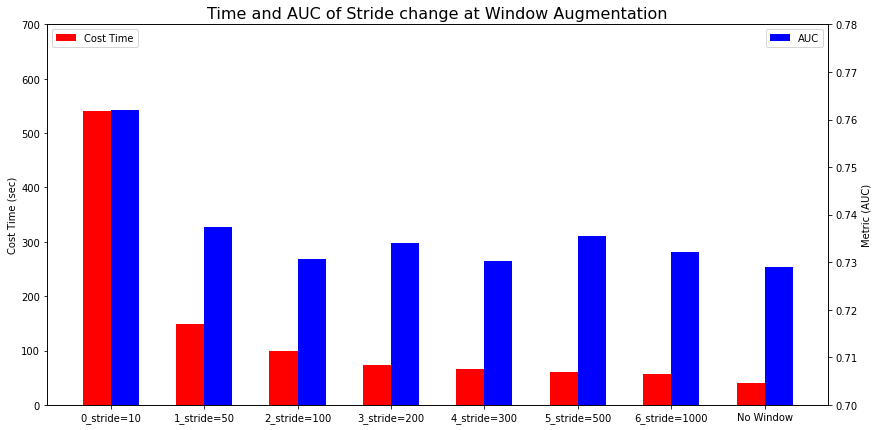

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(14,7))

ax1.set_title('Time and AUC of Stride change at Window Augmentation', fontsize=16)

# Time
plt.bar(window_df['experiment_tag'],
        window_df['time_total_s'],
        color='red',
        width=-0.3, align='edge',
        label='Cost Time')
ax1.set_ylim(0, 700)
plt.ylabel('Cost Time (sec)')
ax1.legend(loc=2)

# AUC
ax2 = ax1.twinx()
plt.bar(window_df['experiment_tag'],
        window_df['auc'],
        color='blue',
        width=0.3, align='edge',
        label='AUC')
plt.ylabel('Metric (AUC)')

ax2.grid(False)
ax2.set_ylim(0.7, 0.78)
ax2.legend()

plt.show()

### 🌿 Shuffle
> window augmentation을 적용한 이후에 shuffle이 적용된다

![shuffle](https://github.com/IllgamhoDuck/ML_Pipeline/blob/main/images/shuffle%20augmentation.png?raw=true)

In [ ]:
from ray import tune

# Window Augmentation 적용
args.window = True
args.shuffle = True

# seed 설정 
seed_everything(args.seed)

def objective_function(config):
    """
    config 예시 {'lr': 0.0001, 'n_layers': 1}
    """
    # args가 dict으로 건네지기 때문에 easydict으로 바꿔준다
    args = config['args']
    
    # 하이퍼파라메타 값 변경
    args.shuffle_n = config['shuffle_n']

    # seed 설정 - pickle serialize 불가로 사용 중지
    # seed_everything(args.seed)

    report = run(args, train_data, valid_data)

    best_auc = report['best_auc']

    return best_auc

def training_function(config):
    # auc 계산
    best_auc = objective_function(config)

    # Feed the score back back to Tune.
    tune.report(auc=best_auc)

gpus_per_trial = 1
analysis = tune.run(training_function,
                    config={"shuffle_n": tune.grid_search([1, 2, 3, 4, 5, 6, 7]),
                            "args": args},
                    resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
                    verbose=2)

print("Best config: ", analysis.get_best_config(metric="auc", mode="max"))

# 값 원상복구
args.window = False
args.shuffle = False
args.shuffle_n = 2

2021-04-18 17:30:22,187	WARNING worker.py:1107 -- Warning: The actor ImplicitFunc has size 81662983 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2021-04-18 17:30:22,286	WARNING util.py:152 -- The `start_trial` operation took 1.679 s, which may be a performance bottleneck.


(pid=7648) 2021-04-18 17:30:24.647571: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=7648) Data Augmentation applied. Train data 5209 -> 8989
(pid=7648) 
(pid=7648) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_bf78a_00000 reported auc=0.7271569579209873 with parameters={'shuffle_n': 1, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': True, 'stride': 300, 'shuffle': True, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'Tfixup': False, 'layer_norm': True, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912, 'total_steps': 810, 'warmup_steps': 81}}.


(pid=7648) 
Trial training_function_bf78a_00000 completed. Last result: auc=0.7271569579209873


(pid=7648) Error in atexit._run_exitfuncs:
(pid=7648) Traceback (most recent call last):
(pid=7648)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=7648)     self._writeout_input_cache(conn)
(pid=7648)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=7648)     (self.session_number,)+line)
(pid=7648) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140557970695936 and this is thread id 140564903511936.
2021-04-18 17:31:33,504	WARNING util.py:152 -- The `start_trial` operation took 1.183 s, which may be a performance bottleneck.
(pid=7690) 2021-04-18 17:31:35.822480: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=7690) Data Augmentation applied. Train data 5209 -> 10542
(pid=7690) 
(pid=7690) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_bf78a_00001 reported auc=0.7296547804765746 with parameters={'shuffle_n': 2, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': True, 'stride': 300, 'shuffle': True, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'Tfixup': False, 'layer_norm': True, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912, 'total_steps': 810, 'warmup_steps': 81}}.
(pid=7690) 


Trial training_function_bf78a_00001 completed. Last result: auc=0.7296547804765746


2021-04-18 17:32:54,554	WARNING util.py:152 -- The `start_trial` operation took 1.026 s, which may be a performance bottleneck.
(pid=7729) 2021-04-18 17:32:56.858906: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=7729) Data Augmentation applied. Train data 5209 -> 12095
(pid=7729) 
(pid=7729) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_bf78a_00002 reported auc=0.7311480002125121 with parameters={'shuffle_n': 3, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': True, 'stride': 300, 'shuffle': True, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'Tfixup': False, 'layer_norm': True, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912, 'total_steps': 810, 'warmup_steps': 81}}.


(pid=7729) 
Trial training_function_bf78a_00002 completed. Last result: auc=0.7311480002125121


(pid=7729) Error in atexit._run_exitfuncs:
(pid=7729) Traceback (most recent call last):
(pid=7729)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=7729)     self._writeout_input_cache(conn)
(pid=7729)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=7729)     (self.session_number,)+line)
(pid=7729) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140173279074048 and this is thread id 140180211890048.
2021-04-18 17:34:25,786	WARNING util.py:152 -- The `start_trial` operation took 1.218 s, which may be a performance bottleneck.
(pid=7776) 2021-04-18 17:34:28.142445: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=7776) Data Augmentation applied. Train data 5209 -> 13648
(pid=7776) 
(pid=7776) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_bf78a_00003 reported auc=0.7219930740363298 with parameters={'shuffle_n': 4, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': True, 'stride': 300, 'shuffle': True, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'Tfixup': False, 'layer_norm': True, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912, 'total_steps': 810, 'warmup_steps': 81}}.
(pid=7776) 


Trial training_function_bf78a_00003 completed. Last result: auc=0.7219930740363298


(pid=7776) Error in atexit._run_exitfuncs:
(pid=7776) Traceback (most recent call last):
(pid=7776)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=7776)     self._writeout_input_cache(conn)
(pid=7776)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=7776)     (self.session_number,)+line)
(pid=7776) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 139656073570048 and this is thread id 139663006386048.
2021-04-18 17:36:07,535	WARNING util.py:152 -- The `start_trial` operation took 1.214 s, which may be a performance bottleneck.
(pid=7823) 2021-04-18 17:36:09.880289: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=7823) Data Augmentation applied. Train data 5209 -> 15201
(pid=7823) 
(pid=7823) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
(pid=7823) 
Trial training_function_bf78a_00004 reported auc=0.7149455598648294 with parameters={'shuffle_n': 5, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': True, 'stride': 300, 'shuffle': True, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'Tfixup': False, 'layer_norm': True, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912, 'total_steps': 810, 'warmup_steps': 81}}.


Trial training_function_bf78a_00004 completed. Last result: auc=0.7149455598648294


(pid=7823) Error in atexit._run_exitfuncs:
(pid=7823) Traceback (most recent call last):
(pid=7823)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=7823)     self._writeout_input_cache(conn)
(pid=7823)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=7823)     (self.session_number,)+line)
(pid=7823) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140423170123520 and this is thread id 140430102939520.
2021-04-18 17:37:59,163	WARNING util.py:152 -- The `start_trial` operation took 1.204 s, which may be a performance bottleneck.
(pid=7874) 2021-04-18 17:38:01.505780: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=7874) Data Augmentation applied. Train data 5209 -> 16754
(pid=7874) 
(pid=7874) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_bf78a_00005 reported auc=0.7210536738035327 with parameters={'shuffle_n': 6, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': True, 'stride': 300, 'shuffle': True, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'Tfixup': False, 'layer_norm': True, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912, 'total_steps': 810, 'warmup_steps': 81}}.
(pid=7874) 


Trial training_function_bf78a_00005 completed. Last result: auc=0.7210536738035327


(pid=7874) Error in atexit._run_exitfuncs:
(pid=7874) Traceback (most recent call last):
(pid=7874)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=7874)     self._writeout_input_cache(conn)
(pid=7874)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=7874)     (self.session_number,)+line)
(pid=7874) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140218516739840 and this is thread id 140225449555840.
2021-04-18 17:40:00,676	WARNING util.py:152 -- The `start_trial` operation took 1.189 s, which may be a performance bottleneck.
(pid=7925) 2021-04-18 17:40:02.606456: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=7925) Data Augmentation applied. Train data 5209 -> 18307
(pid=7925) 
(pid=7925) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_bf78a_00006 reported auc=0.718368293189469 with parameters={'shuffle_n': 7, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': True, 'stride': 300, 'shuffle': True, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'Tfixup': False, 'layer_norm': True, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912, 'total_steps': 810, 'warmup_steps': 81}}.
(pid=7925) 


Trial training_function_bf78a_00006 completed. Last result: auc=0.718368293189469


2021-04-18 17:42:11,090	INFO tune.py:450 -- Total run time: 712.15 seconds (711.15 seconds for the tuning loop).


Best config:  {'shuffle_n': 3, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': True, 'stride': 300, 'shuffle': True, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'Tfixup': False, 'layer_norm': True, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'bert', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912, 'total_steps': 810, 'warmup_steps': 81}}


In [ ]:
shuffle_df = analysis.results_df[['experiment_tag', 'time_total_s', 'auc']]

# 비교할 대상으로 shuffle이 지정안된 window slidding 데이터를 가져온다
no_shuffle = window_df.query('experiment_tag == "4_stride=300"')
no_shuffle['experiment_tag'] = "No shuffle"

shuffle_df = shuffle_df.append(no_shuffle)
shuffle_df

experiment_tag  time_total_s       auc
bf78a_00000  0_shuffle_n=1     66.573944  0.727157
bf78a_00001  1_shuffle_n=2     76.619014  0.729655
bf78a_00002  2_shuffle_n=3     86.615219  0.731148
bf78a_00003  3_shuffle_n=4     97.042313  0.721993
bf78a_00004  4_shuffle_n=5    106.987992  0.714946
bf78a_00005  5_shuffle_n=6    116.891385  0.721054
bf78a_00006  6_shuffle_n=7    127.357996  0.718368
4               No shuffle     66.477639  0.730312

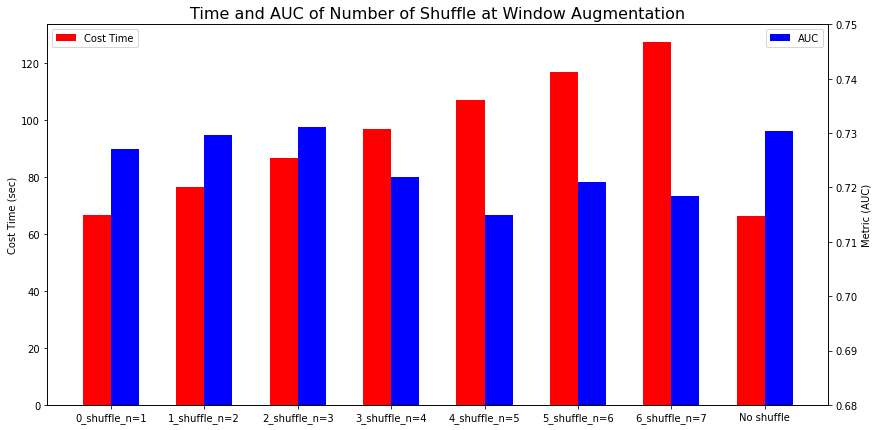

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(14,7))

ax1.set_title('Time and AUC of Number of Shuffle at Window Augmentation', fontsize=16)

# Time
plt.bar(shuffle_df['experiment_tag'],
        shuffle_df['time_total_s'],
        color='red',
        width=-0.3, align='edge',
        label='Cost Time')

plt.ylabel('Cost Time (sec)')
ax1.legend(loc=2)

# AUC
ax2 = ax1.twinx()
plt.bar(shuffle_df['experiment_tag'],
        shuffle_df['auc'],
        color='blue',
        width=0.3, align='edge',
        label='AUC')
plt.ylabel('Metric (AUC)')

ax2.grid(False)
ax2.set_ylim(0.68, 0.75)
ax2.legend(loc=1)

plt.show()

## 🏹 optimizer와 scheduler
> 일반적으로 transformer에서는 optimizer로 Adam, AdamW scheduler로 쌍둥이처럼 따라다니는 warmup이 많이 사용된다. optimizer와 scheduler의 차이가 성능과 gradient 분포에 어떠한 변화를 가져오는지 직접 느껴보자.

- Adam with Plateau
- Adam with Warmup
- AdamW with Plateau
- AdamW with Warmup


![gradient distribution](https://flonelin.files.wordpress.com/2019/09/image-30.png?w=768)

출처
- [On The Variance Of The Adaptive Learning
Rate And Beyond](https://arxiv.org/pdf/1908.03265.pdf)

### 🌿 Adam with Plateau

In [ ]:
# seed 설정 
seed_everything(args.seed)

# Gradient 분포도 체크할 것이므로 True로 표시
report = run(args, train_data, valid_data, gradient=True)
total_time, auc, acc = time_auc(report)

print(f"Cost Time : {total_time} sec, best AUC : {auc}")

Cost Time : 84.62382531166077 sec, best AUC : 0.7290357583865821


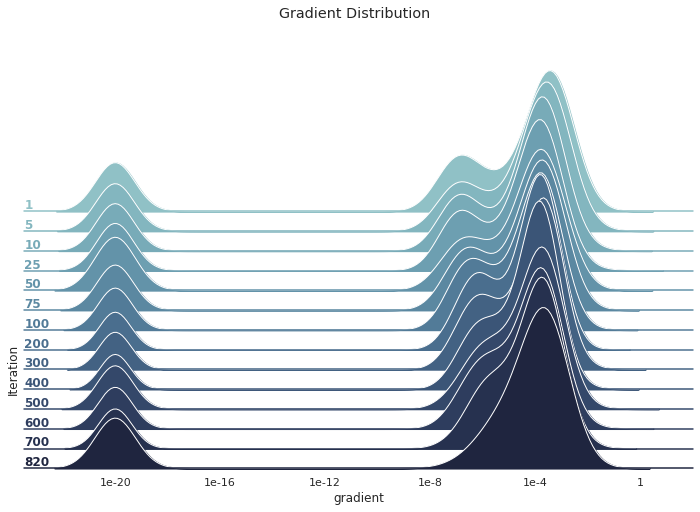

In [ ]:
iteration_idx = [1, 5, 10, 25, 50, 75, 100, 200, 300, 400, 500, 600, 700, 820]
module_idx = []
sample_n = 1000
filter_iteration_labels = [1, 5, 10, 25, 50, 75, 100, 200, 300, 400, 500, 600, 700, 820]

grad_df = gradient_distribution(report, iteration_idx, module_idx, sample_n, filter_iteration_labels)

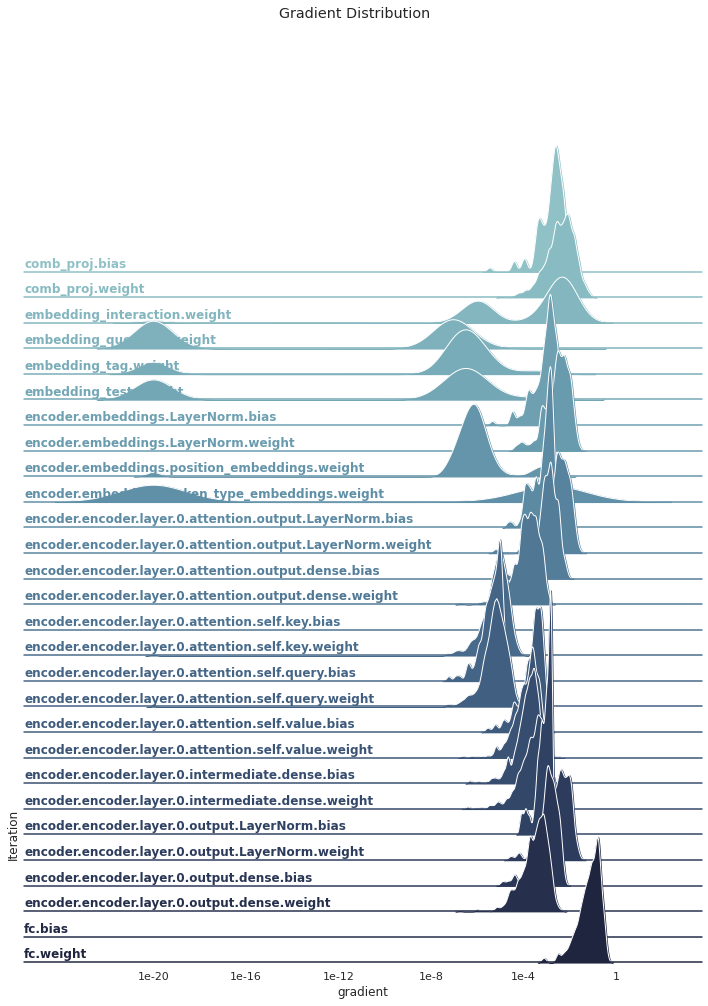

In [ ]:
# 1번째 iteration만 분석
grad_df = gradient_distribution(report, iteration_idx=1, sample_n=1000, one_iteration_only=True)

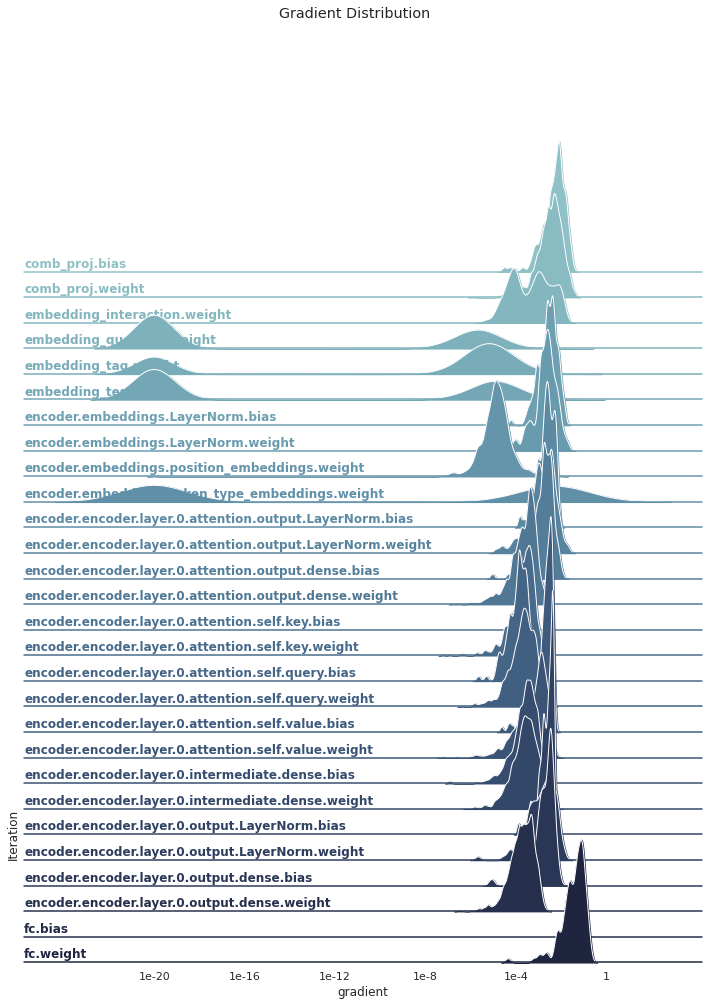

In [ ]:
# 820번째 iteration만 분석
grad_df = gradient_distribution(report, iteration_idx=820, sample_n=1000, one_iteration_only=True)

### 🌿 Adam with Warmup

In [ ]:
# warmup 적용
args.scheduler = 'linear_warmup'

# seed 설정 
seed_everything(args.seed)

# Gradient 분포도 체크할 것이므로 True로 표시
report = run(args, train_data, valid_data, gradient=True)
total_time, auc, acc = time_auc(report)

print(f"Cost Time : {total_time} sec, best AUC : {auc}")

# 값 원상복구
args.scheduler = 'plateau'


Cost Time : 83.8517816066742 sec, best AUC : 0.6773872598975113


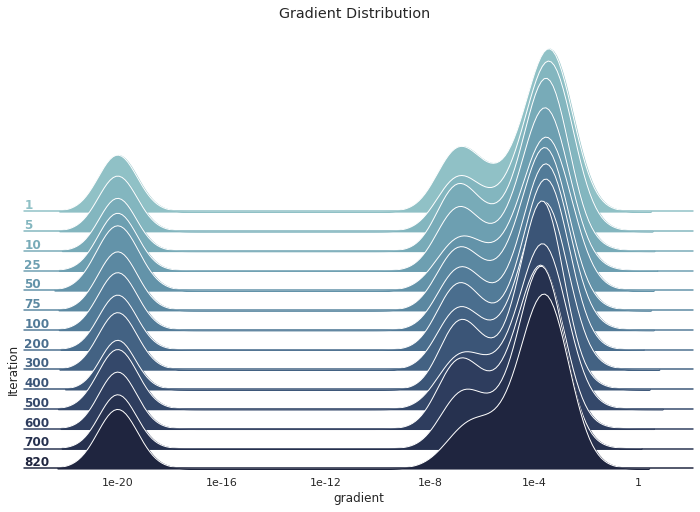

In [ ]:
iteration_idx = [1, 5, 10, 25, 50, 75, 100, 200, 300, 400, 500, 600, 700, 820]
module_idx = []
sample_n = 1000
filter_iteration_labels = [1, 5, 10, 25, 50, 75, 100, 200, 300, 400, 500, 600, 700, 820]

grad_df = gradient_distribution(report, iteration_idx, module_idx, sample_n, filter_iteration_labels)

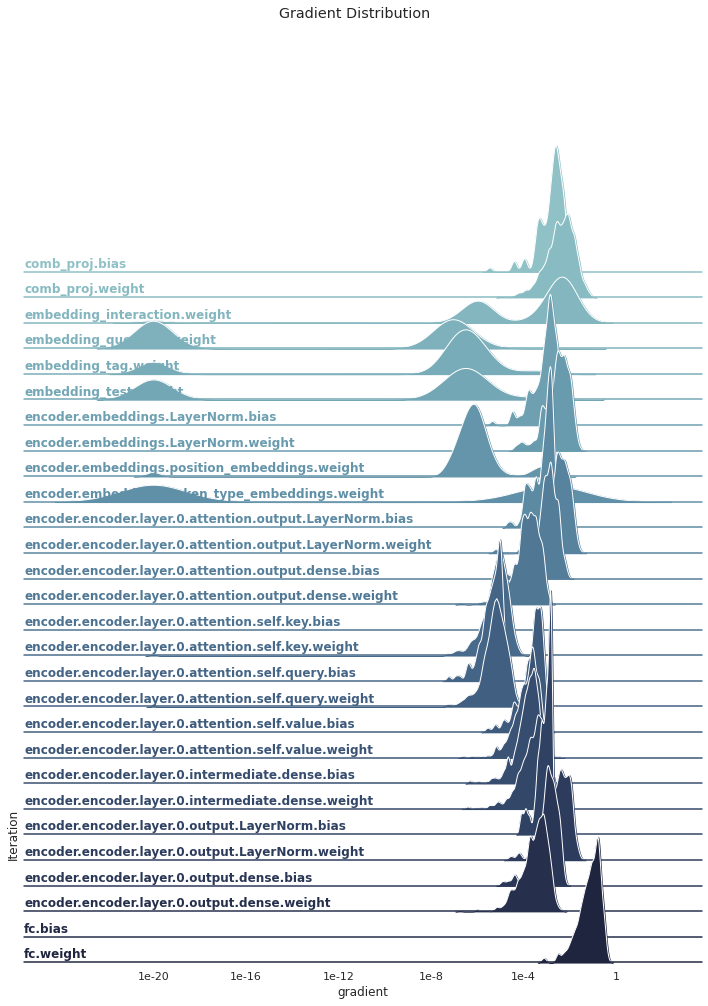

In [ ]:
# 1번째 iteration만 분석
grad_df = gradient_distribution(report, iteration_idx=1, sample_n=1000, one_iteration_only=True)

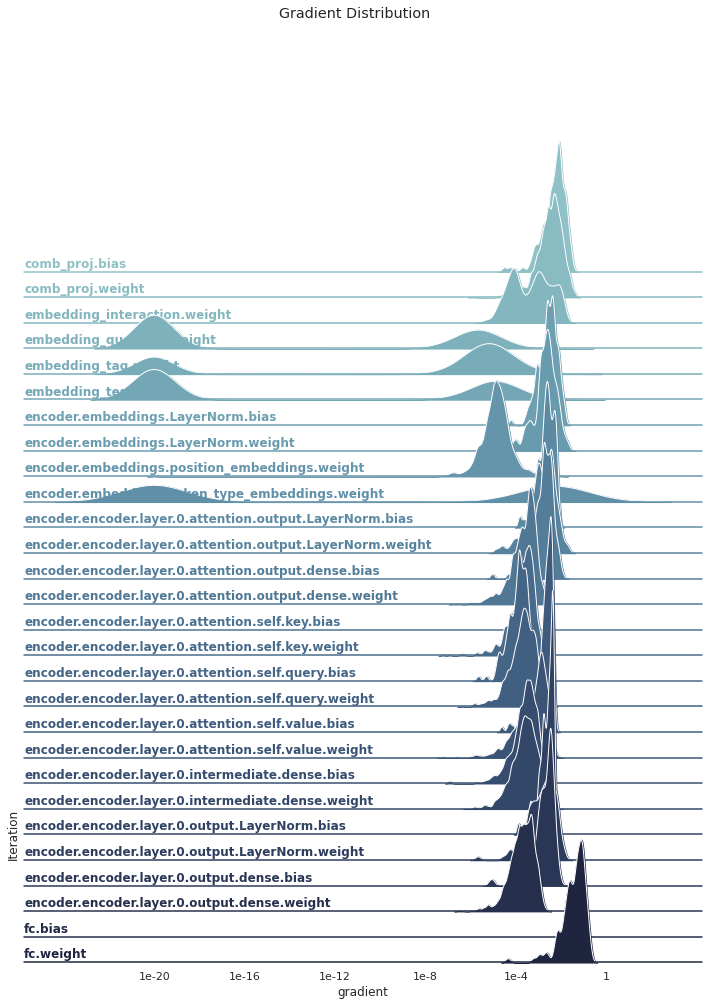

In [ ]:
# 820번째 iteration만 분석
grad_df = gradient_distribution(report, iteration_idx=820, sample_n=1000, one_iteration_only=True)

### 🌿 AdamW with Plateau

In [ ]:
# AdamW적용
args.optimizer = 'adamW'

# seed 설정 
seed_everything(args.seed)

# Gradient 분포도 체크할 것이므로 True로 표시
report = run(args, train_data, valid_data, gradient=True)
total_time, auc, acc = time_auc(report)

print(f"Cost Time : {total_time} sec, best AUC : {auc}")

# 값 원상복구
args.optimizer = 'adam'


Cost Time : 84.11988592147827 sec, best AUC : 0.7290357583865821


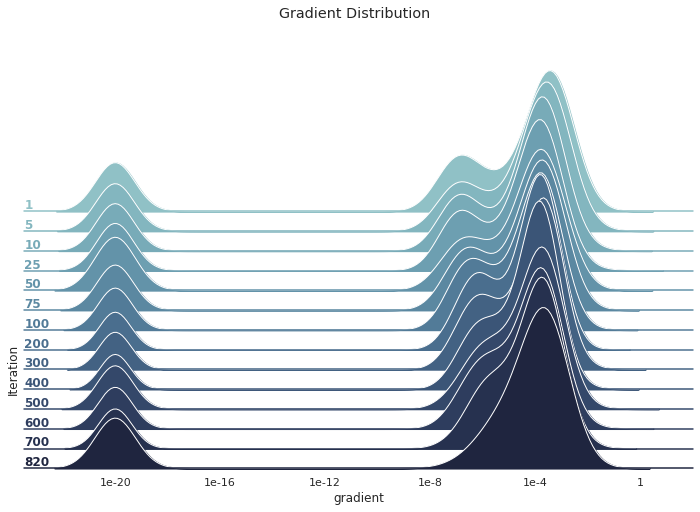

In [ ]:
iteration_idx = [1, 5, 10, 25, 50, 75, 100, 200, 300, 400, 500, 600, 700, 820]
module_idx = []
sample_n = 1000
filter_iteration_labels = [1, 5, 10, 25, 50, 75, 100, 200, 300, 400, 500, 600, 700, 820]

grad_df = gradient_distribution(report, iteration_idx, module_idx, sample_n, filter_iteration_labels)

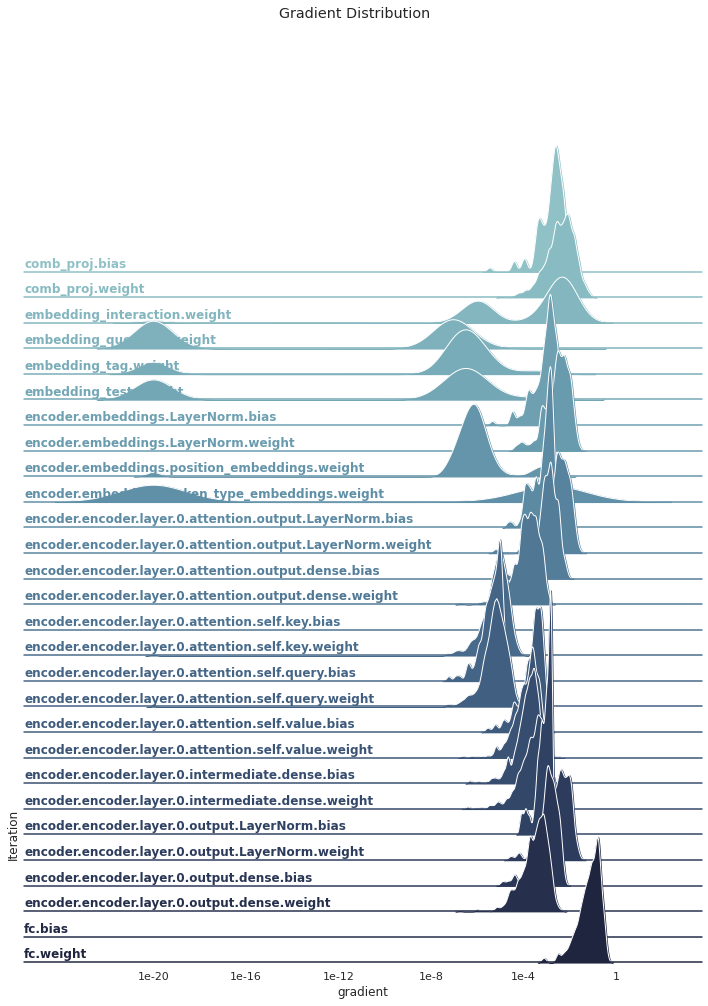

In [ ]:
# 1번째 iteration만 분석
grad_df = gradient_distribution(report, iteration_idx=1, sample_n=1000, one_iteration_only=True)

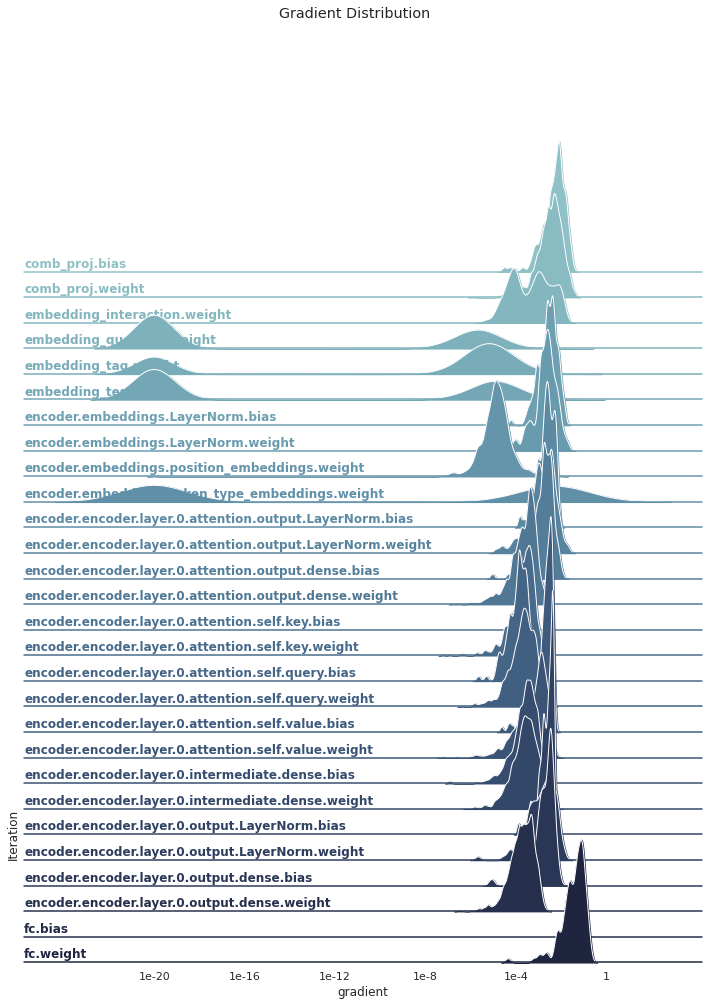

In [ ]:
# 820번째 iteration만 분석
grad_df = gradient_distribution(report, iteration_idx=820, sample_n=1000, one_iteration_only=True)

### 🌿 AdamW with Warmup

In [ ]:
# warmup 적용
args.optimizer = 'adamW'
args.scheduler = 'linear_warmup'

# seed 설정 
seed_everything(args.seed)

# Gradient 분포도 체크할 것이므로 True로 표시
report = run(args, train_data, valid_data, gradient=True)
total_time, auc, acc = time_auc(report)

print(f"Cost Time : {total_time} sec, best AUC : {auc}")

# 값 원상복구
args.optimizer = 'adam'
args.scheduler = 'plateau'


Cost Time : 84.16937041282654 sec, best AUC : 0.6773872598975113


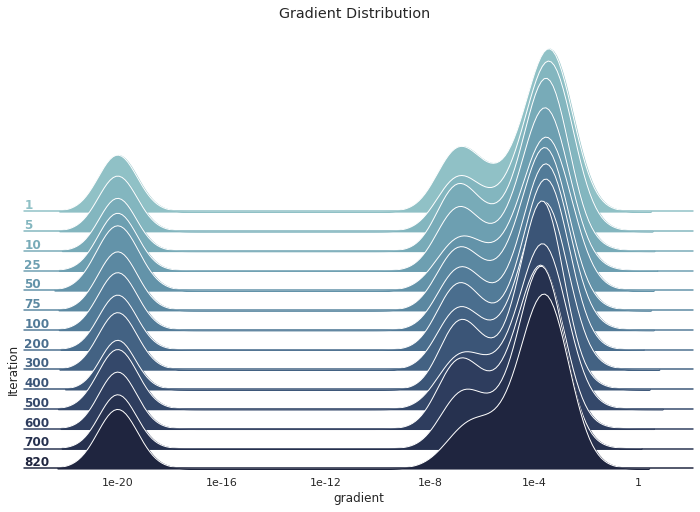

In [ ]:
iteration_idx = [1, 5, 10, 25, 50, 75, 100, 200, 300, 400, 500, 600, 700, 820]
module_idx = []
sample_n = 1000
filter_iteration_labels = [1, 5, 10, 25, 50, 75, 100, 200, 300, 400, 500, 600, 700, 820]

grad_df = gradient_distribution(report, iteration_idx, module_idx, sample_n, filter_iteration_labels)

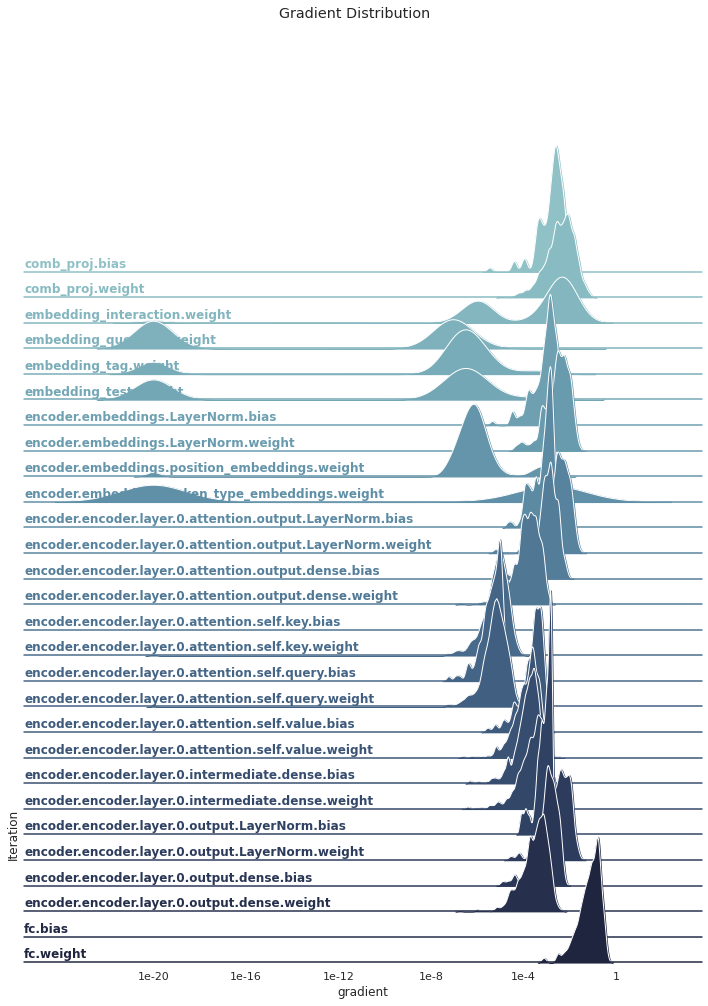

In [ ]:
# 1번째 iteration만 분석
grad_df = gradient_distribution(report, iteration_idx=1, sample_n=1000, one_iteration_only=True)

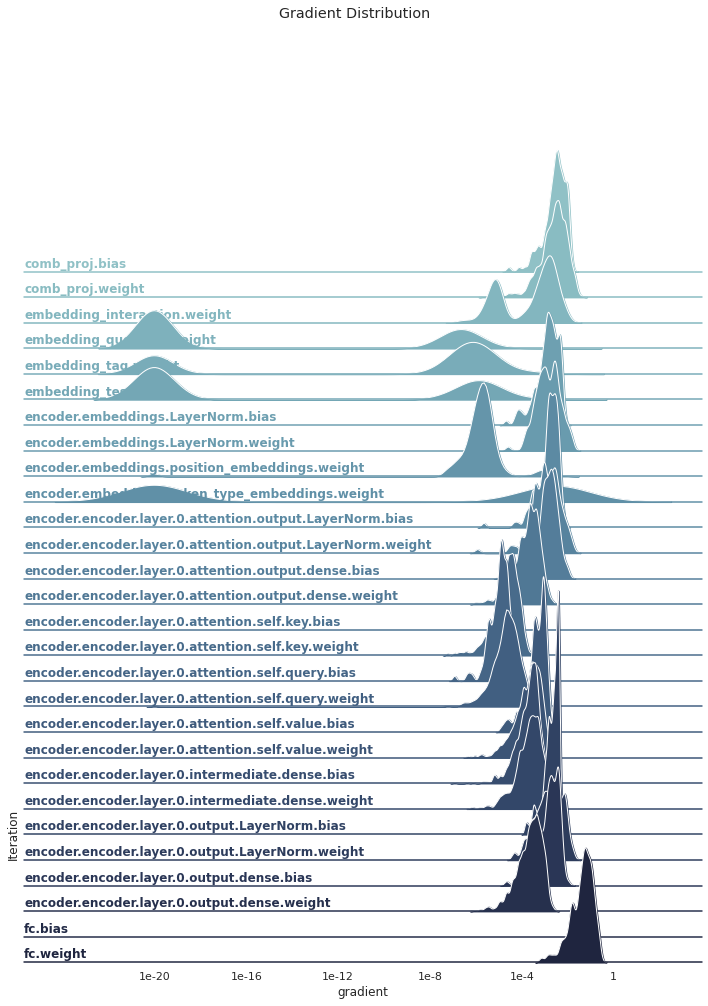

In [ ]:
# 820번째 iteration만 분석
grad_df = gradient_distribution(report, iteration_idx=820, sample_n=1000, one_iteration_only=True)

# 🎯 LSTM Tuning

- LSTM의 Hyperparameter가 변경되었을 때 모델과 성능에 끼치는 영향들

## LSTM의 Hyperparameter가 변경되었을 때 모델과 성능에 끼치는 영향들
> 우리는 LSTM의 하이퍼파라메타를 변경해보며 학습시간 plot, 성능변화 plot을 그려 어떤 식으로 변화는지 관찰해볼 것이다! 
- 학습속도에는 어떤 arg가 영향을 많이 미치는지
- 성능에는 어떤 arg가 영향을 많이 미치는지
- 학습 속도와 성능 Trade-off를 어떻게 조절해야 하는지

- layer 수
- embedding dimension
- seq_len

### 🌿 layer 수
> layer 수가 증가할수록 모델의 복잡도가 크게 증가하고 훈련에 필요한 데이터가 많아지기 때문에 Transformer가 아닌 LSTM도 DKT에서는 1개만 사용하는 것이 보편적이다. 우리는 여기서 layer 숫자의 변화에 따라 성능의 변화를 살펴본다.

In [ ]:
from ray import tune

# lstm
args.model = 'lstm'

def objective_function(config):
    """
    config 예시 {'lr': 0.0001, 'n_layers': 1}
    """
    # args가 dict으로 건네지기 때문에 easydict으로 바꿔준다
    args = config['args']
    
    # 하이퍼파라메타 값 변경
    args.n_layers = config['n_layers']

    # seed 설정 - pickle serialize 불가로 사용 중지
    # seed_everything(args.seed)

    report = run(args, train_data, valid_data, gradient=False)

    best_auc = report['best_auc']

    return best_auc

def training_function(config):
    # auc 계산
    best_auc = objective_function(config)

    # Feed the score back back to Tune.
    tune.report(auc=best_auc)

gpus_per_trial = 1
analysis = tune.run(training_function,
                    config={"n_layers": tune.grid_search([1, 2, 3, 4, 5]),
                            "args": args},
                    resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
                    verbose=2)

print("Best config: ", analysis.get_best_config(metric="auc", mode="max"))

# 값 원상복구
args.n_layers = 1
args.model = 'bert'

2021-04-15 14:02:21,029	WARNING worker.py:1107 -- Warning: The actor ImplicitFunc has size 81662718 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2021-04-15 14:02:21,139	WARNING util.py:152 -- The `start_trial` operation took 1.919 s, which may be a performance bottleneck.


(pid=8714) 2021-04-15 14:02:23.703601: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=8714) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_30b60_00000 reported auc=0.7567291484542156 with parameters={'n_layers': 1, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'Tfixup': False, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'lstm', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912, 'total_steps': 810, 'warmup_steps': 81, 'n_iteration': 820}}.


Trial training_function_30b60_00000 completed. Last result: auc=0.7567291484542156
(pid=8714) 


(pid=8714) Error in atexit._run_exitfuncs:
(pid=8714) Traceback (most recent call last):
(pid=8714)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=8714)     self._writeout_input_cache(conn)
(pid=8714)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=8714)     (self.session_number,)+line)
(pid=8714) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140429111248640 and this is thread id 140436060579712.
2021-04-15 14:02:59,008	WARNING util.py:152 -- The `start_trial` operation took 1.483 s, which may be a performance bottleneck.
(pid=8746) 2021-04-15 14:03:01.606147: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=8746) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_30b60_00001 reported auc=0.7590708067894408 with parameters={'n_layers': 2, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'Tfixup': False, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'lstm', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912, 'total_steps': 810, 'warmup_steps': 81, 'n_iteration': 820}}.
(pid=8746) 


Trial training_function_30b60_00001 completed. Last result: auc=0.7590708067894408


(pid=8746) Error in atexit._run_exitfuncs:
(pid=8746) Traceback (most recent call last):
(pid=8746)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=8746)     self._writeout_input_cache(conn)
(pid=8746)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=8746)     (self.session_number,)+line)
(pid=8746) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140513911015168 and this is thread id 140520860346240.
2021-04-15 14:03:43,309	WARNING util.py:152 -- The `start_trial` operation took 1.472 s, which may be a performance bottleneck.
(pid=8781) 2021-04-15 14:03:45.968834: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=8781) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_30b60_00002 reported auc=0.7617268059909104 with parameters={'n_layers': 3, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'Tfixup': False, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'lstm', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912, 'total_steps': 810, 'warmup_steps': 81, 'n_iteration': 820}}.


Trial training_function_30b60_00002 completed. Last result: auc=0.7617268059909104
(pid=8781) 


(pid=8781) Error in atexit._run_exitfuncs:
(pid=8781) Traceback (most recent call last):
(pid=8781)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=8781)     self._writeout_input_cache(conn)
(pid=8781)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=8781)     (self.session_number,)+line)
(pid=8781) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140126765238016 and this is thread id 140133714569088.
2021-04-15 14:04:37,997	WARNING util.py:152 -- The `start_trial` operation took 1.506 s, which may be a performance bottleneck.
(pid=8819) 2021-04-15 14:04:40.549682: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=8819) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_30b60_00003 reported auc=0.7557889432512103 with parameters={'n_layers': 4, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'Tfixup': False, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'lstm', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912, 'total_steps': 810, 'warmup_steps': 81, 'n_iteration': 820}}.


(pid=8819) 
Trial training_function_30b60_00003 completed. Last result: auc=0.7557889432512103


(pid=8819) Error in atexit._run_exitfuncs:
(pid=8819) Traceback (most recent call last):
(pid=8819)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=8819)     self._writeout_input_cache(conn)
(pid=8819)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=8819)     (self.session_number,)+line)
(pid=8819) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140662495627008 and this is thread id 140669444958080.
2021-04-15 14:05:42,504	WARNING util.py:152 -- The `start_trial` operation took 1.559 s, which may be a performance bottleneck.
(pid=8858) 2021-04-15 14:05:44.577226: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=8858) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_30b60_00004 reported auc=0.7443772830967527 with parameters={'n_layers': 5, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'Tfixup': False, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'lstm', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912, 'total_steps': 810, 'warmup_steps': 81, 'n_iteration': 820}}.
(pid=8858) 


Trial training_function_30b60_00004 completed. Last result: auc=0.7443772830967527


2021-04-15 14:06:53,979	INFO tune.py:450 -- Total run time: 276.62 seconds (275.48 seconds for the tuning loop).


Best config:  {'n_layers': 3, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'Tfixup': False, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'lstm', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912, 'total_steps': 810, 'warmup_steps': 81, 'n_iteration': 820}}


In [ ]:
layer_df = analysis.results_df[['experiment_tag', 'time_total_s', 'auc']]
layer_df

experiment_tag  time_total_s       auc
trial_id                                          
30b60_00000   0_n_layers=1     31.915735  0.756729
30b60_00001   1_n_layers=2     38.303139  0.759071
30b60_00002   2_n_layers=3     48.542838  0.761727
30b60_00003   3_n_layers=4     58.434070  0.755789
30b60_00004   4_n_layers=5     67.405290  0.744377

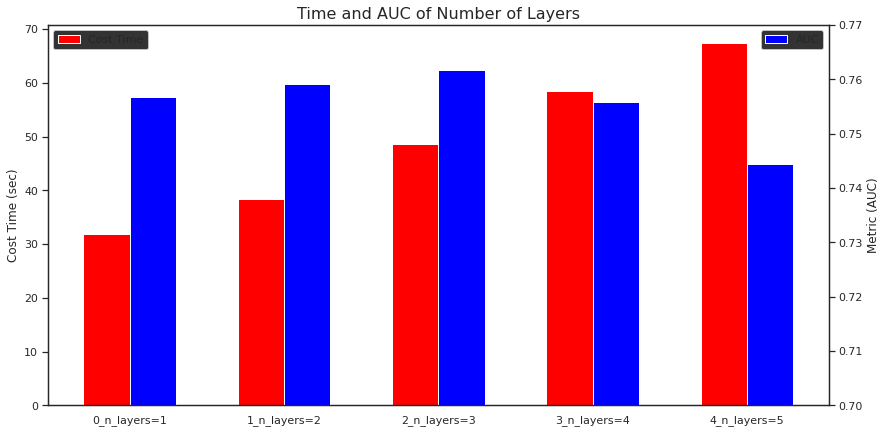

In [ ]:
fig, ax1 = plt.subplots(figsize=(14,7))

ax1.set_title('Time and AUC of Number of Layers', fontsize=16)

# Time
plt.bar(layer_df['experiment_tag'],
        layer_df['time_total_s'],
        color='red',
        width=-0.3, align='edge',
        label='Cost Time')
plt.ylabel('Cost Time (sec)')
ax1.legend()

# AUC
ax2 = ax1.twinx()
plt.bar(layer_df['experiment_tag'],
        layer_df['auc'],
        color='blue',
        width=0.3, align='edge',
        label='AUC')
plt.ylabel('Metric (AUC)')

ax2.grid(False)
ax2.set_ylim(0.7, 0.77)
ax2.legend()

plt.show()

### 🌿 embedding dimension
> LSTM에 입력될 sequence의 embedding dimension이 커질수록 더욱 많은 정보량을 표현할 수 있다. 하지만 그만큼 데이터가 많이 요구된다. 우리는 여기서 embedding dimension에 따른 성능의 변화를 살펴본다.

In [ ]:
from ray import tune

# lstm
args.model = 'lstm'

def objective_function(config):
    """
    config 예시 {'lr': 0.0001, 'n_layers': 1}
    """
    # args가 dict으로 건네지기 때문에 easydict으로 바꿔준다
    args = config['args']
    
    # 하이퍼파라메타 값 변경
    args.hidden_dim = config['hidden_dim']

    # seed 설정 - pickle serialize 불가로 사용 중지
    # seed_everything(args.seed)

    report = run(args, train_data, valid_data, gradient=False)

    best_auc = report['best_auc']

    return best_auc

def training_function(config):
    # auc 계산
    best_auc = objective_function(config)

    # Feed the score back back to Tune.
    tune.report(auc=best_auc)

gpus_per_trial = 1
analysis = tune.run(training_function,
                    config={"hidden_dim": tune.grid_search([16, 32, 64, 128, 256, 512, 1024]),
                            "args": args},
                    resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
                    verbose=2)

print("Best config: ", analysis.get_best_config(metric="auc", mode="max"))

# 값 원상복구
args.hidden_dim = 128
args.model = 'bert'

In [ ]:
embed_df = analysis.results_df[['experiment_tag', 'time_total_s', 'auc']]
embed_df

experiment_tag  time_total_s       auc
trial_id                                              
f76e7_00000    0_hidden_dim=16     24.870730  0.744856
f76e7_00001    1_hidden_dim=32     24.637076  0.748782
f76e7_00002    2_hidden_dim=64     26.379992  0.756979
f76e7_00003   3_hidden_dim=128     31.518133  0.768301
f76e7_00004   4_hidden_dim=256     44.249960  0.774589
f76e7_00005   5_hidden_dim=512     79.669243  0.777145
f76e7_00006  6_hidden_dim=1024    197.642486  0.781599

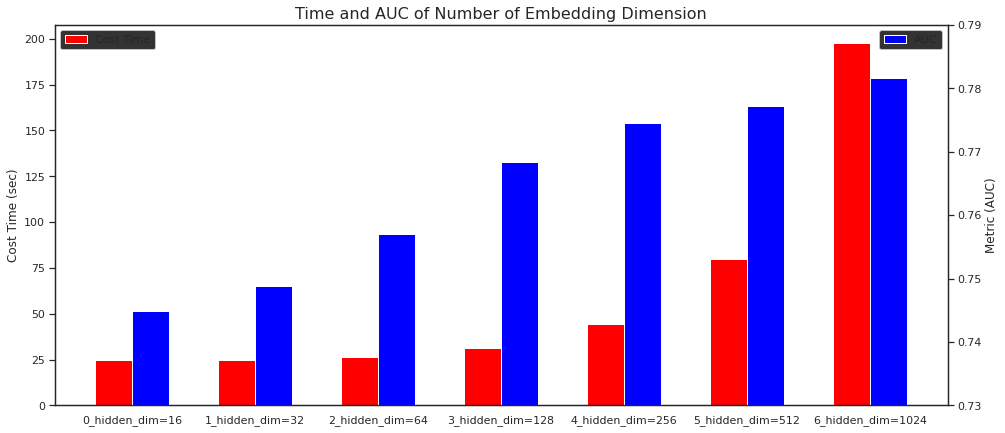

In [ ]:
fig, ax1 = plt.subplots(figsize=(16,7))

ax1.set_title('Time and AUC of Number of Embedding Dimension', fontsize=16)

# Time
plt.bar(embed_df['experiment_tag'],
        embed_df['time_total_s'],
        color='red',
        width=-0.3, align='edge',
        label='Cost Time')
plt.ylabel('Cost Time (sec)')
ax1.legend()

# AUC
ax2 = ax1.twinx()
plt.bar(embed_df['experiment_tag'],
        embed_df['auc'],
        color='blue',
        width=0.3, align='edge',
        label='AUC')
plt.ylabel('Metric (AUC)')

ax2.grid(False)
ax2.set_ylim(0.73, 0.79)
ax2.legend()

plt.show()

### 🌿 seq_len

In [ ]:
from ray import tune

# lstm
args.model = 'lstm'

def objective_function(config):
    """
    config 예시 {'lr': 0.0001, 'n_layers': 1}
    """
    # args가 dict으로 건네지기 때문에 easydict으로 바꿔준다
    args = config['args']
    
    # 하이퍼파라메타 값 변경
    args.max_seq_len = config['max_seq_len']

    # seed 설정 - pickle serialize 불가로 사용 중지
    # seed_everything(args.seed)

    report = run(args, train_data, valid_data)

    best_auc = report['best_auc']

    return best_auc

def training_function(config):
    # auc 계산
    best_auc = objective_function(config)

    # Feed the score back back to Tune.
    tune.report(auc=best_auc)

gpus_per_trial = 1
analysis = tune.run(training_function,
                    config={"max_seq_len": tune.grid_search([10, 50, 100, 200, 256, 512, 1024, 2048]),
                            "args": args},
                    resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
                    verbose=2)

print("Best config: ", analysis.get_best_config(metric="auc", mode="max"))

# 값 원상복구
args.max_seq_len = 300
args.model = 'bert'

2021-04-26 13:47:59,450	INFO services.py:1269 -- View the Ray dashboard at http://127.0.0.1:8265
2021-04-26 13:48:01,405	WARNING function_runner.py:545 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2021-04-26 13:48:10,283	WARNING worker.py:1115 -- Warning: The actor ImplicitFunc has size 81930502 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


(pid=390) 2021-04-26 13:48:13.084076: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=390) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_05541_00000 reported auc=0.7582320278326499 with parameters={'max_seq_len': 10, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'Tfixup': False, 'layer_norm': True, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'lstm', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.


(pid=390) 
Trial training_function_05541_00000 completed. Last result: auc=0.7582320278326499


(pid=390) Error in atexit._run_exitfuncs:
(pid=390) Traceback (most recent call last):
(pid=390)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=390)     self._writeout_input_cache(conn)
(pid=390)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=390)     (self.session_number,)+line)
(pid=390) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 139668728436480 and this is thread id 139675668457344.
(pid=389) 2021-04-26 13:48:34.648547: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=389) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_05541_00001 reported auc=0.7646814491395674 with parameters={'max_seq_len': 50, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'Tfixup': False, 'layer_norm': True, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'lstm', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.
(pid=389) 


Trial training_function_05541_00001 completed. Last result: auc=0.7646814491395674


(pid=389) Error in atexit._run_exitfuncs:
(pid=389) Traceback (most recent call last):
(pid=389)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=389)     self._writeout_input_cache(conn)
(pid=389)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=389)     (self.session_number,)+line)
(pid=389) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140619220256512 and this is thread id 140626160277376.
(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=477) 2021-04-26 13:48:54.001514: I tensorfl

(pid=477) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_05541_00002 reported auc=0.7580412498933413 with parameters={'max_seq_len': 100, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'Tfixup': False, 'layer_norm': True, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'lstm', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.


(pid=477) 


2021-04-26 13:49:12,129	WARNING util.py:162 -- The `start_trial` operation took 0.577 s, which may be a performance bottleneck.


Trial training_function_05541_00002 completed. Last result: auc=0.7580412498933413


(pid=477) Error in atexit._run_exitfuncs:
(pid=477) Traceback (most recent call last):
(pid=477)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=477)     self._writeout_input_cache(conn)
(pid=477)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=477)     (self.session_number,)+line)
(pid=477) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140416295446272 and this is thread id 140423235467136.
2021-04-26 13:49:13,433	WARNING util.py:162 -- The `start_trial` operation took 1.295 s, which may be a performance bottleneck.
2021-04-26 13:49:14,063	WARNING util.py:162 -- The `start_trial` operation took 0.628 s, which may be a performance bottleneck.
(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were

(pid=505) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_05541_00003 reported auc=0.7653874080120294 with parameters={'max_seq_len': 200, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'Tfixup': False, 'layer_norm': True, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'lstm', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.
(pid=505) 


2021-04-26 13:49:38,129	WARNING util.py:162 -- The `start_trial` operation took 0.566 s, which may be a performance bottleneck.


Trial training_function_05541_00003 completed. Last result: auc=0.7653874080120294


(pid=505) Error in atexit._run_exitfuncs:
(pid=505) Traceback (most recent call last):
(pid=505)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=505)     self._writeout_input_cache(conn)
(pid=505)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=505)     (self.session_number,)+line)
(pid=505) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140699265234688 and this is thread id 140706205255552.
2021-04-26 13:49:39,443	WARNING util.py:162 -- The `start_trial` operation took 1.305 s, which may be a performance bottleneck.
(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update 

(pid=538) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_05541_00004 reported auc=0.7676203953691674 with parameters={'max_seq_len': 256, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'Tfixup': False, 'layer_norm': True, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'lstm', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.
(pid=538) 


2021-04-26 13:50:06,478	WARNING util.py:162 -- The `start_trial` operation took 0.558 s, which may be a performance bottleneck.
(pid=538) Error in atexit._run_exitfuncs:
(pid=538) Traceback (most recent call last):
(pid=538)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=538)     self._writeout_input_cache(conn)
(pid=538)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=538)     (self.session_number,)+line)
(pid=538) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140684420740864 and this is thread id 140691360761728.


Trial training_function_05541_00004 completed. Last result: auc=0.7676203953691674


2021-04-26 13:50:07,763	WARNING util.py:162 -- The `start_trial` operation took 1.276 s, which may be a performance bottleneck.
(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-04-26 13:50:08,413	WARNING util.py:162 -- The `start_trial` operation took 0.645 s, which may be a performance bottleneck.
(pid=566) 2021-04-26 13:50:10.097115: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=566) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_05541_00005 reported auc=0.7774675959242748 with parameters={'max_seq_len': 512, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'Tfixup': False, 'layer_norm': True, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'lstm', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.
(pid=566) 


2021-04-26 13:50:46,576	WARNING util.py:162 -- The `start_trial` operation took 0.527 s, which may be a performance bottleneck.
(pid=566) Error in atexit._run_exitfuncs:
(pid=566) Traceback (most recent call last):
(pid=566)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 786, in writeout_cache
(pid=566)     self._writeout_input_cache(conn)
(pid=566)   File "/usr/local/lib/python3.7/dist-packages/IPython/core/history.py", line 770, in _writeout_input_cache
(pid=566)     (self.session_number,)+line)
(pid=566) sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 140692310955776 and this is thread id 140699250976640.


Trial training_function_05541_00005 completed. Last result: auc=0.7774675959242748


2021-04-26 13:50:47,887	WARNING util.py:162 -- The `start_trial` operation took 1.300 s, which may be a performance bottleneck.
(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
2021-04-26 13:50:48,580	WARNING util.py:162 -- The `start_trial` operation took 0.690 s, which may be a performance bottleneck.
(pid=596) 2021-04-26 13:50:50.229673: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=596) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_05541_00006 reported auc=0.7658245068350021 with parameters={'max_seq_len': 1024, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'Tfixup': False, 'layer_norm': True, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'lstm', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.


(pid=596) 


2021-04-26 13:51:50,720	WARNING util.py:162 -- The `start_trial` operation took 0.565 s, which may be a performance bottleneck.


Trial training_function_05541_00006 completed. Last result: auc=0.7658245068350021


2021-04-26 13:51:51,826	WARNING util.py:162 -- The `start_trial` operation took 1.096 s, which may be a performance bottleneck.
(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=629) 2021-04-26 13:51:53.900134: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


(pid=629) HBox(children=(FloatProgress(value=0.0, max=10.0), HTML(value='')))
Trial training_function_05541_00007 reported auc=0.7686386826823539 with parameters={'max_seq_len': 2048, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'Tfixup': False, 'layer_norm': True, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'lstm', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}.
(pid=629) 


Trial training_function_05541_00007 completed. Last result: auc=0.7686386826823539


2021-04-26 13:53:08,708	INFO tune.py:549 -- Total run time: 307.31 seconds (305.53 seconds for the tuning loop).


Best config:  {'max_seq_len': 512, 'args': {'seed': 42, 'device': 'cuda', 'data_dir': 'drive/MyDrive/AI 부스트캠프/강의용 코드/data', 'max_seq_len': 300, 'window': False, 'stride': 300, 'shuffle': False, 'shuffle_n': 2, 'hidden_dim': 128, 'n_layers': 1, 'dropout': 0.0, 'n_heads': 4, 'Tfixup': False, 'layer_norm': True, 'n_epochs': 10, 'batch_size': 64, 'lr': 0.0001, 'clip_grad': 0, 'model': 'lstm', 'optimizer': 'adam', 'scheduler': 'plateau', 'n_questions': 9454, 'n_test': 1537, 'n_tag': 912}}


In [ ]:
seq_df = analysis.results_df[['experiment_tag', 'time_total_s', 'auc']]
seq_df

experiment_tag  time_total_s       auc
trial_id                                               
05541_00000    0_max_seq_len=10     15.379188  0.758232
05541_00001    1_max_seq_len=50     13.712410  0.764681
05541_00002   2_max_seq_len=100     16.108779  0.758041
05541_00003   3_max_seq_len=200     20.326847  0.765387
05541_00004   4_max_seq_len=256     22.685257  0.767620
05541_00005   5_max_seq_len=512     34.478986  0.777468
05541_00006  6_max_seq_len=1024     58.478991  0.765825
05541_00007  7_max_seq_len=2048     73.218312  0.768639

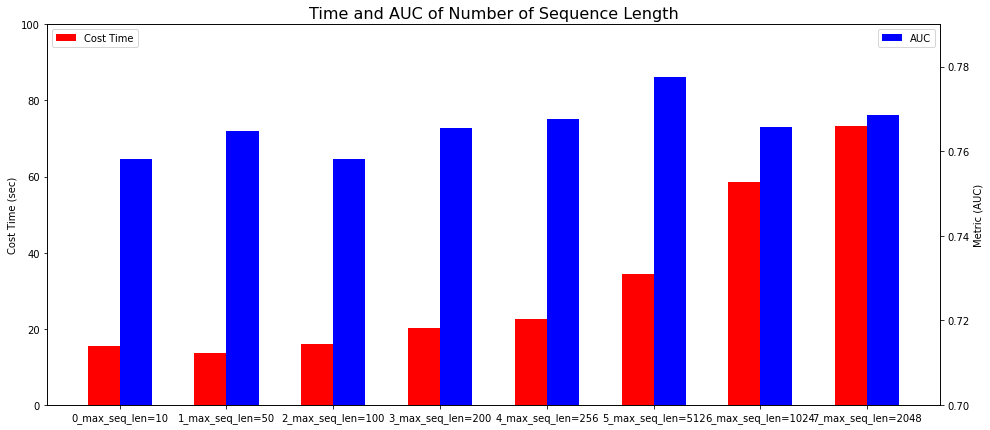

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(16,7))

ax1.set_title('Time and AUC of Number of Sequence Length', fontsize=16)

# Time
plt.bar(seq_df['experiment_tag'],
        seq_df['time_total_s'],
        color='red',
        width=-0.3, align='edge',
        label='Cost Time')
plt.ylabel('Cost Time (sec)')
ax1.set_ylim(0, 100)
ax1.legend(loc=2)

# AUC
ax2 = ax1.twinx()
plt.bar(seq_df['experiment_tag'],
        seq_df['auc'],
        color='blue',
        width=0.3, align='edge',
        label='AUC')
plt.ylabel('Metric (AUC)')

ax2.grid(False)
ax2.set_ylim(0.7, 0.79)
ax2.legend()

plt.show()

# 🏆 기타 모델 성능 개선
> 우리에게 주어진 데이터셋인 `train_data`를 train과 validation데이터로 나눠 사용하고 `valid_data`를 test데이터로 사용하여 임시 데이터셋으로 사용할 것이다.

- oof stacking
- pseudo 라벨링
- Data가 많을때 어떻게 빠르게 실험할 수 있을까?


In [ ]:
# 기타 모델 성능 개선 전용으로 사용할 데이터
size = int(len(train_data) * 0.8)

data = train_data
temp_train_data = train_data[:size]
temp_valid_data = train_data[size:]

# 실제로 test data에는 target값이 들어가지만 임의의 target값이 배정된다
temp_test_data = valid_data

## 🥇 oof stacking
> 다수 모델의 oof(out of fold)를 구한 후 이를 stacking하여 meta 모델 훈련에 활용하는 방법이다.

- oof stacking class
- 성능 비교


![OOF](https://github.com/IllgamhoDuck/ML_Pipeline/blob/main/images/OOF.png?raw=true)

![OOF STACKING](https://github.com/IllgamhoDuck/ML_Pipeline/blob/main/images/oof%20stacking.png?raw=true)

### 🎁 oof stacking class
> oof stacking을 일일이 계속 반복하기에 번거롭다. 그 번거로운 과정을 하나의 클래스로 구축하여 편리하게 반복할 수 있다면 어떨까? 그 클래스를 여기에서 제작한다.

- Trainer
- Stacking

#### 💯 Trainer
> 사용된 베이스라인 코드는 현재 Stacking 클래스와 호환이 되지 않는다. 이 Trainer는 그 중간단계에서 호환성을 담당한다.

In [ ]:
class Trainer:
    def __init__(self):
        pass

    def train(self, args, train_data, valid_data):
        """훈련을 마친 모델을 반환한다"""

        # args update
        self.args = args

         # 캐시 메모리 비우기 및 가비지 컬렉터 가동!
        torch.cuda.empty_cache()
        gc.collect()

        # augmentation
        augmented_train_data = data_augmentation(train_data, args)
        if len(augmented_train_data) != len(train_data):
            print(f"Data Augmentation applied. Train data {len(train_data)} -> {len(augmented_train_data)}\n")

        train_loader, valid_loader = get_loaders(args, augmented_train_data, valid_data)
        
        # only when using warmup scheduler
        args.total_steps = int(len(train_loader.dataset) / args.batch_size) * (args.n_epochs)
        args.warmup_steps = args.total_steps // 10
            
        model = get_model(args)
        optimizer = get_optimizer(model, args)
        scheduler = get_scheduler(optimizer, args)

        best_auc = -1
        best_model = -1
        for epoch in notebook.tqdm(range(args.n_epochs)):

            ### TRAIN
            train_auc, train_acc = train(train_loader, model, optimizer, args)
            
            ### VALID
            valid_auc, valid_acc, preds, targets = validate(valid_loader, model, args)

            ### TODO: model save or early stopping
            if valid_auc > best_auc:
                best_auc = valid_auc
                best_model = copy.deepcopy(model)

            # scheduler
            if args.scheduler == 'plateau':
                scheduler.step(best_auc)
            else:
                scheduler.step()

        return best_model

    def evaluate(self, args, model, valid_data):
        """훈련된 모델과 validation 데이터셋을 제공하면 predict 반환"""
        pin_memory = False

        valset = DKTDataset(valid_data, args)
        valid_loader = torch.utils.data.DataLoader(valset, shuffle=False,
                                                   batch_size=args.batch_size,
                                                   pin_memory=pin_memory,
                                                   collate_fn=collate)

        auc, acc, preds, _ = validate(valid_loader, model, args)
        print(f"AUC : {auc}, ACC : {acc}")

        return preds

    def test(self, args, model, test_data):
        return self.evaluate(args, model, test_data)

    def get_target(self, datas):
        targets = []
        for data in datas:
            targets.append(data[-1][-1])

        return np.array(targets)


#### 💯 Stacking
> oof stacking을 편리하게 사용할 수 있도록 custom하게 구축된 클래스다. 현재 DKT대회에 맞게 설계되어있으며 유사한 형태의 데이터의 경우 `Trainer`의 코드만 바꾸면 그대로 재사용이 가능하지만 데이터의 형태가 다를 경우(pandas DataFrame, 이미지 등) `Stacking` 코드도 해당 데이터에 맞게 재구축하거나, 혹은 데이터 입력을 `Stacking` 코드 입력 형식에 맞춰 넣어줘야 한다.
<br><br>
현재 `Stacking`은 X, y 데이터를 하나로 묶은 numpy.ndarray 데이터를 받는다 

```python
# X, y가 하나로 묶인 input만 허용한다
data = np.ndarray([[X1, y2],
                   [X2, y2],
                   ...
                   [Xn, yn]])
```

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

class Stacking:
    def __init__(self, trainer):
        self.trainer = trainer


    def get_train_oof(self, args, data, fold_n=5, stratify=True):

        oof = np.zeros(data.shape[0])

        fold_models = []

        if stratify:
            kfold = StratifiedKFold(n_splits=fold_n)
        else:
            kfold = KFold(n_splits=fold_n)

        # 클래스 비율 고려하여 Fold별로 데이터 나눔
        target = self.trainer.get_target(data)
        for i, (train_index, valid_index) in enumerate(kfold.split(data, target)):
            train_data, valid_data = data[train_index], data[valid_index]

            # 모델 생성 및 훈련
            print(f'Calculating train oof {i + 1}')
            trained_model = self.trainer.train(args, train_data, valid_data)

            # 모델 검증
            predict = self.trainer.evaluate(args, trained_model, valid_data)
            
            # fold별 oof 값 모으기
            oof[valid_index] = predict
            fold_models.append(trained_model)

        return oof, fold_models

    def get_test_avg(self, args, models, test_data):
        predicts = np.zeros(test_data.shape[0])

        # 클래스 비율 고려하여 Fold별로 데이터 나눔
        for i, model in enumerate(models):
            print(f'Calculating test avg {i + 1}')
            predict = self.trainer.test(args, model, test_data)
              
            # fold별 prediction 값 모으기
            predicts += predict

        # prediction들의 average 계산
        predict_avg = predicts / len(models)

        return predict_avg


    def train_oof_stacking(self, args_list, data, fold_n=5, stratify=True):
    
        S_train = None
        models_list = []
        for i, args in enumerate(args_list):
            print(f'training oof stacking model [ {i + 1} ]')
            train_oof, models = self.get_train_oof(args, data, fold_n=fold_n, stratify=stratify)
            train_oof = train_oof.reshape(-1, 1)

            # oof stack!
            if not isinstance(S_train, np.ndarray):
                S_train = train_oof
            else:
                S_train = np.concatenate([S_train, train_oof], axis=1)

            # store fold models
            models_list.append(models)

        return models_list, S_train

    def test_avg_stacking(self, args, models_list, test_data):
    
        S_test = None
        for i, models in enumerate(models_list):
            print(f'test average stacking model [ {i + 1} ]')
            test_avg = self.get_test_avg(args, models, test_data)
            test_avg = test_avg.reshape(-1, 1)

            # avg stack!
            if not isinstance(S_test, np.ndarray):
                S_test = test_avg
            else:
                S_test = np.concatenate([S_test, test_avg], axis=1)

        return S_test


    def train(self, meta_model, args_list, data):
        models_list, S_train = self.train_oof_stacking(args_list, data)
        target = self.trainer.get_target(data)
        meta_model.fit(S_train, target)
        
        return meta_model, models_list, S_train, target

    def test(self, meta_model, models_list, test_data):
        S_test = self.test_avg_stacking(args, models_list, test_data)
        predict = meta_model.predict(S_test)

        return predict, S_test


### 🎁 성능 비교

- single 모델
- oof stacking 모델
- `single model` vs `3 model 5 fold oof stacking` 성능 비교

#### 💯 single 모델
> 베이스라인을 그대로 사용한다

In [ ]:
trainer = Trainer()

In [ ]:
# seed 설정 
seed_everything(args.seed)

model = trainer.train(args, temp_train_data, temp_valid_data)

In [ ]:
valid_target = trainer.get_target(temp_valid_data)
valid_predict = trainer.evaluate(args, model, temp_valid_data)

# 검증셋 성능
valid_auc, valid_acc = get_metric(valid_target, valid_predict)
valid_auc, valid_acc

AUC : 0.6963214876521328, ACC : 0.6497120921305183


(0.6963214876521328, 0.6497120921305183)

In [ ]:
# 여기 test데이터는 진짜 target값을 지니고 있다. 그렇기 때문에 여기서는
# test데이터에서 직접 target값을 추출하는 것이며, 실제 대회에서는
# test 데이터에는 임의의 fake target값이 들어가있다
test_target = trainer.get_target(temp_test_data)
test_predict = trainer.test(args, model, temp_test_data)

# 테스트셋 성능
test_auc, test_acc = get_metric(test_target, test_predict)
test_auc, test_acc

AUC : 0.7115493905570555, ACC : 0.658307210031348


(0.7115493905570555, 0.658307210031348)

#### 💯 oof stacking 모델
> 베이스라인에서 `n_heads`가 각각 2, 4, 8로 바뀐 모델 3개만 사용한다. `n_heads`를 선택한 이유는 hyperparamter중에서 탐색 시에 성능 변화가 별달리 변화가 없으며 성능이 매우 낮게 나오기 때문이다. 이렇게 별다른 영향이 없는 `n_heads`도 앙상블 기법 중 하나인 `oof stacking`을 이용하면 어느 정도 성능 향상을 기대할 수 있다.

⛔ **성능이 하락할 시** ⛔
> 성능이 하락할 경우 코드를 잘못 짰거나 meta 모델을 튜닝 없이 사용해서 일수도 있다. meta 모델로 신경망을 사용할경우 비교적 덜 신경써도 되지만, 만약 부스팅 트리 계열(xgboost, lgbm, catboost)을 사용할 시에 하이퍼파라메타 튜닝을 꼭 하도록 하자!

In [ ]:
# n_heads가 다른 5개의 args
args_list = []
n_heads_list = [2, 4, 8]

for n_heads in n_heads_list:
    copy_args = copy.deepcopy(args)
    copy_args.n_heads = n_heads
    args_list.append(copy_args)

In [ ]:
from sklearn.linear_model import LinearRegression

# seed 설정 
seed_everything(args.seed)

# oof stacking ensemble
# Train
stacking = Stacking(Trainer())
meta_model = LinearRegression()
meta_model, models_list, S_train, target = stacking.train(meta_model, args_list, data)

# Test
stacking = Stacking(Trainer())
test_predict, S_test = stacking.test(meta_model, models_list, temp_test_data)
test_target = trainer.get_target(temp_test_data)

# 테스트셋 성능
stack_test_auc, stack_test_acc = get_metric(test_target, test_predict)
stack_test_auc, stack_test_acc

training oof stacking model [ 1 ]
Calculating train oof 1



AUC : 0.715124361598171, ACC : 0.6641074856046065
Calculating train oof 2



AUC : 0.685373453546472, ACC : 0.6525911708253359
Calculating train oof 3



AUC : 0.7204897026015451, ACC : 0.6756238003838771
Calculating train oof 4



AUC : 0.6994155281449932, ACC : 0.6497120921305183
Calculating train oof 5



AUC : 0.6834190535307855, ACC : 0.6426512968299711
training oof stacking model [ 2 ]
Calculating train oof 1



AUC : 0.7128233493740435, ACC : 0.6564299424184261
Calculating train oof 2



AUC : 0.6678282353375004, ACC : 0.6266794625719769
Calculating train oof 3



AUC : 0.6993675903903239, ACC : 0.6497120921305183
Calculating train oof 4



AUC : 0.7045079926987112, ACC : 0.6516314779270633
Calculating train oof 5



AUC : 0.682247790488014, ACC : 0.6368876080691642
training oof stacking model [ 3 ]
Calculating train oof 1



AUC : 0.7059240002212511, ACC : 0.6564299424184261
Calculating train oof 2



AUC : 0.6707856260486385, ACC : 0.6362763915547025
Calculating train oof 3



AUC : 0.7179969393587403, ACC : 0.6650671785028791
Calculating train oof 4



AUC : 0.6924922101148662, ACC : 0.6362763915547025
Calculating train oof 5



AUC : 0.681671396056871, ACC : 0.6464937560038425
test average stacking model [ 1 ]
Calculating test avg 1
AUC : 0.7043827407947632, ACC : 0.6426332288401254
Calculating test avg 2
AUC : 0.7148747224865208, ACC : 0.6650246305418719
Calculating test avg 3
AUC : 0.7045743237042797, ACC : 0.6547245857590686
Calculating test avg 4
AUC : 0.7114149605323107, ACC : 0.6551724137931034
Calculating test avg 5
AUC : 0.7138862190710322, ACC : 0.6614420062695925
test average stacking model [ 2 ]
Calculating test avg 1
AUC : 0.7115823943355857, ACC : 0.6542767577250336
Calculating test avg 2
AUC : 0.7098831022263866, ACC : 0.6618898343036274
Calculating test avg 3
AUC : 0.7153069914882451, ACC : 0.6618898343036274
Calculating test avg 4
AUC : 0.715443836423614, ACC : 0.6605463502015226
Calculating test avg 5
AUC : 0.7118222754575854, ACC : 0.658307210031348
test average stacking model [ 3 ]
Calculating test avg 1
AUC : 0.7162954949037337, ACC : 0.6717420510523959
Calculating test avg 2
AUC : 0.7110

(0.7335009281306498, 0.671294223018361)

#### 💯 `single model` vs `3 model 5 fold oof stacking` 성능 비교

In [ ]:
# result
print(f"single model score : {test_auc}")
print(f"3 model 5 fold oof stacking score : {stack_test_auc}")

single model score : 0.7115493905570555
3 model 5 fold oof stacking score : 0.7335009281306498


## 🥇 pseudo 라벨링
> test set의 데이터가 주어질 경우 이를 활용하는 방법이다. train set에서 훈련된 모델로 test set에 임의로 라벨링을 한 이후 train set에 포함시켜 전체 훈련을 다시 진행한다. 이렇게 훈련된 모델로 다시 test set에 라벨링을 매기는 작업을 반복한다.

- Trainer
- 첫번째 과정
- 두번째 과정
- 위의 과정 무한 반복

![pseudo labeling](https://www.researchgate.net/profile/Bayu-Adhi-Tama/publication/341813397/figure/fig2/AS:898930028068866@1591333028818/Schematic-diagram-of-pseudo-labeling.ppm)

이미지 출처
- https://www.researchgate.net/figure/Schematic-diagram-of-pseudo-labeling_fig2_341813397

#### 🎁 Trainer
> `oof stacking`에서 사용하였던 Trainer class로 `pseudo 라벨링`에서도 활용한다.

In [ ]:
class Trainer:
    def __init__(self):
        pass

    def train(self, args, train_data, valid_data):
        """훈련을 마친 모델을 반환한다"""

        # args update
        self.args = args

         # 캐시 메모리 비우기 및 가비지 컬렉터 가동!
        torch.cuda.empty_cache()
        gc.collect()

        # augmentation
        augmented_train_data = data_augmentation(train_data, args)
        if len(augmented_train_data) != len(train_data):
            print(f"Data Augmentation applied. Train data {len(train_data)} -> {len(augmented_train_data)}\n")

        train_loader, valid_loader = get_loaders(args, augmented_train_data, valid_data)
        
        # only when using warmup scheduler
        args.total_steps = int(len(train_loader.dataset) / args.batch_size) * (args.n_epochs)
        args.warmup_steps = args.total_steps // 10
            
        model = get_model(args)
        optimizer = get_optimizer(model, args)
        scheduler = get_scheduler(optimizer, args)

        best_auc = -1
        best_model = -1
        for epoch in notebook.tqdm(range(args.n_epochs)):

            ### TRAIN
            train_auc, train_acc = train(train_loader, model, optimizer, args)
            
            ### VALID
            valid_auc, valid_acc, preds, targets = validate(valid_loader, model, args)

            ### TODO: model save or early stopping
            if valid_auc > best_auc:
                best_auc = valid_auc
                best_model = copy.deepcopy(model)

            # scheduler
            if args.scheduler == 'plateau':
                scheduler.step(best_auc)
            else:
                scheduler.step()

        return best_model

    def evaluate(self, args, model, valid_data):
        """훈련된 모델과 validation 데이터셋을 제공하면 predict 반환"""
        pin_memory = False

        valset = DKTDataset(valid_data, args)
        valid_loader = torch.utils.data.DataLoader(valset, shuffle=False,
                                                   batch_size=args.batch_size,
                                                   pin_memory=pin_memory,
                                                   collate_fn=collate)

        auc, acc, preds, _ = validate(valid_loader, model, args)

        return preds

    def test(self, args, model, test_data):
        return self.evaluate(args, model, test_data)

    def get_target(self, datas):
        targets = []
        for data in datas:
            targets.append(data[-1][-1])

        return np.array(targets)


### 🎁 첫번째 과정

- 첫번째 훈련
- 첫번째 pseudo 라벨 얻기
- train 데이터 업데이트

#### 💯 첫번째 훈련
> 첫번째 훈련은 주어진 train set만으로 진행한다.

In [ ]:
# trainer 생성
trainer = Trainer()

In [ ]:
# seed
seed_everything(args.seed)

model = trainer.train(args, temp_train_data, temp_valid_data)

In [ ]:
valid_target = trainer.get_target(temp_valid_data)
valid_predict = trainer.evaluate(args, model, temp_valid_data)

# 검증셋 성능
first_valid_auc, first_valid_acc = get_metric(valid_target, valid_predict)
first_valid_auc, first_valid_acc

(0.7012805742644452, 0.654510556621881)

#### 💯 첫번째 pseudo 라벨 얻기
> 훈련을 통해 얻은 모델을 바탕으로 테스트셋을 예측하여 pseudo 라벨을 얻어보자

In [ ]:
# 테스트셋을 예측하여 confidence를 얻자
test_predict = trainer.test(args, model, temp_test_data)
test_predict

array([0.37783146, 0.6516125 , 0.5382275 , ..., 0.5241553 , 0.59039986,
       0.5899889 ], dtype=float32)

In [ ]:
# confidence를 pseudo 라벨로 변환
pseudo_labels = np.where(test_predict >= 0.5, 1, 0)
pseudo_labels

array([0, 1, 1, ..., 1, 1, 1])

In [ ]:
# pseudo 라벨이 담길 test 데이터 복사본
pseudo_test_data = copy.deepcopy(temp_test_data)

# pseudo label 테스트 데이터 update
for test_data, pseudo_label in zip(pseudo_test_data, pseudo_labels):
    test_data[-1][-1] = pseudo_label

In [ ]:
# 라벨이 업데이트 된 것을 확인할 수 있다.
temp_test_data[0][-1][-1], pseudo_test_data[0][-1][-1]

(1, 0)

#### 💯 train 데이터 업데이트
> 얻어진 pseudo label로 라벨링한 test데이터를 기존 train데이터와 합쳐 새로운 데이터를 생성하자

In [ ]:
pseudo_train_data = np.concatenate((temp_train_data, pseudo_test_data))

In [ ]:
print(f"train 셋 크기       : {len(temp_train_data)}")
print(f"test 셋 크기        : {len(pseudo_test_data)}")
print("-" * 30)
print(f"새로운 train 셋 크기 : {len(pseudo_train_data)}")

train 셋 크기       : 4167
test 셋 크기        : 2233
------------------------------
새로운 train 셋 크기 : 6400


### 🎁 두번째 과정

- 두번째 훈련
- 두번째 pseudo 라벨 얻기
- train 데이터 업데이트

#### 💯 두번째 훈련
> 두번째 훈련은 생성한 새로운 train 데이터로 진행한다.

In [ ]:
# trainer 생성
trainer = Trainer()

In [ ]:
# seed
seed_everything(args.seed)

model = trainer.train(args, pseudo_train_data, temp_valid_data)

In [ ]:
valid_target = trainer.get_target(temp_valid_data)
valid_predict = trainer.evaluate(args, model, temp_valid_data)

# 검증셋 성능
second_valid_auc, second_valid_acc = get_metric(valid_target, valid_predict)
second_valid_auc, second_valid_acc

(0.6983043837882547, 0.6458733205374281)

#### 💯 두번째 pseudo 라벨 얻기
> 훈련을 통해 얻은 모델을 바탕으로 테스트셋을 예측하여 pseudo 라벨을 얻어보자

In [ ]:
# 테스트셋을 예측하여 confidence를 얻자
test_predict = trainer.test(args, model, temp_test_data)
test_predict

array([0.27376038, 0.7706975 , 0.50517005, ..., 0.543434  , 0.62865096,
       0.7437669 ], dtype=float32)

In [ ]:
# confidence를 pseudo 라벨로 변환
pseudo_labels = np.where(test_predict >= 0.5, 1, 0)
pseudo_labels

array([0, 1, 1, ..., 1, 1, 1])

In [ ]:
# pseudo 라벨이 담길 test 데이터 복사본
pseudo_test_data = copy.deepcopy(temp_test_data)

# pseudo label 테스트 데이터 update
for test_data, pseudo_label in zip(pseudo_test_data, pseudo_labels):
    test_data[-1][-1] = pseudo_label

In [ ]:
# 라벨이 업데이트 된 것을 확인할 수 있다.
temp_test_data[0][-1][-1], pseudo_test_data[0][-1][-1]

(1, 0)

#### 💯 train 데이터 업데이트
> 얻어진 pseudo label로 라벨링한 test데이터를 기존 train데이터와 합쳐 새로운 데이터를 생성하자

In [ ]:
pseudo_train_data = np.concatenate((temp_train_data, pseudo_test_data))

In [ ]:
print(f"train 셋 크기       : {len(temp_train_data)}")
print(f"test 셋 크기        : {len(pseudo_test_data)}")
print("-" * 30)
print(f"새로운 train 셋 크기 : {len(pseudo_train_data)}")

train 셋 크기       : 4167
test 셋 크기        : 2233
------------------------------
새로운 train 셋 크기 : 6400


### 🎁 N 반복을 편하게 하기 위한 클래스 제작
> 위의 과정을 무한 반복하면 된다. 이를 편리하게 코드로 특정 횟수만큼 반복시켜보자!

- `PseudoLabel` class
- 테스트

#### 💯 `PseudoLabel` class

In [ ]:
class PseudoLabel:
    def __init__(self, trainer):
        self.trainer = trainer
        
        # 결과 저장용
        self.models =[]
        self.valid_aucs =[]
        self.valid_accs =[]

    def visualize(self):
        aucs = self.valid_aucs
        accs = self.valid_accs

        N = len(aucs)
        auc_min = min(aucs)
        auc_max = max(aucs)
        acc_min = min(accs)
        acc_max = max(accs)

        experiment = ['base'] + [f'pseudo {i + 1}' for i in range(N - 1)]
        df = pd.DataFrame({'experiment': experiment, 'auc': aucs, 'acc': accs})

        import matplotlib.pyplot as plt

        fig, ax1 = plt.subplots(figsize=(5 + N, 7))

        ax1.set_title('AUC of Pseudo Label Training Process', fontsize=16)

        # Time
        plt.bar(df['experiment'],
                df['auc'],
                color='red',
                width=-0.3, align='edge',
                label='AUC')
        plt.ylabel('AUC (Area Under the ROC Curve)')
        ax1.set_ylim(auc_min - 0.002, auc_max + 0.002)
        ax1.axhline(y=aucs[0], color='r', linewidth=1)
        ax1.legend(loc=2)

        # AUC
        ax2 = ax1.twinx()
        plt.bar(df['experiment'],
                df['acc'],
                color='blue',
                width=0.3, align='edge',
                label='ACC')
        plt.ylabel('ACC (Accuracy)')

        ax2.grid(False)
        ax2.set_ylim(acc_min - 0.002, acc_max + 0.002)
        ax2.axhline(y=accs[0], color='b', linewidth=1)
        ax2.legend(loc=1)

        plt.show()

    def train(self, args, train_data, valid_data):
        model = self.trainer.train(args, train_data, valid_data)

        # model 저장
        self.models.append(model)
        
        return model

    def validate(self, args, model, valid_data):
        valid_target = self.trainer.get_target(valid_data)
        valid_predict = self.trainer.evaluate(args, model, valid_data)

        # Metric
        valid_auc, valid_acc = get_metric(valid_target, valid_predict)

        # auc / acc 저장
        self.valid_aucs.append(valid_auc)
        self.valid_accs.append(valid_acc)

        print(f'Valid AUC : {valid_auc} Valid ACC : {valid_acc}')

    def test(self, args, model, test_data):
        test_predict = self.trainer.test(args, model, test_data)
        pseudo_labels = np.where(test_predict >= 0.5, 1, 0)
        
        return pseudo_labels

    def update_train_data(self, pseudo_labels, train_data, test_data):
        # pseudo 라벨이 담길 test 데이터 복사본
        pseudo_test_data = copy.deepcopy(test_data)

        # pseudo label 테스트 데이터 update
        for test_data, pseudo_label in zip(pseudo_test_data, pseudo_labels):
            test_data[-1][-1] = pseudo_label

        # train data 업데이트
        pseudo_train_data = np.concatenate((train_data, pseudo_test_data))

        return pseudo_train_data

    def run(self, N, args, train_data, valid_data, test_data):
        """
        N은 두번째 과정을 몇번 반복할지 나타낸다.
        즉, pseudo label를 이용한 training 횟수를 가리킨다.
        """
        if N < 1:
            raise ValueError(f"N must be bigger than 1, currently {N}")

        # seed
        seed_everything(args.seed)
        
        # pseudo label training을 위한 준비 단계
        print("Preparing for pseudo label process")
        model = self.train(args, train_data, valid_data)
        self.validate(args, model, valid_data)
        pseudo_labels = self.test(args, model, test_data)
        pseudo_train_data = self.update_train_data(pseudo_labels, train_data, test_data)

        # pseudo label training 원하는 횟수만큼 반복
        for i in range(N):
            print(f'Pseudo Label Training Process {i + 1}')
            # seed
            seed_everything(args.seed)

            model = self.train(args, pseudo_train_data, valid_data)
            self.validate(args, model, valid_data)
            pseudo_labels = self.test(args, model, test_data)
            pseudo_train_data = self.update_train_data(pseudo_labels, train_data, test_data)

        # 결과 시각화
        self.visualize()


#### 💯 테스트

Preparing for pseudo label process



Valid AUC : 0.7012805742644452 Valid ACC : 0.654510556621881
Pseudo Label Training Process 1



Valid AUC : 0.6983043837882547 Valid ACC : 0.6458733205374281
Pseudo Label Training Process 2



Valid AUC : 0.6990170447831738 Valid ACC : 0.6381957773512476
Pseudo Label Training Process 3



Valid AUC : 0.6996041592815787 Valid ACC : 0.6525911708253359
Pseudo Label Training Process 4



Valid AUC : 0.6970304561030368 Valid ACC : 0.6353166986564299
Pseudo Label Training Process 5



Valid AUC : 0.6975474122651542 Valid ACC : 0.6535508637236085


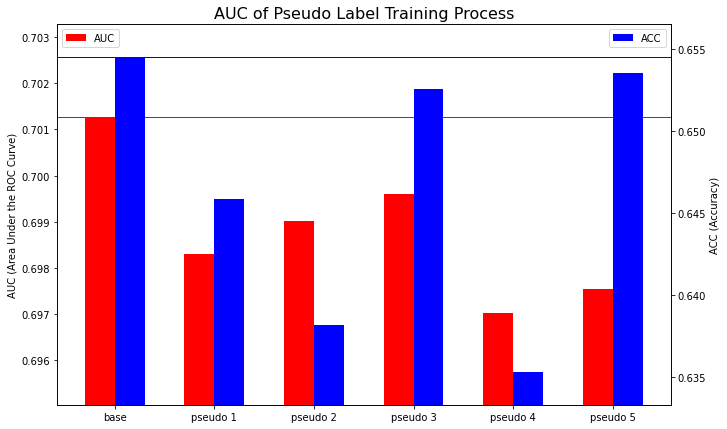

In [ ]:
pseudo = PseudoLabel(Trainer())

# pseudo label 훈련!
N = 5
pseudo.run(N, args, temp_train_data, temp_valid_data, temp_test_data)

### 🎁 모델 개선 후 다시 사용

> 10 epoch 에 AUC가 0.701정도가 나오는 모델의 경우 갈수록 성능이 하락한다. 다른 성능의 모델에서는 어떨까?

- `hidden_dim` 256 모델 - AUC 0.702

#### 💯 `hidden_dim` 256 모델 - AUC 0.702

Preparing for pseudo label process



Valid AUC : 0.7027022037102681 Valid ACC : 0.6468330134357005
Pseudo Label Training Process 1



Valid AUC : 0.7029052936311 Valid ACC : 0.6564299424184261
Pseudo Label Training Process 2



Valid AUC : 0.7011771830320217 Valid ACC : 0.6602687140115163
Pseudo Label Training Process 3



Valid AUC : 0.7004054413328606 Valid ACC : 0.6554702495201535
Pseudo Label Training Process 4



Valid AUC : 0.6996890877939265 Valid ACC : 0.6449136276391555
Pseudo Label Training Process 5



Valid AUC : 0.7029865295994329 Valid ACC : 0.6468330134357005


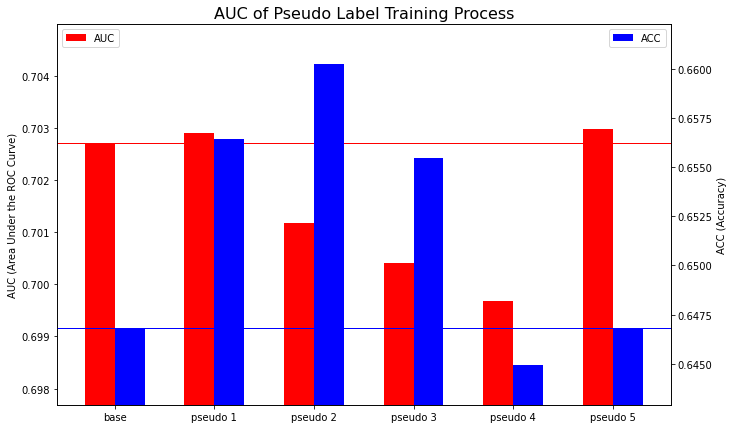

In [ ]:
pseudo = PseudoLabel(Trainer())

# hyperparameter 바꾸기
args.hidden_dim = 256

# pseudo label 훈련!
N = 5
pseudo.run(N, args, temp_train_data, temp_valid_data, temp_test_data)

# 하이퍼파라메타 원상복귀
args.hidden_dim = 64

## 🥇 Data가 많을때 어떻게 빠르게 실험할 수 있을까?

- 코나팀 - 모델 빠르게 실험하는 검증전략

### 🎁 코나팀 - 모델 빠르게 실험하는 검증전략
> undersampling은 아니며 매 epoch마다 1/10 데이터만 써서 계속 학습시키고 검증하는 과정을 반복한다. 10 epoch에 이르러 어느 정도 전체 데이터를 봤다고 생각할 수 있다. 엔지니어링 관점에서 다양한 실험을 하기 위해 학습을 빨리 할 수 있는 세팅을 한 것이며 검증을 빠르게 반복하여 최고의 세팅을 찾아나간다.

![cona](https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F6f373e58-45fb-4f1f-8106-e6125e38673b%2F_.png?table=block&id=c8f6655c-2824-4d48-be70-dd897af4870a&width=3060&userId=1f48fc9a-7bf2-44fb-8d00-a699b59f59b8&cache=v2)

이미지 출처
- 코나팀

#### 💯 일반적인 경우 - 데이터를 그대로 1epoch 훈련에 사용

In [ ]:
# seed 설정 
seed_everything(args.seed)

report = run(args, train_data, valid_data)
total_time, auc, acc = time_auc(report)

print(f"Cost Time : {total_time} sec, best AUC : {auc}")


Cost Time : 34.99570274353027 sec, best AUC : 0.7084446204645967


#### 💯 코나팀 - 데이터를 10epoch로 나눠서 10번의 검증을 반복

- fast_run 함수
- seed를 바꾸는 간단한 실험

##### fast_run 함수
> 우리는 epoch마다 다른 데이터셋을 사용하는만큼 기존의 `run`함수를 그대로 사용할수는 없다. 여기서 `fast_run`이라는 epoch마다 다른 데이터셋을 사용하는 새로운 함수를 구현하여 사용하자

In [ ]:
def get_target(datas):
    targets = []
    for data in datas:
        targets.append(data[-1][-1])

    return np.array(targets)

In [ ]:
def fast_run(args, train_datas, valid_data):

         
    model = get_model(args)
    optimizer = get_optimizer(model, args)
    scheduler = get_scheduler(optimizer, args)

    # 데이터가 10개로 쪼개져있기 때문에 loader도 10개로 나눠서 생성
    train_loaders = []
    for train_data in train_datas:
        train_loader, valid_loader = get_loaders(args, train_data, valid_data)
        train_loaders.append(train_loader)

    # 🌟 분석에 사용할 값 저장 🌟
    report = OrderedDict()

    best_auc = -1
    best_auc_epoch = -1
    best_acc = -1
    best_acc_epoch = -1
    for epoch in notebook.tqdm(range(args.n_epochs)):
        # 몇번째 data를 쓸 차례인지 정함
        data_i = epoch % 10

        # 해당하는 train_loader 불러오기
        train_loader = train_loaders[data_i]
        epoch_report = {}

        ### TRAIN
        train_start_time = time.time()
        train_auc, train_acc = train(train_loader, model, optimizer, args)
        train_time = time.time() - train_start_time

        epoch_report['train_auc'] = train_auc
        epoch_report['train_acc'] = train_acc
        epoch_report['train_time'] = train_time
        
        ### VALID
        valid_start_time = time.time()
        valid_auc, valid_acc, preds, targets = validate(valid_loader, model, args)
        valid_time = time.time() - valid_start_time

        epoch_report['valid_auc'] = valid_auc
        epoch_report['valid_acc'] = valid_acc
        epoch_report['valid_time'] = valid_time

        # 🌟 save it to report 🌟
        report[f'{epoch + 1}'] = epoch_report

        print(f"        epoch : {epoch + 1} train AUC : {train_auc} valid AUC : {valid_auc}")


        ### TODO: model save or early stopping
        if valid_auc > best_auc:
            best_auc = valid_auc
            best_auc_epoch = epoch + 1

        if valid_acc > best_acc:
            best_acc = valid_acc
            best_acc_epoch = epoch + 1

        # scheduler
        if args.scheduler == 'plateau':
            scheduler.step(best_auc)
        else:
            scheduler.step()

    # save best records
    report['best_auc'] = best_auc
    report['best_auc_epoch'] = best_auc_epoch
    report['best_acc'] = best_acc
    report['best_acc_epoch'] = best_acc_epoch

    return report


##### seed를 바꾸는 간단한 실험
> seed를 바꾸는 간단한 실험을 통해 성능이 어떻게 변화하는지 그리고 train AUC와 validation AUC는 같이 올라가는지 체크해보자. 좋은 성능을 가진 실험 후보들을 추려 추후 test AUC까지 같이 올라가는지 심도있게 체크해볼 수도 있다.

In [ ]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10)

# stratified KFold적용을 위한 target 라벨 가져오기
target = get_target(temp_train_data)

# 나눈 데이터 저장
small_train_datas = []

# 클래스 비율 고려하여 Fold별로 데이터 나눔
for i, (_, train_index) in enumerate(kfold.split(temp_train_data, target)):

    # 평상시의 validation 데이터를 여기서는 train 데이터로 사용한다
    small_train_datas.append(temp_train_data[train_index])

In [ ]:
def run_experiment(seed):
    print(f"Experiment Seed : {seed}")

    # seed 설정 
    seed_everything(seed)

    # 전용 run 함수인 fast_run을 사용한다
    report = fast_run(args, small_train_datas, temp_valid_data)
    total_time, auc, acc = time_auc(report, n_epoch=10)

    print(f"Cost Time : {total_time} sec, best AUC : {auc}\n")

# 임의로 seed를 바꾸는 것을 새로운 실험이라고 가정한다
experiments = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# 빠르게 10개의 다른 실험을 반복할 수 있다
for experiment in experiments:
    run_experiment(experiment)

Experiment Seed : 1


        epoch : 1 train AUC : 0.4952350260116937 valid AUC : 0.4737497045964787
        epoch : 2 train AUC : 0.5136273652225957 valid AUC : 0.5244151010280043
        epoch : 3 train AUC : 0.5110722342433589 valid AUC : 0.5673039997636772
        epoch : 4 train AUC : 0.6030799686938906 valid AUC : 0.5953710268226398
        epoch : 5 train AUC : 0.6279867409419456 valid AUC : 0.6117400744416873
        epoch : 6 train AUC : 0.6189632153215782 valid AUC : 0.6213517665130569
        epoch : 7 train AUC : 0.7236084894802265 valid AUC : 0.6293018137776202
        epoch : 8 train AUC : 0.6469159786304032 valid AUC : 0.6357637658040884
        epoch : 9 train AUC : 0.6465022670491349 valid AUC : 0.6416422958761668
        epoch : 10 train AUC : 0.6318589802905525 valid AUC : 0.6446295639844026

Cost Time : 5.106612205505371 sec, best AUC : 0.6446295639844026

Experiment Seed : 2


        epoch : 1 train AUC : 0.4552046406703192 valid AUC : 0.5103760486825002
        epoch : 2 train AUC : 0.5431379770728788 valid AUC : 0.5867637067233841
        epoch : 3 train AUC : 0.5875420100363703 valid AUC : 0.6377318917641498
        epoch : 4 train AUC : 0.5977164955572948 valid AUC : 0.6507185690653432
        epoch : 5 train AUC : 0.6167763915105199 valid AUC : 0.6563275434243176
        epoch : 6 train AUC : 0.651650476497399 valid AUC : 0.6586612312418764
        epoch : 7 train AUC : 0.672367754707426 valid AUC : 0.6598871558548978
        epoch : 8 train AUC : 0.671153356923148 valid AUC : 0.6622577691126078
        epoch : 9 train AUC : 0.6472887942999909 valid AUC : 0.6641151187522156
        epoch : 10 train AUC : 0.6382668640695845 valid AUC : 0.6653299657331916

Cost Time : 5.073348760604858 sec, best AUC : 0.6653299657331916

Experiment Seed : 3


        epoch : 1 train AUC : 0.41793655909028127 valid AUC : 0.526630627437079
        epoch : 2 train AUC : 0.5770452557432899 valid AUC : 0.5766904466501241
        epoch : 3 train AUC : 0.6119423599281801 valid AUC : 0.6044509925558312
        epoch : 4 train AUC : 0.6049445237327931 valid AUC : 0.6142546969159872
        epoch : 5 train AUC : 0.6100087472952442 valid AUC : 0.6208606581590452
        epoch : 6 train AUC : 0.6356060954836333 valid AUC : 0.6272302965851354
        epoch : 7 train AUC : 0.6697435661341559 valid AUC : 0.6323333924140376
        epoch : 8 train AUC : 0.6346353985984874 valid AUC : 0.6350400271771239
        epoch : 9 train AUC : 0.6466410659757565 valid AUC : 0.6365613553113554
        epoch : 10 train AUC : 0.6083094290737485 valid AUC : 0.6370524636653669

Cost Time : 5.076094150543213 sec, best AUC : 0.6370524636653669

Experiment Seed : 4


        epoch : 1 train AUC : 0.5700934579439253 valid AUC : 0.6102925971877585
        epoch : 2 train AUC : 0.6241655540720962 valid AUC : 0.6360887096774194
        epoch : 3 train AUC : 0.6401408774918282 valid AUC : 0.6463022864232542
        epoch : 4 train AUC : 0.6200451176281019 valid AUC : 0.6501942278151954
        epoch : 5 train AUC : 0.6160858155701856 valid AUC : 0.6523839064161644
        epoch : 6 train AUC : 0.6746006169145069 valid AUC : 0.6530264090747961
        epoch : 7 train AUC : 0.6793195525067907 valid AUC : 0.6553674819803852
        epoch : 8 train AUC : 0.6794097920858484 valid AUC : 0.6565823289613613
        epoch : 9 train AUC : 0.6717405385398353 valid AUC : 0.6571362105636299
        epoch : 10 train AUC : 0.6723651337096327 valid AUC : 0.6577713281342314

Cost Time : 5.05040717124939 sec, best AUC : 0.6577713281342314

Experiment Seed : 5


        epoch : 1 train AUC : 0.5710832834584043 valid AUC : 0.5695638367009335
        epoch : 2 train AUC : 0.604921504534782 valid AUC : 0.5975607054236086
        epoch : 3 train AUC : 0.6222089222411491 valid AUC : 0.6118323880420655
        epoch : 4 train AUC : 0.5991436858339856 valid AUC : 0.6175890641616447
        epoch : 5 train AUC : 0.6238663044979512 valid AUC : 0.6215954744180552
        epoch : 6 train AUC : 0.6540214538925464 valid AUC : 0.6255760368663595
        epoch : 7 train AUC : 0.6586943510888082 valid AUC : 0.6302027945173105
        epoch : 8 train AUC : 0.6099586021878396 valid AUC : 0.6340910433652369
        epoch : 9 train AUC : 0.6371102063477376 valid AUC : 0.6386033321517193
        epoch : 10 train AUC : 0.6503192375312299 valid AUC : 0.6423475717830557

Cost Time : 5.063823699951172 sec, best AUC : 0.6423475717830557

Experiment Seed : 6


        epoch : 1 train AUC : 0.5102665623129691 valid AUC : 0.5588868456812005
        epoch : 2 train AUC : 0.6094332673449657 valid AUC : 0.6043032907952264
        epoch : 3 train AUC : 0.6268127618433774 valid AUC : 0.6246270530544724
        epoch : 4 train AUC : 0.6155333548179182 valid AUC : 0.6344455275906888
        epoch : 5 train AUC : 0.6020441047833893 valid AUC : 0.6404016010870849
        epoch : 6 train AUC : 0.6192164264997008 valid AUC : 0.6432928630509276
        epoch : 7 train AUC : 0.6781685926062336 valid AUC : 0.6447107999527355
        epoch : 8 train AUC : 0.6540391775943014 valid AUC : 0.6460179605340896
        epoch : 9 train AUC : 0.6832377162949941 valid AUC : 0.6472106522509748
        epoch : 10 train AUC : 0.6291524012214306 valid AUC : 0.6490163062743708

Cost Time : 5.078711032867432 sec, best AUC : 0.6490163062743708

Experiment Seed : 7


        epoch : 1 train AUC : 0.47302149993094245 valid AUC : 0.5114210386387806
        epoch : 2 train AUC : 0.5492380645458312 valid AUC : 0.5755863759896018
        epoch : 3 train AUC : 0.6077298466921413 valid AUC : 0.6097830261136712
        epoch : 4 train AUC : 0.607844942682197 valid AUC : 0.6225703060380479
        epoch : 5 train AUC : 0.6162239307582524 valid AUC : 0.6267576509511994
        epoch : 6 train AUC : 0.641429952580452 valid AUC : 0.6286186931348222
        epoch : 7 train AUC : 0.6990009668063165 valid AUC : 0.6297670743235259
        epoch : 8 train AUC : 0.635121071255117 valid AUC : 0.6317684331797234
        epoch : 9 train AUC : 0.6563569908392709 valid AUC : 0.6346153846153847
        epoch : 10 train AUC : 0.6480521883964099 valid AUC : 0.6371817027058964

Cost Time : 5.097550392150879 sec, best AUC : 0.6371817027058964

Experiment Seed : 8


        epoch : 1 train AUC : 0.5676994613507665 valid AUC : 0.6071797825830084
        epoch : 2 train AUC : 0.6249482068044749 valid AUC : 0.6420854011579818
        epoch : 3 train AUC : 0.6404401270659731 valid AUC : 0.6563903166725749
        epoch : 4 train AUC : 0.6458496385985912 valid AUC : 0.6620251388396549
        epoch : 5 train AUC : 0.660650982919755 valid AUC : 0.6668697565874986
        epoch : 6 train AUC : 0.6622277979835183 valid AUC : 0.670111810232778
        epoch : 7 train AUC : 0.6829796049905621 valid AUC : 0.6733612489660877
        epoch : 8 train AUC : 0.6682161937140082 valid AUC : 0.6750487415809996
        epoch : 9 train AUC : 0.6774081613768854 valid AUC : 0.6760124955689473
        epoch : 10 train AUC : 0.6442120847598778 valid AUC : 0.6763559021623536

Cost Time : 5.118173599243164 sec, best AUC : 0.6763559021623536

Experiment Seed : 9


        epoch : 1 train AUC : 0.5729478384973068 valid AUC : 0.5436754106108945
        epoch : 2 train AUC : 0.6295520464067033 valid AUC : 0.5766498286659576
        epoch : 3 train AUC : 0.6271350306155333 valid AUC : 0.5989269467092049
        epoch : 4 train AUC : 0.5691726900234795 valid AUC : 0.6073237917995983
        epoch : 5 train AUC : 0.5880254131946043 valid AUC : 0.611876698570247
        epoch : 6 train AUC : 0.6293218544265917 valid AUC : 0.6147014947418173
        epoch : 7 train AUC : 0.6658763408682842 valid AUC : 0.6191694730001182
        epoch : 8 train AUC : 0.6261476907421539 valid AUC : 0.6218945704832802
        epoch : 9 train AUC : 0.6340103636531877 valid AUC : 0.6215659340659342
        epoch : 10 train AUC : 0.6395391875636162 valid AUC : 0.6226810823585017

Cost Time : 5.085420846939087 sec, best AUC : 0.6226810823585017

Experiment Seed : 10


        epoch : 1 train AUC : 0.49063118640946557 valid AUC : 0.5394862194257356
        epoch : 2 train AUC : 0.5947239998158464 valid AUC : 0.5986647760841308
        epoch : 3 train AUC : 0.6381151880668477 valid AUC : 0.6238516188112961
        epoch : 4 train AUC : 0.5993048202200635 valid AUC : 0.6304723502304148
        epoch : 5 train AUC : 0.6560701625155378 valid AUC : 0.632643566111308
        epoch : 6 train AUC : 0.6622853459785462 valid AUC : 0.6357009925558311
        epoch : 7 train AUC : 0.7117766217024999 valid AUC : 0.6403628293749261
        epoch : 8 train AUC : 0.6365780892250054 valid AUC : 0.6433556362991848
        epoch : 9 train AUC : 0.6446053483853058 valid AUC : 0.6435605724920241
        epoch : 10 train AUC : 0.682104191727584 valid AUC : 0.6438947477253929

Cost Time : 5.068305969238281 sec, best AUC : 0.6438947477253929



**실험 결과**
- seed가 8일때 초반에 가장 좋은 성능을 보여준다. 이런 흐름이 후반까지 이어질지는 모르지만 고려할 후보로 생각해볼 수 있다.
- 속도가 34초에서 6초로 약 6배 정도 빨라진 것을 알 수 있다. 전체 훈련에 데이터를 10배 적게 사용했으니 결과적으로는 속도 저하라고 볼 수 있지만, 하나의 실험을 끝내기까지의 시간은 향상되었다.